In [1]:


import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes

from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc
import math
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
#%matplotlib notebook
from astrodendro.analysis import PPVStatistic
from astrodendro.analysis import PPStatistic
from matplotlib.patches import Ellipse
from matplotlib.patches import Circle
#%matplotlib widget

astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16


Clean Notebook for CMZ

Featuring:

HCO+ 1-0
HCN 1-0
H13CN 1-0
H13CO+ J1-0

Part 1: Updates

Part 2: File Reads, Integrated Maps

Part 3: Image Ratios

Part 4: Channel Maps

Part 5: PV Plots

Part 6: Reporojection

Part 7: Spectra

Part 8: Dendograms

# Part 1: Updates

In [41]:
'''
!pip install git+https://github.com/astropy/astropy
!pip install reproject
!pip install git+https://github.com/radio-astro-tools/spectral-cube.git
!pip install pyspeckit
!pip install regions
!pip install astrodendro
!pip install wcsaxes
!pip install ipympl
'''
!pip install wcsaxes



Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [15]:
#path = 'CMZ_3mm_H13CO+_mJy.pbcor.fits'
#path="H8_12C16O_FromMills.cube.K-kms.pbcor.fits"
path = 'cmz_HCN.cube.reproject.K-kms.pbcor.fits'
#path =  'NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits' 
#path = 'H8_continuum.pbcor.fits'
#path='CMZ_3mm_HCN.fits'
#path='CMZ_3mm_HCO+.fits'
#path = "HC3N_11_10.fits"

scP = SpectralCube.read(path)
sc = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
#scW = sc.wcs[:][:][0]

#raDP1 = scW.pixel_to_world(0,0)
#raDP2 = scW.pixel_to_world(1,1)

#a=(raDP1)
#b=(raDP2)
#print(a)
#print(b)

vel,NA,na = sc.world[:,0,0]

#too accurate?
#50 mili arcseconds

header5 = sc.hdu.header
beam5_a = header5["BMAJ"]*3600.0 # beam sizes in arcseconds
beam5_b = header5["BMIN"]*3600.0
pixel5 = header5["CDELT1"] * (-1)*3600.0

#print(sc.statistics())
print(header5)

print(abs(header5["CDELT3"]))

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  765                                                  NAXIS2  =                  165                                                  NAXIS3  =                  332                                                  BLANK   =                   -1  /                                               BUNIT   = 'K       '  /                                                         CELLSCAL= 'CONSTANT'  /                                                         RESTFREQ=    8.86318473000E+10  /                                               BMAJ    =    1.08300000429E-02  /                                               BMIN    =    1.08300000429E-02  /                                               DATAMIN =   -3.23498272896E+00  /       

In [21]:
#Find noise area

#HCO+ 1-0

path = 'CMZ_3mm_HCO+.fits'

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True


###### Make zoomed in images
# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')
#Center: 359.94487501 -00.04391769 galcoord, ref: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=Galactic+Centre
center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')



#Find Noise 
c=SpectralCube.read(path)
sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity

SCP = sc_kms.spectral_slab(-800. *u.km / u.s, 800. *u.km / u.s)  # Extract a subset of the velocities
pc = SCP.to(u.K)
pc.allow_huge_operations=True


scW = subcube.wcs[:][:][0]
Np1 = SkyCoord('01d36m00s', '00d50m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('359d20m00s', '00d05m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = pc[0:335,10:50,10:50] # Make a subcube away from the signals
#Find StandardDev of this noise cube
pcp = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
pcp.allow_huge_operations=True
subcube = pcp.to(u.K)
N1Mom  = subcube
m1=N1Mom.std()/u.K
mc = np.std(N1Mom,axis=0)/u.K
print(m1)
print(mc)
print(np.shape(subcube))




moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 



scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(4,1,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='LogNorm Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax4 = pylab.subplot(4,1,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow',vmin=0,vmax=m1*5)

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak emission (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(4,1,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.03,pad=0.04)                                    
cb.set_label(label='LogNorm Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax8 = pylab.subplot(4,1,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.03,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=5)


ax3.set_aspect(aspect=1)
ax4.set_aspect(aspect=1)
ax7.set_aspect(aspect=1)
ax8.set_aspect(aspect=1)

ax3.set_title("CMZ.HCO+_1-0.pbcor.fits")
ax4.set_title("CMZ.HCO+_1-0.pbcor.fits")
ax7.set_title("CMZ.HCO+_1-0.pbcor.fits")
ax8.set_title("CMZ.HCO+_1-0.pbcor.fits")

fig1.savefig(bbox_inches='tight',fname="CMZ_HCO+_1-0_Integrated_Full_Note.jpeg")


NameError: name 'subcube' is not defined

Text(0.5, 1.0, 'CMZ.contiuum.pbcor.fits')

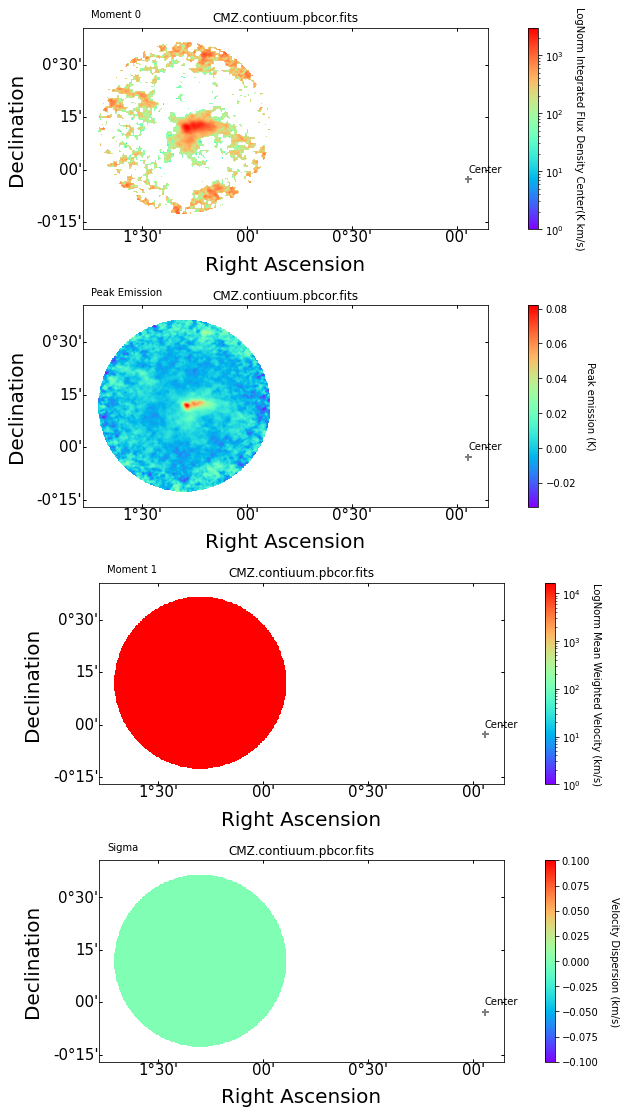

In [28]:
#Continuum

path = 'H8_continuum.pbcor.fits' #Not the right region

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True


###### Make zoomed in images
# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')
#Center: 359.94487501 -00.04391769 galcoord, ref: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=Galactic+Centre
center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')


sc = SpectralCube.read(path)

SCP = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity


subcube = SCP.to(u.K)
subcube.allow_huge_operations=True


subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 





########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(4,1,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='LogNorm Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax4 = pylab.subplot(4,1,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak emission (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(4,1,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.03,pad=0.04)                                    
cb.set_label(label='LogNorm Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax8 = pylab.subplot(4,1,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.03,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=5)


ax3.set_aspect(aspect=1)
ax4.set_aspect(aspect=1)
ax7.set_aspect(aspect=1)
ax8.set_aspect(aspect=1)

ax3.set_title("CMZ.contiuum.pbcor.fits")
ax4.set_title("CMZ.contiuum.pbcor.fits")
ax7.set_title("CMZ.contiuum.pbcor.fits")
ax8.set_title("CMZ.contiuum.pbcor.fits")

#fig1.savefig(bbox_inches='tight',fname="CMZ_HCO+_1-0_Integrated_Full_Note.jpeg")



In [39]:
path = 'NGC253_HCN.cube.reproject.K-kms.pbcor.fits'

#path = "HC3N_11_10.fits"

scP = SpectralCube.read(path)
sc = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = sc.wcs[:][:][0]

raDP1 = scW.pixel_to_world(0,0)
raDP2 = scW.pixel_to_world(1,1)

a=(raDP1)
b=(raDP2)
print(a)
print(b)

vel,NA,na = sc.world[:,0,0]

#too accurate?
#50 mili arcseconds

header5 = sc.header
beam5_a = header5["BMAJ"]*3600.0 # beam sizes in arcseconds
beam5_b = header5["BMIN"]*3600.0
pixel5 = header5["CDELT1"] * (-1)*3600.0

#print(sc.statistics())
print(header5)

print(abs(header5["CDELT3"]))# Part 2: File Reads, Moment Maps

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (11.89182186, -25.29157773)>
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (11.8918065, -25.29156384)>
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3                                                  NAXIS1  =                  488                                                  NAXIS2  =                  400                                                  NAXIS3  =                  252                                                  BMAJ    =   4.722222222222E-05                                                  BMIN    =   3.611111111111E-05                                                  BPA     =   -73.31999999999999                                                  BTYPE   = 'Intensity'                                                           OBJECT  = 'NGC253  '               

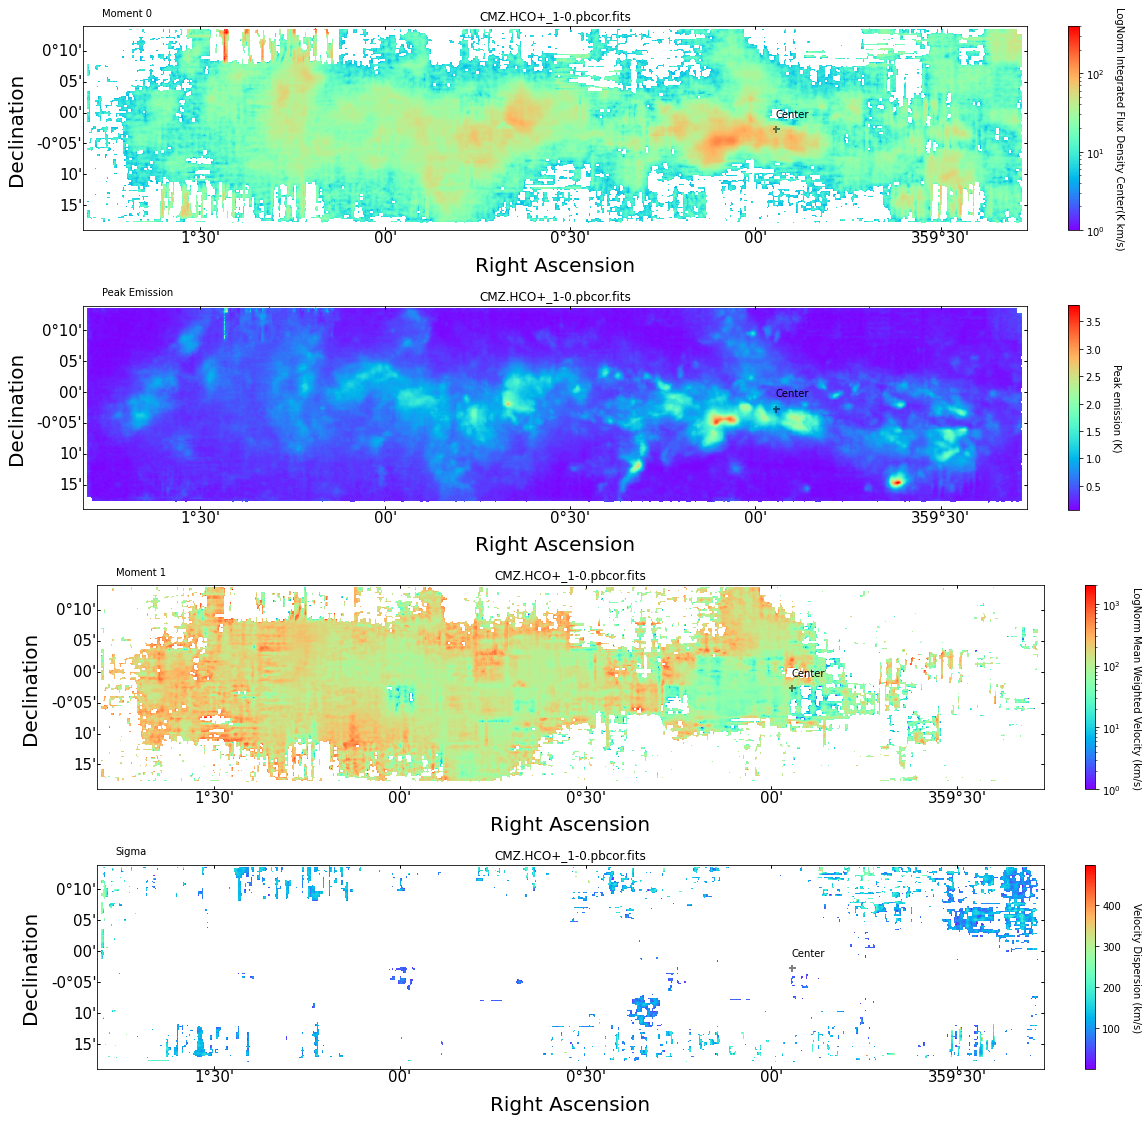

In [29]:
#HCO+ 1-0

path = 'CMZ_3mm_HCO+.fits'

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True


###### Make zoomed in images
# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')
#Center: 359.94487501 -00.04391769 galcoord, ref: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=Galactic+Centre
center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')


sc = SpectralCube.read(path)

sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity

SCP = sc_kms.spectral_slab(-800. *u.km / u.s, 800. *u.km / u.s)  # Extract a subset of the velocities
subcube = SCP.to(u.K)
subcube.allow_huge_operations=True


subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 


#Find Noise 
scW = subcube.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = subcube[0:int(len(subcube)/8),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

badpixS = pylab.where(abs(moment_0_sub)<m1*3)                 # Get ready to mask the data based on moment map
#
moment_0_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(4,1,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='LogNorm Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax4 = pylab.subplot(4,1,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak emission (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(4,1,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.03,pad=0.04)                                    
cb.set_label(label='LogNorm Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax8 = pylab.subplot(4,1,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.03,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=5)


ax3.set_aspect(aspect=1)
ax4.set_aspect(aspect=1)
ax7.set_aspect(aspect=1)
ax8.set_aspect(aspect=1)

ax3.set_title("CMZ.HCO+_1-0.pbcor.fits")
ax4.set_title("CMZ.HCO+_1-0.pbcor.fits")
ax7.set_title("CMZ.HCO+_1-0.pbcor.fits")
ax8.set_title("CMZ.HCO+_1-0.pbcor.fits")

fig1.savefig(bbox_inches='tight',fname="CMZ_HCO+_1-0_Integrated_Full_Note.jpeg")



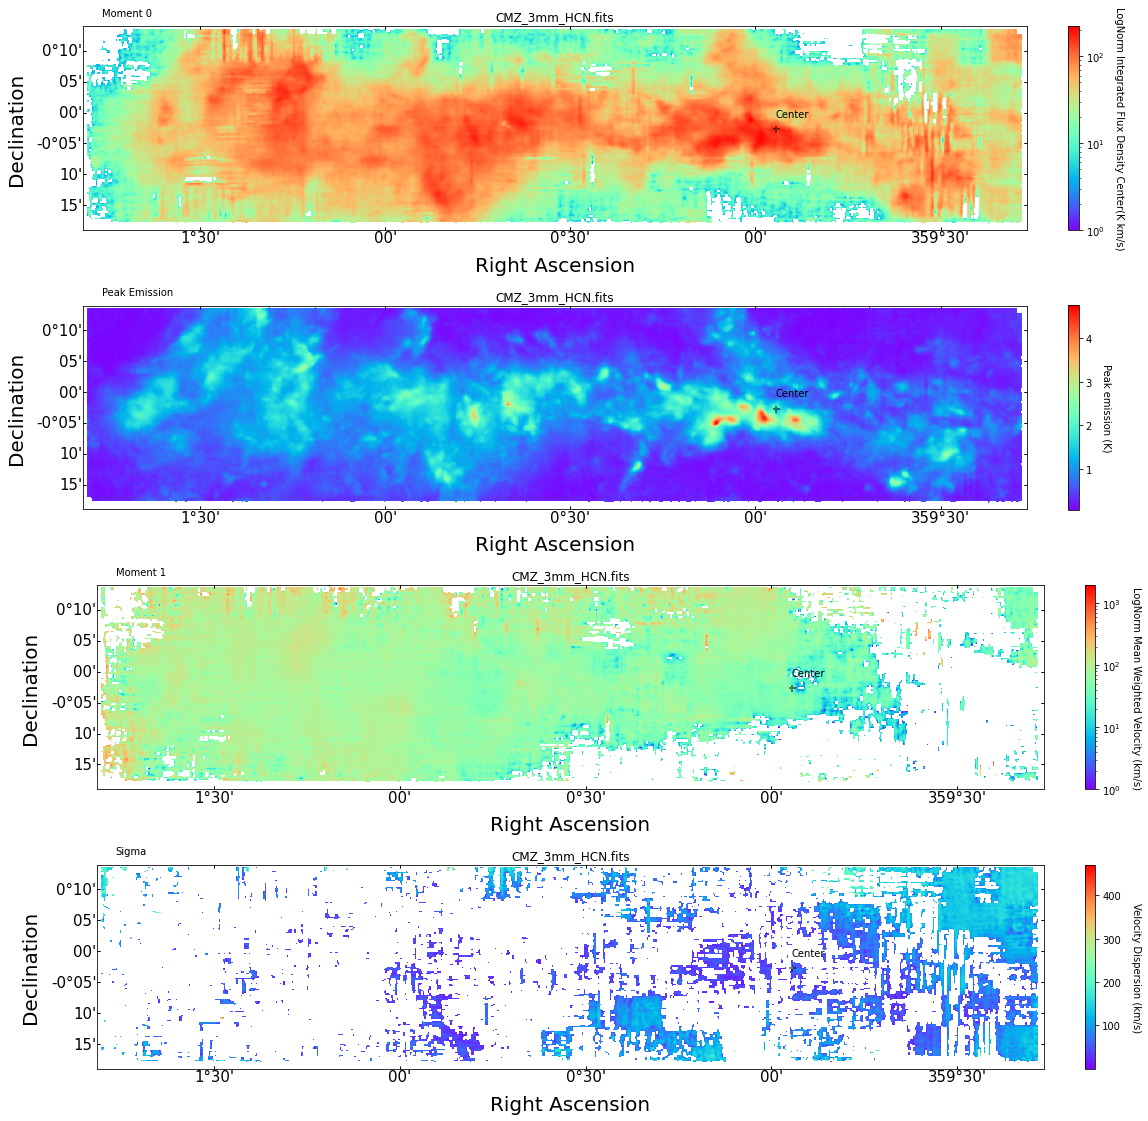

In [18]:
#HCN 1-0


path = 'CMZ_3mm_HCN.fits'

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True


###### Make zoomed in images
# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')
#Center: 359.94487501 -00.04391769 galcoord, ref: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=Galactic+Centre
center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')


sc = SpectralCube.read(path)

sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity

SCP = sc_kms.spectral_slab(-800. *u.km / u.s, 800. *u.km / u.s)  # Extract a subset of the velocities
subcube = SCP.to(u.K)
subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 


#Find Noise 
scW = subcube.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = subcube[0:int(len(subcube)/8),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

badpixS = pylab.where(abs(moment_0_sub)<m1*3)                 # Get ready to mask the data based on moment map
#
moment_0_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(4,1,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='LogNorm Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax4 = pylab.subplot(4,1,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak emission (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(4,1,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.03,pad=0.04)                                    
cb.set_label(label='LogNorm Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax8 = pylab.subplot(4,1,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.03,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=5)


ax3.set_aspect(aspect=1)
ax4.set_aspect(aspect=1)
ax7.set_aspect(aspect=1)
ax8.set_aspect(aspect=1)

ax3.set_title('CMZ_3mm_HCN.fits')
ax4.set_title("CMZ_3mm_HCN.fits")
ax7.set_title("CMZ_3mm_HCN.fits")
ax8.set_title("CMZ_3mm_HCN.fits")

fig1.savefig(bbox_inches='tight',fname="CMZ_3mm_HCN_1-0_Integrated_Full_Note.jpeg")




In [31]:
#H13CO+ 1-0


path = 'CMZ_3mm_H13CO+.fits'  

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True


###### Make zoomed in images
# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')
#Center: 359.94487501 -00.04391769 galcoord, ref: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=Galactic+Centre
center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')


sc = SpectralCube.read(path)

sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity

SCP = sc_kms.spectral_slab(-800. *u.km / u.s, 800. *u.km / u.s)  # Extract a subset of the velocities
subcube = SCP.to(u.K)
subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 


#Find Noise 
scW = subcube.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = subcube[0:int(len(subcube)/8),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

badpixS = pylab.where(abs(moment_0_sub)<m1*3)                 # Get ready to mask the data based on moment map
#
moment_0_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(4,1,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='LogNorm Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax4 = pylab.subplot(4,1,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak emission (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(4,1,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.03,pad=0.04)                                    
cb.set_label(label='LogNorm Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax8 = pylab.subplot(4,1,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.03,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=5)


ax3.set_aspect(aspect=1)
ax4.set_aspect(aspect=1)
ax7.set_aspect(aspect=1)
ax8.set_aspect(aspect=1)

ax3.set_title('CMZ_3mm_H13CO+.fits')
ax4.set_title('CMZ_3mm_H13CO+.fits')
ax7.set_title('CMZ_3mm_H13CO+.fits')
ax8.set_title('CMZ_3mm_H13CO+.fits')

fig1.savefig(bbox_inches='tight',fname="CMZ_3mm_H13COp_1-0_Integrated_Full_Note.jpeg")

FileNotFoundError: [Errno 2] No such file or directory: 'CMZ_3mm_H13CO+.fits'

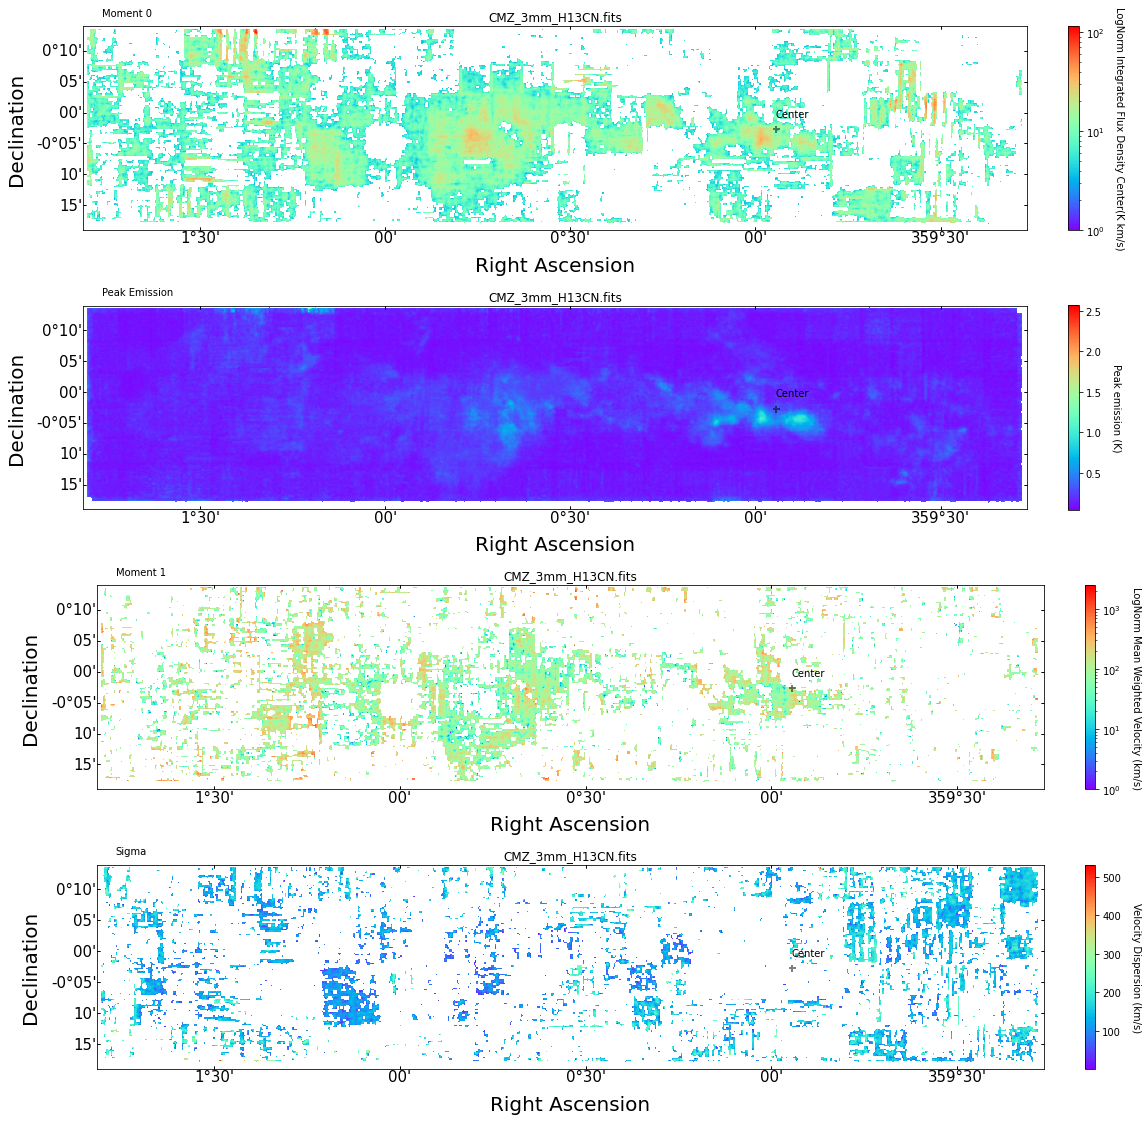

In [22]:
#H13CN_J1-0

path = 'CMZ_3mm_H13CN.fits'

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True


###### Make zoomed in images
# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')
#Center: 359.94487501 -00.04391769 galcoord, ref: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=Galactic+Centre
center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')


sc = SpectralCube.read(path)

sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # change from frequency to velocity

SCP = sc_kms.spectral_slab(-800. *u.km / u.s, 800. *u.km / u.s)  # Extract a subset of the velocities
subcube = SCP.to(u.K)
subcube.allow_huge_operations=True


subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 


#Find Noise 
scW = subcube.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = subcube[0:int(len(subcube)/8),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

badpixS = pylab.where(abs(moment_0_sub)<m1*3)                 # Get ready to mask the data based on moment map
#
moment_0_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(4,1,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='LogNorm Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax4 = pylab.subplot(4,1,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak emission (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


pylab.tight_layout(w_pad=10,h_pad=5)



#########Moment 1 and Sigma


ax7 = pylab.subplot(4,1,3,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub.hdu.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.03,pad=0.04)                                    
cb.set_label(label='LogNorm Mean Weighted Velocity (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  


ax8 = pylab.subplot(4,1,4, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub.hdu.data,cmap='rainbow')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+10))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.03,pad=0.04)                                      
cb.set_label(label='Velocity Dispersion (km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Sigma',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction") 
pylab.tight_layout(w_pad=10,h_pad=5)



ax3.set_aspect(aspect=1)
ax4.set_aspect(aspect=1)
ax7.set_aspect(aspect=1)
ax8.set_aspect(aspect=1)

ax3.set_title('CMZ_3mm_H13CN.fits')
ax4.set_title('CMZ_3mm_H13CN.fits')
ax7.set_title('CMZ_3mm_H13CN.fits')
ax8.set_title('CMZ_3mm_H13CN.fits')
fig1.savefig(bbox_inches='tight',fname="'CMZ_3mm_H13CN_Integrated_Full_Note.jpeg")


# Part 3: Image Ratios

H13CN StandardDev:  2.691566261335012 K km / s HCN StandardDev:  2.1441413385398365 K km / s


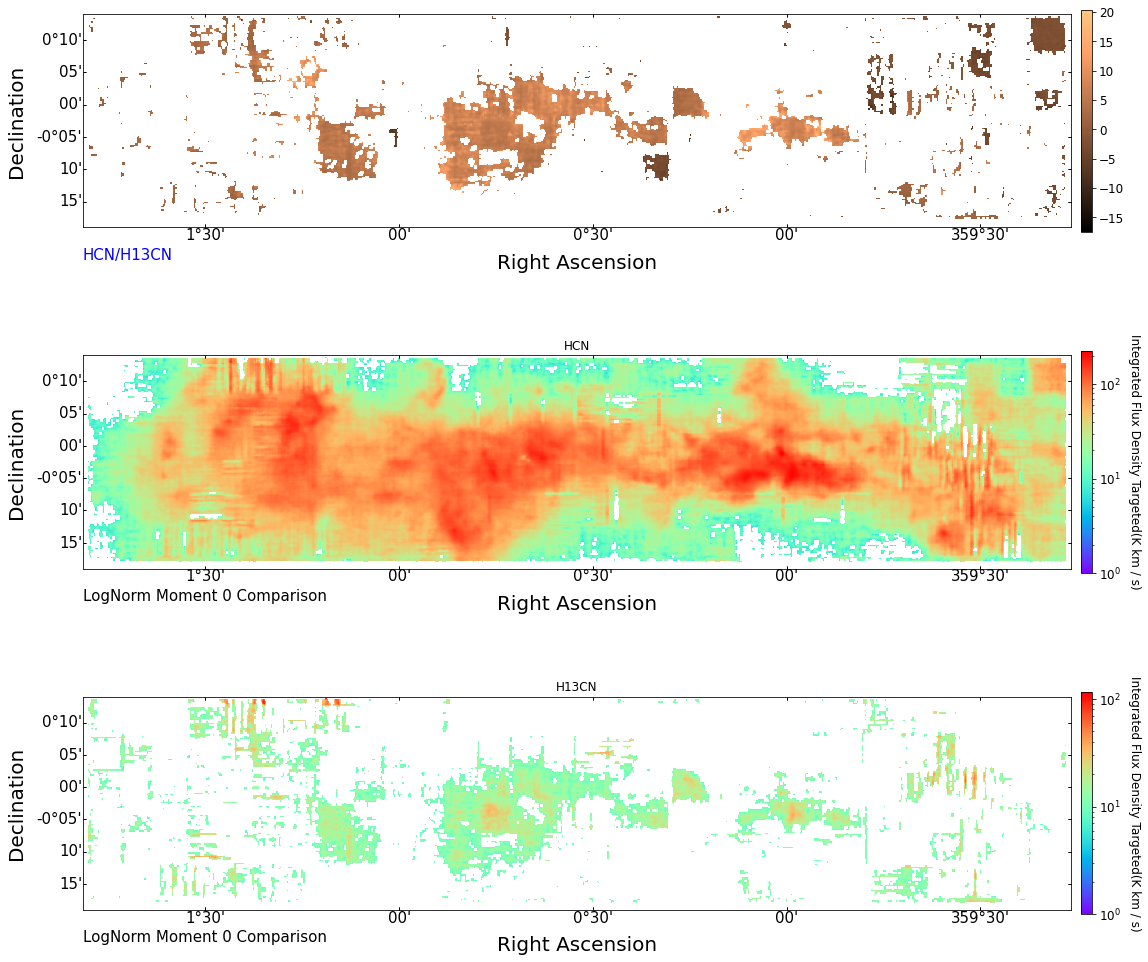

In [13]:


what = "HCN/H13CN"
top = "HCN"
bot="H13CN"
#####Zoom in

sc2B = SpectralCube.read('CMZ_3mm_HCN.fits')    #Top
sc1B = SpectralCube.read('CMZ_3mm_H13CN.fits')  #Bot


#Find Noise 1 
scW = sc1B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#Find Noise 2
scW = sc2B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(15,15))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(3,1,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.011,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.0,-.15),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(h_pad=4)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(3,1,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(3,1,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="CMZ_HCN_Over_H13CN.jpeg")

H13CO+ StandardDev:  4.011937106229702 K km / s HCO+ StandardDev:  2.9731386414923877 K km / s


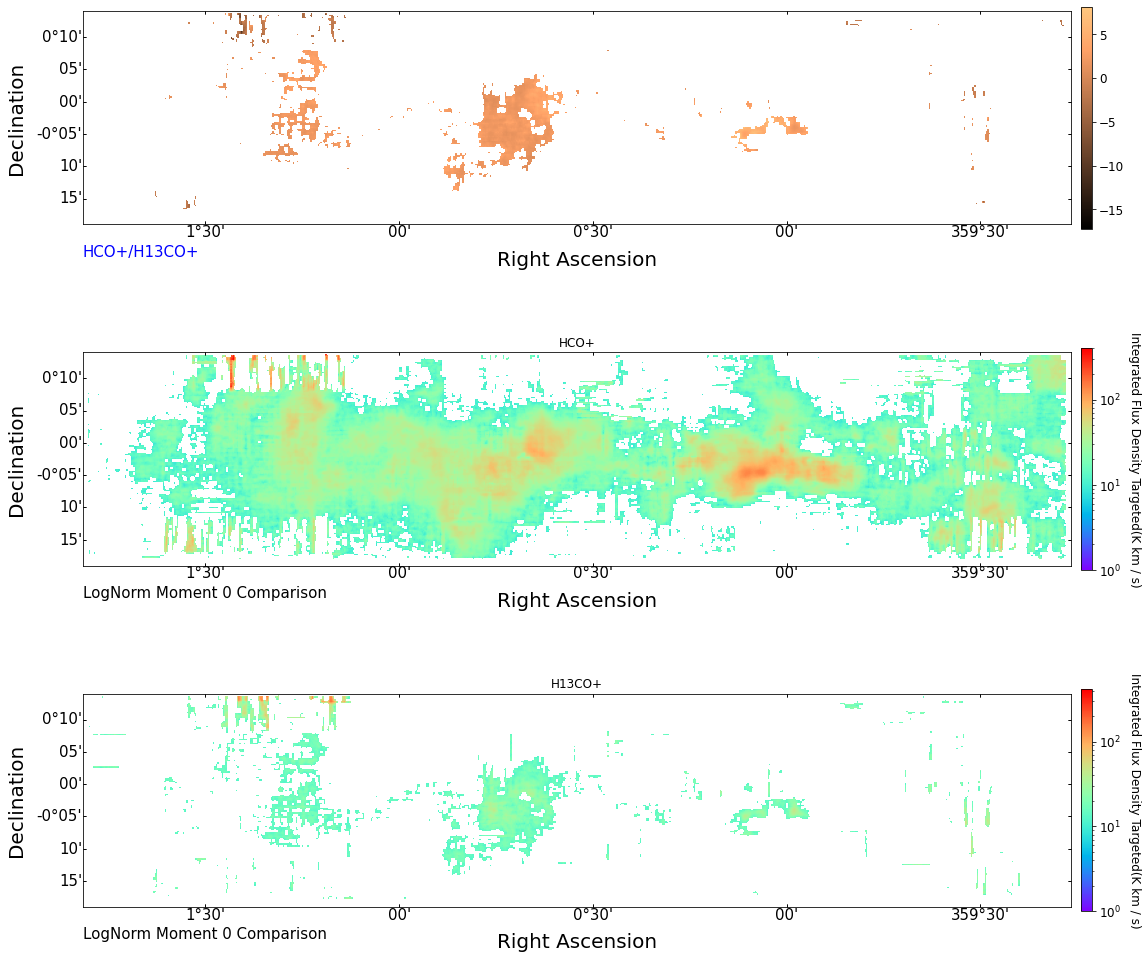

In [14]:


what = "HCO+/H13CO+"
top = "HCO+"
bot="H13CO+"
#####Zoom in

sc2B = SpectralCube.read('CMZ_3mm_HCO+.fits')    #Top
sc1B = SpectralCube.read('CMZ_3mm_H13CO+.fits')  #Bot


#Find Noise 1 
scW = sc1B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#Find Noise 2
scW = sc2B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(15,15))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(3,1,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.011,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.0,-.15),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(h_pad=4)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(3,1,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(3,1,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="CMZ_HCOp_Over_H13COp.jpeg")

H13CO+ StandardDev:  4.011937106229702 K km / s H13CN StandardDev:  2.691566261335012 K km / s


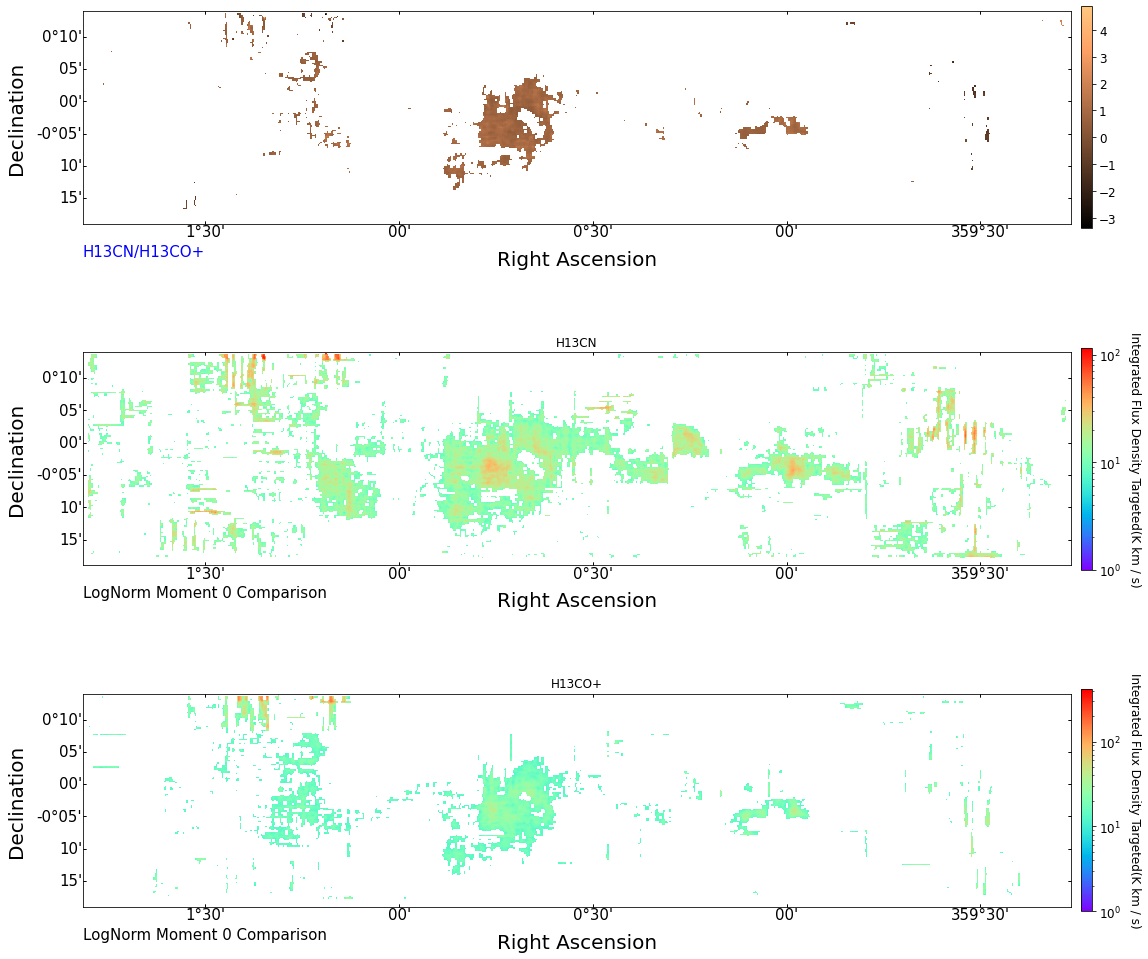

In [15]:


what = "H13CN/H13CO+"
top = "H13CN"
bot="H13CO+"
#####Zoom in

sc2B = SpectralCube.read('CMZ_3mm_H13CN.fits')    #Top
sc1B = SpectralCube.read('CMZ_3mm_H13CO+.fits')  #Bot


#Find Noise 1 
scW = sc1B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#Find Noise 2
scW = sc2B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(15,15))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(3,1,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.011,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.0,-.15),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(h_pad=4)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(3,1,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(3,1,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="CMZ_H13CN_Over_H13COp.jpeg")

HCO+ StandardDev:  4.011937106229702 K km / s H13CN StandardDev:  2.691566261335012 K km / s


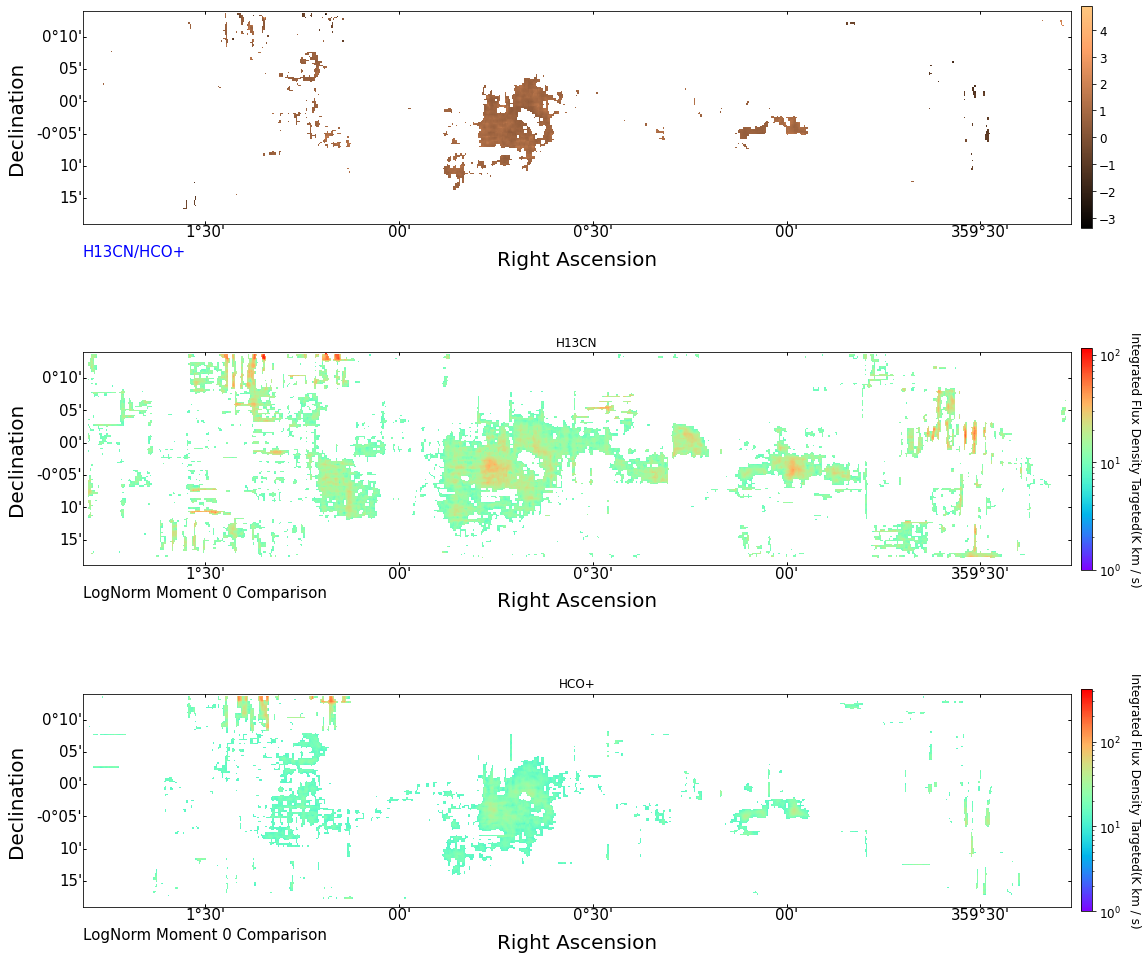

In [16]:

what = "H13CN/HCO+"
top = "H13CN"
bot="HCO+"
#####Zoom in

sc1 = SpectralCube.read('CMZ_3mm_HCO+.fits')   
sc2 = SpectralCube.read('CMZ_3mm_H13CN.fits')


#Find Noise 1 
scW = sc1B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#Find Noise 2
scW = sc2B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(15,15))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(3,1,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.011,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.0,-.15),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(h_pad=4)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(3,1,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(3,1,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="CMZ_H13CN_Over_HCO_Plus.jpeg")

HCO+ StandardDev:  2.9731386414923877 K km / s HCN StandardDev:  2.1441413385398365 K km / s


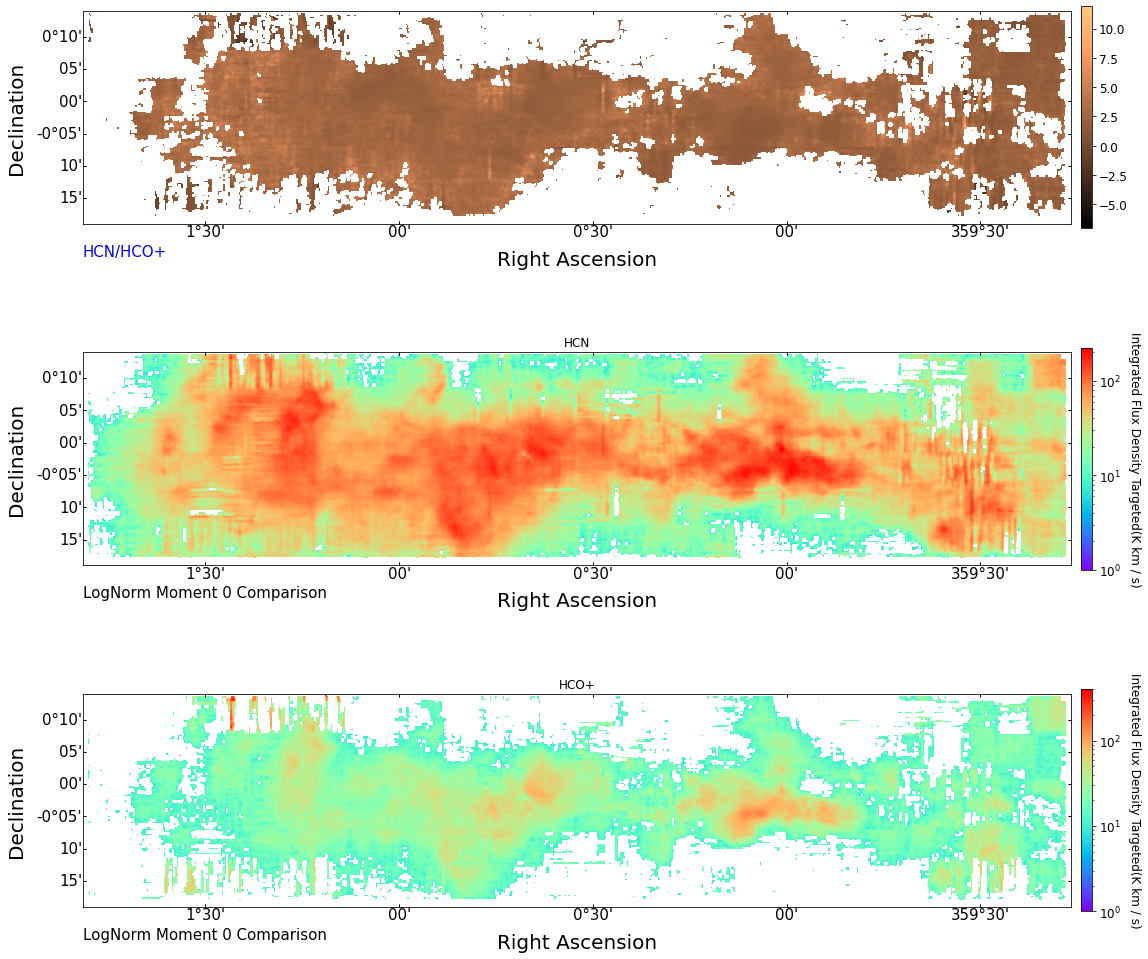

In [17]:

what = "HCN/HCO+"
top = "HCN"
bot="HCO+"
#####Zoom in

sc1B = SpectralCube.read('CMZ_3mm_HCO+.fits')
sc2B = SpectralCube.read('CMZ_3mm_HCN.fits') 
#Find Noise 1 
scW = sc1B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc1B[0:int(len(sc1B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N1kms = Nsc1.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N1kms.allow_huge_operations=True
N1Kkma = N1kms.to(u.K)
N1Mom  = N1Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m1=N1Mom.std()

#Find Noise 2
scW = sc2B.wcs[:][:][0]
Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc2 = sc2B[0:int(len(sc2B)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
#Find StandardDev of this noise cube
N2kms = Nsc2.with_spectral_unit(u.km/u.s,velocity_convention="radio")
N2kms.allow_huge_operations=True
N2Kkma = N2kms.to(u.K)
N2Mom  = N2Kkma.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
m2=N2Mom.std()

print(bot,"StandardDev: ",str(m1),top,"StandardDev: ",m2)
#####

sc1_kms = sc1B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc1_kms.allow_huge_operations=True
sc1_K_kms = sc1_kms.to(u.K)
sc2_kms = sc2B.with_spectral_unit(u.km/u.s,velocity_convention="radio")
sc2_kms.allow_huge_operations=True
sc2_K_kms = sc2_kms.to(u.K)
sc1_moment0  = sc1_K_kms.moment(order=0,how='slice')    # Calculate the first Moment 0 map 
sc2_moment0  = sc2_K_kms.moment(order=0,how='slice')    # Calculate the second Moment 0 map 



badpixS = pylab.where(abs(sc1_moment0)<m1*3)                 # Get ready to mask the data based on moment map
sc1_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
badpixS = pylab.where(abs(sc2_moment0)<m2*3)                 # Get ready to mask the data based on moment map
sc2_moment0.hdu.data[badpixS] = np.nan                          # Mask the moment 0 map under 3 sigma
sc1_moment0_reproject, footprint = reproject_interp(sc1_moment0.hdu,sc2_moment0.header)
                                                        # Now that images are same size, compute ratio of moment maps
ratio = sc2_moment0.hdu.data/sc1_moment0_reproject

fig1 = pylab.figure(1,figsize=(15,15))
scWCS=sc2_moment0.wcs
ax1 = pylab.subplot(3,1,1,projection=scWCS)

im1 = pylab.imshow(ratio,cmap='copper')
RA = ax1.coords[0]                                                                  
Dec = ax1.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)                                                                                    
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im1,fraction=0.011,pad=0.01)
cb.ax.tick_params(which = 'major', labelsize = 12)   
pylab.annotate(s=what,fontsize=15,xy=(.0,-.15),xycoords="axes fraction",c="Blue");  
pylab.tight_layout(h_pad=4)
######Moment 0 
scWCS=sc2_moment0.wcs
ax2 = pylab.subplot(3,1,2, projection=scWCS)
RA = ax2.coords[0]                                                                  # 
Dec = ax2.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
im2=pylab.imshow(sc2_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im2,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax2.set_title(top)

scWCS=sc1_moment0.wcs
ax3 = pylab.subplot(3,1,3, projection=scWCS)
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1] 
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True) 
im3=pylab.imshow(sc1_moment0.data,cmap='rainbow',norm=colors.LogNorm(vmin=1))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1) 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.011,pad=0.01)                                      
cb.set_label(label='Integrated Flux Density Targeted(K km / s)',fontsize=12,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 12)  
pylab.annotate(s='LogNorm Moment 0 Comparison',fontsize=15,xy=(.0,-.15),xycoords="axes fraction")  
pylab.tight_layout(h_pad=4)
ax3.set_title(bot)


fig1.savefig(bbox_inches='tight',fname="CMZ_HCN_Over_HCO_Plus.jpeg")

# Part 4: Channel Maps

In [ ]:


#####Zoom in

sc = SpectralCube.read('CMZ_3mm_HCO+.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,15))

                                            
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(np.exp(SC_Bin.hdu.data[i]),cmap='rainbow',norm=colors.LogNorm(vmin=np.exp(-20),vmax=np.exp(20)))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)




fig1.savefig(bbox_inches='tight',fname="NGC253.HCO+_4-3_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('CMZ_3mm_HCN.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = sc.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,15))

                                            
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(np.exp(SC_Bin.hdu.data[i]),cmap='rainbow',norm=colors.LogNorm(vmin=np.exp(-20),vmax=np.exp(20)))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.HCN_4-3_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('CMZ_3mm_H13CN.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,15))

                                            
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(np.exp(SC_Bin.hdu.data[i]),cmap='rainbow',norm=colors.LogNorm(vmin=np.exp(-1),vmax=np.exp(1)))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
        
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5.2,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.H13CN_4-3_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('HCN_J1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,15))

                                            
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(np.exp(SC_Bin.hdu.data[i]),cmap='rainbow',norm=colors.LogNorm(vmin=np.exp(-3),vmax=np.exp(12)))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.HCN_J1_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('HCOp_J1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels

fig1 = pylab.figure(1,figsize=(15,15))

                                            
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(np.exp(SC_Bin.hdu.data[i]),cmap='rainbow',norm=colors.LogNorm(vmin=np.exp(-3),vmax=np.exp(15)))
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.HCO+_1-0_CM.jpeg")

In [ ]:




#H13CO+_J1-0, 86.754330 GHz, ref: https://iopscience.iop.org/article/10.1086/497881/pdf


#_and_SiO_J2-1 86.846998 GHz

# Use this to find freq range: regpix.meta['restfreq'] = [100 * u.GHz] # rest frequency 


#Here we specify the frequency and range of velocities (up to 320 m/s) and make a cube with only the H13CO+ data

path = 'H13COp_J1-0_SiO_J2-1.cube.fits'

cubeB = SpectralCube.read(path)


regpix = regions.RectanglePixelRegion(regions.PixCoord(int(cubeB.shape[1]/2), int(cubeB.shape[1]/2)), width=int(cubeB.shape[1]-1), height=int(cubeB.shape[1]-1))  
regpix.meta['range'] = [100 * u.km/u.s, 300 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 86.754330*u.GHz # rest frequency of H13CO+ J1-0
#print(type(regpix.meta['restfreq']))
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = cubeB.subcube_from_regions([regpix])  #Make the subcube with the specified frequency

sc = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=86.754330*u.GHz)
cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = cube.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


scN = cube[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position


scW = subcube.wcs[:][:][0]

#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(4,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels
fig1 = pylab.figure(1,figsize=(15,15))
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(SC_Bin.hdu.data[i],cmap='rainbow',vmin=-5,vmax=40)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.H13CO+_J1-0_CM.jpeg")

In [ ]:
#H13CO+_J1-0, 86.754330 GHz, ref: https://iopscience.iop.org/article/10.1086/497881/pdf


#_and_SiO_J2-1 86.846998 GHz

# Use this to find freq range: regpix.meta['restfreq'] = [100 * u.GHz] # rest frequency 


#Here we specify the frequency and range of velocities (up to 320 m/s) and make a cube with only the H13CO+ data

path = 'H13COp_J1-0_SiO_J2-1.cube.fits'

cubeB = SpectralCube.read(path)


regpix = regions.RectanglePixelRegion(regions.PixCoord(int(cubeB.shape[1]/2), int(cubeB.shape[1]/2)), width=int(cubeB.shape[1]-1), height=int(cubeB.shape[1]-1))  
regpix.meta['range'] = [100 * u.km/u.s, 300 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 86.846998*u.GHz # rest frequency of SiOJ2-1
#print(type(regpix.meta['restfreq']))
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = cubeB.subcube_from_regions([regpix])  #Make the subcube with the specified frequency

sc = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=86.846998*u.GHz)
cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = cube.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


scN = cube[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position


scW = subcube.wcs[:][:][0]

#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-500. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(4,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels
fig1 = pylab.figure(1,figsize=(15,15))
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(SC_Bin.hdu.data[i],cmap='rainbow',vmin=-5,vmax=30)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.SiO_J2-1_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('H13CN_J1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(8,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels
fig1 = pylab.figure(1,figsize=(15,15))
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(SC_Bin.hdu.data[i],cmap='rainbow',vmin=-.2,vmax=3)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5.3,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.H13CN_1-0_CM.jpeg")

In [ ]:


#####Zoom in

sc = SpectralCube.read('ngc253_co32_hires_common.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

scN = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-200. *u.km / u.s, 700. *u.km / u.s)  # Extract a subset of the velocities
SC_Bin = SC_K_KMS_slab.downsample_axis(4,axis=0) # Here we use downsampling to bin (average)the data 
                                                # into coarse bins (broad channels) with width ~ 11 km/s    

vel, dec, ra = SC_Bin.world[:,0,0]           # For plotting purposes, I want to know the average velocity
                                                # for each of these new averaged channels
fig1 = pylab.figure(1,figsize=(15,15))
for i in np.arange(0,len(SC_Bin.hdu.data)):                       # Now we loop through each slice (averaged channels) 
    ax = pylab.subplot(10,5,i+1,projection=scW) # We plot them in a grid
    #Create e^intesity plots
    im = pylab.imshow(SC_Bin.hdu.data[i],cmap='rainbow',vmin=-5,vmax=50)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(10,25,s="%i km/s"%(vel.value[i]),fontsize=10) # Print the velocity of each averaged channel
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if i==len(SC_Bin.hdu.data)-1:
        pylab.xlabel("Right Ascension")
        pylab.ylabel("Declination",labelpad=-2)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=5,h_pad=1)



fig1.savefig(bbox_inches='tight',fname="NGC253.CO_3-2_CM.jpeg")

# Part 5: PV Plots

In [ ]:
sc = SpectralCube.read('CMZ_3mm_HCO+.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(100 *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=2)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.HCO+_4-3.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.HCO+_4-3_PV.jpeg")

In [ ]:
sc = SpectralCube.read('CMZ_3mm_HCN.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(100 *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=2)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.HCN_4-3.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.HCN_4-3_PV.jpeg")

In [ ]:
sc = SpectralCube.read('CMZ_3mm_H13CN.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(100 *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=2)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.H13CN_4-3.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.H13CN_4-3_PV.jpeg")

In [ ]:
sc = SpectralCube.read('HCN_J1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)

SC_K_KMS_slab = SC_K_KMS.spectral_slab(100 *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=1)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.HCN_1-0.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.HCN_1-0_PV.jpeg")

In [ ]:
#H13CO+_J1-0, 86.754330 GHz, ref: https://iopscience.iop.org/article/10.1086/497881/pdf


#_and_SiO_J2-1 86.846998 GHz

# Use this to find freq range: regpix.meta['restfreq'] = [100 * u.GHz] # rest frequency 


#Here we specify the frequency and range of velocities (up to 320 m/s) and make a cube with only the H13CO+ data

path = 'H13COp_J1-0_SiO_J2-1.cube.fits'

cubeB = SpectralCube.read(path)


regpix = regions.RectanglePixelRegion(regions.PixCoord(int(cubeB.shape[1]/2), int(cubeB.shape[1]/2)), width=int(cubeB.shape[1]-1), height=int(cubeB.shape[1]-1))  
regpix.meta['range'] = [100 * u.km/u.s, 300 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 86.754330*u.GHz # rest frequency of H13CO+
#print(type(regpix.meta['restfreq']))
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = cubeB.subcube_from_regions([regpix])  #Make the subcube with the specified frequency
cube = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=86.754330*u.GHz)
cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = cube.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)   

scN = cube[:,raDP1[1]:raDP2[1],:] # Make a subcube based on position

#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(100 *u.km / u.s, 400. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=4)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("H13COp_J1-0_SiO_J2-1.cube.fits (H13CO+)")
fig.savefig(bbox_inches='tight',fname="NGC253.H13CO+_1-0_PV.jpeg")

In [ ]:
#H13CO+_J1-0, 86.754330 GHz, ref: https://iopscience.iop.org/article/10.1086/497881/pdf


#_and_SiO_J2-1 86.846998 GHz

# Use this to find freq range: regpix.meta['restfreq'] = [100 * u.GHz] # rest frequency 


#Here we specify the frequency and range of velocities (up to 320 m/s) and make a cube with only the H13CO+ data

path = 'H13COp_J1-0_SiO_J2-1.cube.fits'

cubeB = SpectralCube.read(path)


regpix = regions.RectanglePixelRegion(regions.PixCoord(int(cubeB.shape[1]/2), int(cubeB.shape[1]/2)), width=int(cubeB.shape[1]-1), height=int(cubeB.shape[1]-1))  
regpix.meta['range'] = [100 * u.km/u.s, 300 * u.km/u.s] # spectral range 
regpix.meta['restfreq'] = 86.846998*u.GHz # rest frequency of SiOJ2-1
#print(type(regpix.meta['restfreq']))
regpix.meta['veltype'] = 'OPTICAL' # velocity convention 
scb = cubeB.subcube_from_regions([regpix])  #Make the subcube with the specified frequency
cube = scb.with_spectral_unit(u.km/u.s,velocity_convention="radio",rest_value=86.846998*u.GHz)
cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')
scW = cube.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)   

scN = cube[:,raDP1[1]:raDP2[1],:] # Make a subcube based on position

#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities


fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=8)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("H13COp_J1-0_SiO_J2-1.cube.fits (SiO)")
fig.savefig(bbox_inches='tight',fname="NGC253.SiO_2-1_PV.jpeg")

In [ ]:
sc = SpectralCube.read('H13CN_J1-0.cube.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=2)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.H13CN_1-0.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.H13CN_1-0_PV.jpeg")

In [ ]:
sc = SpectralCube.read('ngc253_co32_hires_common.fits') 


cen_p1 = SkyCoord('00h47m34.2s', '-25d17m31s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.8s', '-25d17m07s', frame='icrs')

scW = sc.wcs[:][:][0]

raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

Dec_slice = int((raDP2[1]+raDP1[1])/2)                                    
    
scN = sc[:,:,raDP1[0]:raDP2[0]] # Make a subcube based on position
scW = scN.wcs[:][:][0]
#####

SC_KMS = scN.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMS.allow_huge_operations=True
SC_K_KMS = SC_KMS.to(u.K)


SC_K_KMS_slab = SC_K_KMS.spectral_slab(-100. *u.km / u.s, 500. *u.km / u.s)  # Extract a subset of the velocities

    
    
    
    
fig = pylab.figure(1,figsize=(10, 10))         # Initiate a figure and axis object with WCS projection information



# Here we have specified to plot the longitude along the x axis
                                            # We also plot only the Declination slice we have chosen, 
                                            # and plot the velocity along the y axis
ax = fig.add_subplot(111, projection=SC_K_KMS_slab.wcs, slices=('x', Dec_slice, 'y'))
RA = ax.coords[0]
Dec = ax.coords[1]
velo = ax.coords[2]

im = ax.imshow(SC_K_KMS_slab[:,Dec_slice,:].data)  # Display the image slice 
ax.set_aspect(aspect=1)

                                            # Add axes labels
ax.set_ylabel("LSR Velocity (m/s)", fontsize=16)
ax.set_xlabel("Right Ascension", fontsize=8)
velo.set_ticks(size=-2)                                                                                      
RA.set_ticks(size=-2)
                            
Dec.set_ticks_visible(False)                # Don't show a "Declination" axis because we have eliminated it
Dec.set_ticklabel_visible(False) 

                                            # Do add a colorbar
cbar = pylab.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Brightness Temperature (K)', size=16)

ax.set_title("NGC253.CO_3-2.pbcor.fits")
fig.savefig(bbox_inches='tight',fname="NGC253.CO_3-2_PV.jpeg")

# Part 6: Reporojection

In [20]:
files = pylab.array(['CMZ_3mm_HCO+.fits','CMZ_3mm_HCN.fits','CMZ_3mm_H13CN.fits','CMZ_3mm_H13CO+.fits' ])
      



for i,file in enumerate(files):
    
    sc = SpectralCube.read(file) 
    #print(sc)
    if i==0:                                # Find location of brightest emission
        z,xp,yp = pylab.where(sc.hdu.data==np.nanmax(sc.hdu.data)) 
        yRaxDec = sc.wcs[:][:][0].pixel_to_world(yp,xp)
    y, x = sc.wcs[:][:][0].world_to_pixel(yRaxDec)# Gets the pixel for the same Ra/dec of each cube
    #print(x,y)
    #Need to reduce cube size, but it won't work if theyre all the same size sometimes?
    if i ==0:
        subcube = sc[:,int(x)-20:int(x)+20,int(y)-20:int(y)+20] # Make a subcube
    if i ==1:
        subcube = sc[:,int(x)-19:int(x)+19,int(y)-19:int(y)+19] # Make a subcube
    if i ==2:
        subcube = sc[:,int(x)-18:int(x)+18,int(y)-18:int(y)+18] # Make a subcube
    if i ==3:
        subcube = sc[:,int(x)-17:int(x)+17,int(y)-17:int(y)+17] # Make a subcube
    
    #print(subcube)
    
    sc_kms = subcube.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    sc_slab = sc_kms.spectral_slab(-5000. *u.km / u.s, 5000. *u.km / u.s)  # Crop out velocities we don't care about    
    sc_slab.allow_huge_operations=True    
    sc_K_kms = sc_slab.to(u.K)
    print(sc_K_kms)
    
    
    
    if i==0:
        vel, dec, ra = sc_K_kms.world[:,0,0]            # Grab the velocity axis to use for rebinning
        
        #print(type(vel))
        vel = np.linspace(-300,300,1000)*u.km/u.s
        #print(type(vel))
        cmz_HCOp = sc_K_kms
        cmz_HCOpn = cmz_HCOp.spectral_interpolate(spectral_grid=vel) # Match velocities too         
        cmz_HCOpn.write('cmz_HCOp.cube.K-kms.pbcor.fits',overwrite=True)        
        #cmz_HCOp.write('cmz_HCOp.cube.K-kms.pbcor.fits',overwrite=True)        
    if i==1:      
        
        cmz_HCN = sc_K_kms.unmasked_copy()        
        #cmz_HCN.write('NGC253_HCN.cube.reproject.K-kms.pbcor.fits',overwrite=True)
        
    if i==2:
        cmz_H13CN = sc_K_kms.unmasked_copy()       
        
    if i==3:
        
        cmz_H13COp = sc_K_kms.unmasked_copy()
        
        

print("done")

SpectralCube with shape=(332, 40, 40) and unit=K:
 n_x:     40  type_x: GLON-SIN  unit_x: deg    range:   359.554937 deg:  359.684964 deg
 n_y:     40  type_y: GLAT-SIN  unit_y: deg    range:    -0.311663 deg:   -0.181661 deg
 n_s:    332  type_s: VRAD-W2F  unit_s: km / s  range:     -299.880 km / s:     299.846 km / s
SpectralCube with shape=(330, 38, 38) and unit=K:
 n_x:     38  type_x: GLON-SIN  unit_x: deg    range:   359.558271 deg:  359.681630 deg
 n_y:     38  type_y: GLAT-SIN  unit_y: deg    range:    -0.308330 deg:   -0.184994 deg
 n_s:    330  type_s: VRAD-W2F  unit_s: km / s  range:     -300.378 km / s:     299.469 km / s
SpectralCube with shape=(321, 36, 36) and unit=K:
 n_x:     36  type_x: GLON-SIN  unit_x: deg    range:   359.561605 deg:  359.678296 deg
 n_y:     36  type_y: GLAT-SIN  unit_y: deg    range:    -0.304996 deg:   -0.188327 deg
 n_s:    321  type_s: VRAD-W2F  unit_s: km / s  range:     -300.404 km / s:     298.523 km / s
SpectralCube with shape=(323, 34, 34)

In [21]:
cmz_HCN.allow_huge_operations=True
CMZh = cmz_HCOp.header
cmz_HCN_reproject = cmz_HCN.reproject(CMZh,use_memmap=True)         
cmz_HCN_reproject_interp = cmz_HCN_reproject.spectral_interpolate(spectral_grid=vel) # Match velocities too         
cmz_HCN_reproject_interp.write('cmz_HCN.cube.reproject.K-kms.pbcor.fits',overwrite=True)      
        
print("YESA")

YESA


In [22]:

cmz_H13CN.allow_huge_operations=True
CMZh = cmz_HCOp.header
cmz_H13CN_reproject = cmz_H13CN.reproject(CMZh,use_memmap=True)         
cmz_H13CN_reproject_interp = cmz_H13CN_reproject.spectral_interpolate(spectral_grid=vel) # Match velocities too         
cmz_H13CN_reproject_interp.write('cmz_H13CN.cube.reproject.K-kms.pbcor.fits',overwrite=True)      
        
print("YESA")

YESA


In [23]:

cmz_H13COp.allow_huge_operations=True
CMZh = cmz_HCOp.header
cmz_H13COp_reproject = cmz_H13COp.reproject(CMZh,use_memmap=True)         
cmz_H13COp_reproject_interp = cmz_H13COp_reproject.spectral_interpolate(spectral_grid=vel) # Match velocities too 

cmz_H13COp_reproject_interp.write('cmz_H13COp.cube.reproject.K-kms.pbcor.fits',overwrite=True)         
print("YESA")


YESA


In [ ]:
#All the cubes have been reprojected

# Part 7: Spectra

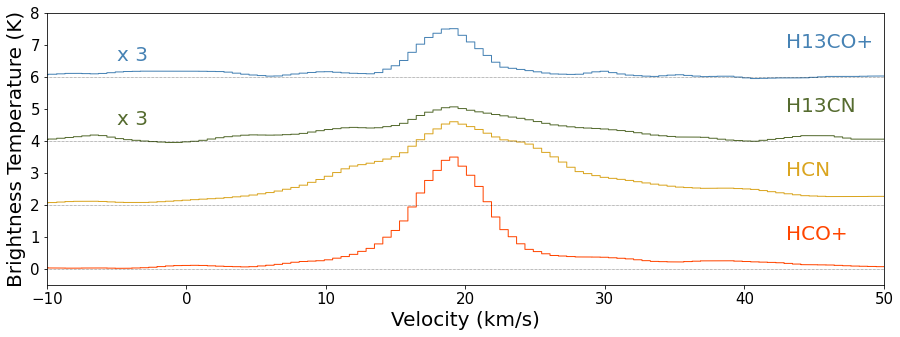

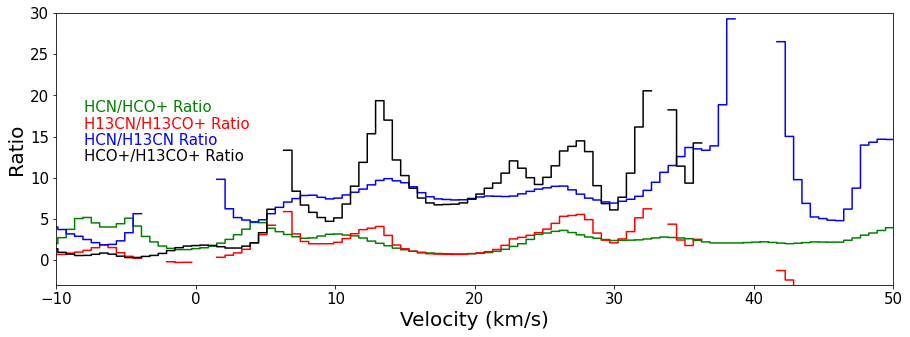

In [3]:
#Plot the first 3 spectra
#cmz_HCOp
#cmz_HCN
#cmz_H13CN
paths = pylab.array(['cmz_HCOp.cube.K-kms.pbcor.fits',
                     'cmz_HCN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13CN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13COp.cube.reproject.K-kms.pbcor.fits'])

                                            # Image-dependent plotting variables
scale = pylab.array([1,1,3,3])             # This is a factor for multiplying fainter spectra
colors = pylab.array(['OrangeRed','GoldenRod','DarkOliveGreen','SteelBlue'])
mols = pylab.array(['HCO+','HCN','H13CN','H13CO+']) #labels

                                            # Define the figure outside of loop b/c we don't need to do this 4x!
fig6 = pylab.figure(6,figsize=(15,5))
ax6=pylab.subplot() 
    
                                            # Loop through all 4 images
for i, path in enumerate(paths):
     
    
    sc = SpectralCube.read(path)
    vel, dec, ra = sc.world[:,0,0]          # For plotting purposes, I want to know the velocity for each channel
    if i==0:                                # Find location of brightest 13CO emission
        z,xp,yp = pylab.where(sc.hdu.data==np.nanmax(sc.hdu.data)) 
        yRaxDec = sc.wcs[:][:][0].pixel_to_world(yp,xp)
    y, x = sc.wcs[:][:][0].world_to_pixel(yRaxDec)# Gets the pixel for the same Ra/dec of each cube
    
                                            # Extract an average spectrum in a 20x20 pixel box
    
    subcube = sc.hdu.data[:,int(x)-1:int(x)+1,int(y)-1:int(y)+1] # Make a 20x20xN subcube
    spectrum = np.average(subcube,axis=(1,2))                        # Average in RA and Dec to get 1D spectrum


    if i==0:
        spectrum_1 = spectrum.copy()       # save this to calculate a ratio later
    if i==1:
        spectrum_2 = spectrum.copy()       # save this to calculate a ratio later
    if i==2:
        spectrum_3 = spectrum.copy()       # save this to calculate a ratio later
    if i==3:
        spectrum_4 = spectrum.copy()       # save this to calculate a ratio later
                
        
                                            # plot all spectra    
    ax6.plot(vel,spectrum*scale[i]+i*2,lw=1,drawstyle='steps-mid',color=colors[i])
    pylab.xlabel('Velocity (km/s)',fontsize=20)
    pylab.ylabel('Brightness Temperature (K)',fontsize=20)
    pylab.ylim(-.5,8)
    pylab.xlim(-10,50)
    pylab.axhline(i*2,color='black',ls=':',lw=0.5)
    pylab.text(43,i*2+.9,mols[i],color=colors[i],fontsize=20)
    if scale[i]!=1:
        pylab.text(-5,i*2+.5,"x %i"%scale[i],color=colors[i],fontsize=20)
    ax6.tick_params(axis = 'both', which = 'major', labelsize = 15)


                                            # Plot a figure showing the line ratio
                                            # If we hadn't forced all the images to have the same velocity axis
                                            # using spectral_interpolate this would throw a big error!!
                


spectrum_1T=spectrum_1.copy()
spectrum_2T=spectrum_2.copy()
spectrum_3T=spectrum_3.copy()
spectrum_4T=spectrum_4.copy()


badchan13 = pylab.where(abs(spectrum_1) < 0.01)
badchan18 = pylab.where(abs(spectrum_3) < 0.01)
spectrum_1T[badchan13] = np.nan
spectrum_3T[badchan18] = np.nan

badchan12 = pylab.where(abs(spectrum_2) < 0.01)
spectrum_2T[badchan12] = np.nan

badchan4 = pylab.where(abs(spectrum_4) < 0.01)
spectrum_4T[badchan4] = np.nan

fig7 = pylab.figure(7,figsize=(15,5))
ax7=pylab.subplot() 
ax7.plot(vel,spectrum_2T/spectrum_1T,drawstyle='steps-mid',color="Green")
ax7.plot(vel,spectrum_3T/spectrum_4T,drawstyle='steps-mid',color="Red")
ax7.plot(vel,spectrum_2T/spectrum_3T,drawstyle='steps-mid',color="Blue")
ax7.plot(vel,spectrum_1T/spectrum_4T,drawstyle='steps-mid',color="Black")
pylab.ylim(-3,30)
pylab.xlim(-10,50)
pylab.xlabel('Velocity (km/s)',fontsize=20)
pylab.ylabel('Ratio',fontsize=20)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)
pylab.text(-8,18,"HCN/HCO+ Ratio",color="Green",fontsize=15)

pylab.text(-8,16,"H13CN/H13CO+ Ratio",color="Red",fontsize=15)
pylab.text(-8,14,"HCN/H13CN Ratio",color="Blue",fontsize=15)
pylab.text(-8,12,"HCO+/H13CO+ Ratio",color="Black",fontsize=15)
fig6.savefig(bbox_inches='tight',fname="CMZ_Spectra.png")
fig7.savefig(bbox_inches='tight',fname="CMZ_Spectra_Ratio.png")


In [2]:
#Spectra's Region, HCOP, HCN, H13CN J1-0


                                            # Define the figure outside of loop b/c we don't need to do this 4x!
fig1 = pylab.figure(figsize=(15,15))




new_path = 'cmz_HCOp.cube.K-kms.pbcor.fits' 
subcubeN = SpectralCube.read(new_path)#Get iamge #[:,int(x)-50:int(x)+50,int(y)-50:int(y)+50] #Create zoomed cube

mom_0_Sub = subcubeN.moment(order=0,how='slice')

scWCS = mom_0_Sub.wcs

y, x = subcubeN.wcs[:][:][0].world_to_pixel(yRaxDec)# Gets the pixel for the same Ra/dec of each cube

ax2 = pylab.subplot(4,1,1,projection=subcubeN.wcs[0]) 
mom_0_Sub = np.nansum(subcubeN,axis=0) 
RA = ax2.coords[0]                                                                  # hi
Dec = ax2.coords[1]
im2 = pylab.imshow(mom_0_Sub,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)    
pylab.plot(y,x,'+',ms=10,mec='black',mfc='black',mew=3.5,alpha=.5)
pylab.annotate("Spectral Subcube location (2x2)",(y,x+5))
pylab.xlabel('Right Ascension',fontsize=10,labelpad=1)                               
pylab.ylabel('Declination',fontsize=10,labelpad=0)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)    
cb=pylab.colorbar(im2,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Targeted(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10 )   
pylab.annotate(s='Integrated Flux Density Targeted(K km/s)',fontsize=10,xy=(0.02,0.91),xycoords="axes fraction")  
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
ax2.set_title("NGC253.HCO+_4-3.pbcor.fits")
pylab.tight_layout(w_pad=13,h_pad=1)
fig1.savefig(bbox_inches='tight',fname="NGC253_HCO+_With_Lines_Pos_4-3_Integrated.jpeg")



#Spectra's Region, other lines





new_path = 'cmz_H13CN_0.cube.reproject.K-kms.pbcor.fits' 
subcubeN = SpectralCube.read(new_path)#Get iamge #[:,int(x)-50:int(x)+50,int(y)-50:int(y)+50] #Create zoomed cube

mom_0_Sub = subcubeN.moment(order=0,how='slice')

scWCS = mom_0_Sub.wcs

y, x = subcubeN.wcs[:][:][0].world_to_pixel(yRaxDec2)# Gets the pixel for the same Ra/dec of each cube

ax3 = pylab.subplot(4,1,2,projection=subcubeN.wcs[0]) 
mom_0_Sub = np.nansum(subcubeN,axis=0) 
RA = ax3.coords[0]                                                                  # hi
Dec = ax3.coords[1]
im3 = pylab.imshow(mom_0_Sub,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3)    
pylab.plot(y,x,'+',ms=10,mec='black',mfc='black',mew=2.5,alpha=.5)
pylab.annotate("Spectral Subcube location (10x10)",(y,x+5))
pylab.xlabel('Right Ascension',fontsize=10,labelpad=1)                               
pylab.ylabel('Declination',fontsize=10,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 20)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Targeted(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Integrated Flux Density Targeted(K km/s)',fontsize=10,xy=(0.02,0.91),xycoords="axes fraction")  
RA.set_ticklabel(exclude_overlapping=True)
Dec.set_ticklabel(exclude_overlapping=True)
pylab.tight_layout(w_pad=13,h_pad=1)
ax3.set_title('cmz_H13CN_0.cube.reproject.K-kms.pbcor.fits' )


fig1.savefig(bbox_inches='tight',fname="CMZ_Lines_Pos_Integrated.jpeg")



NameError: name 'yRaxDec' is not defined

<Figure size 1080x1080 with 0 Axes>

# Part 8: Dendograms

0.03917200719615391 0.03917200719615391 nan cmz_HCOp.cube.K-kms.pbcor.fits
() (1, 40, 40)
0.05001349588439796 0.05001349588439796 nan cmz_HCN.cube.reproject.K-kms.pbcor.fits
() (1, 40, 40)
0.04457892630252463 0.04457892630252463 nan cmz_H13CN.cube.reproject.K-kms.pbcor.fits
() (1, 40, 40)
0.044767420421651924 0.044767420421651924 nan cmz_H13COp.cube.reproject.K-kms.pbcor.fits
() (1, 40, 40)
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  765                                                  NAXIS2  =                  165                                                  NAXIS3  =                  166                                                  BLANK   =                   -1  /                                               BUNIT   = 'K       '  /                       

Text(0.02, 0.91, 'Confidence')

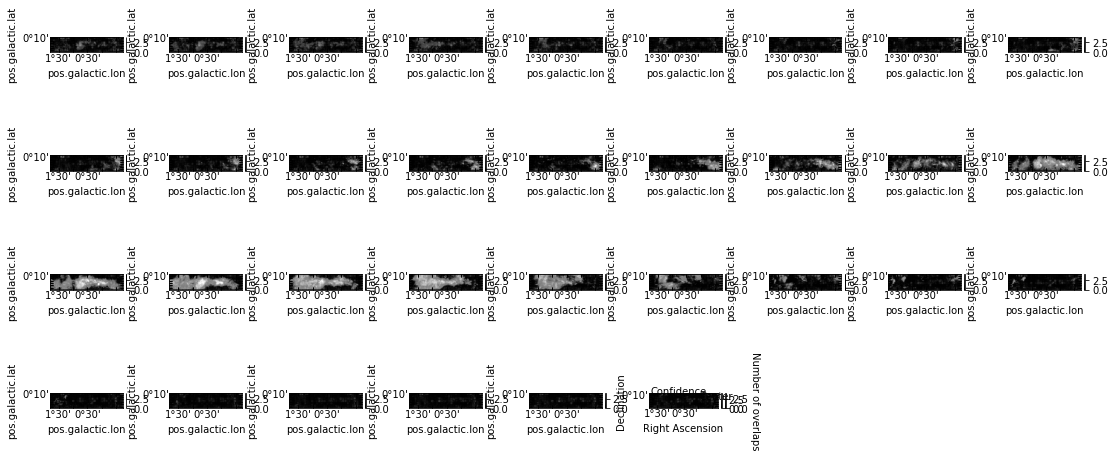

In [11]:
#Create a mask for all the cubes. 

###################No #If there is another cube that shares at least 67% of the structure, a structure is not to be masked.

#If there are multiple pixels that have greater than 3 sigma emission we will keep them (at most  (1-.95)**2 chance of incorrect label)

#Assign greater confidence to more overlaps


paths = pylab.array(['cmz_HCOp.cube.K-kms.pbcor.fits',
                     'cmz_HCN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13CN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13COp.cube.reproject.K-kms.pbcor.fits'])

FP = pylab.array(['CMZ_3mm_HCO+.fits','CMZ_3mm_HCN.fits','CMZ_3mm_H13CN.fits','CMZ_3mm_H13CO+.fits' ])





SCWs=[]
cds=[]
Ns = [] #get sigmas for all cubes
Absorbtion_mask="No"

#Find noises for first cubes
for i in range(len(FP)):
    sc = SpectralCube.read(paths[i])#FP[i])  
    
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
    sc_slabP = sc_kms.spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)  # Crop out velocities we don't care about    
    
    sc_slabP.allow_huge_operations=True    
    
    sc_slab = sc_slabP.downsample_axis(2,axis=0)
    
    sc_slab.allow_huge_operations=True    
    
    sc_K_kms = sc_slab.to(u.K)
    
    scW = sc_K_kms.wcs[:][:][0]

    #Find Noise 
    Np1 = SkyCoord('01d31m00s', '00d00m00s', frame='galactic')#These are away from the sources
    Np2 = SkyCoord('01d30m00s', '00d10m00s', frame='galactic')
    NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
    NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
    
        
    
    no = 3
    m=0
    while(True):

        Q = sc_K_kms[int(len(sc_K_kms)-no):len(sc_K_kms),:,:]#NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
        #Nsc1 = Q.unmasked_copy()
        
        Nsc1 = Q[320+3-no:335,10:50,10:50] # Make a subcube away from the signals
        
        if(Absorbtion_mask=="Yes"):
            bp = np.where(Nsc1.hdu.data<0)
            Nsc1.hdu.data[bp]=np.nan
        
            
        #Find StandardDev of this noise cube
        #m=Nsc1.std(axis=0)/u.K
        m=Nsc1.std()/u.K
        
        no+=1
        if(float(np.nanmax(m))!=0.0 and str(float(np.nanmax(m))) != str(np.nan)):
            print(float(np.nanmax(m)),str(float(np.nanmax(m))), str(np.nan),paths[i])
            break
            
    print(np.shape(m),np.shape(Nsc1))
    
    Ns.append(m)
    
#Find noises for pre-masked cubes

'''
for i in range(len(FP)-3,len(FP)):
    sc = SpectralCube.read(FP[i])  
    
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
    sc_slab = sc_kms.spectral_slab(-500. *u.km / u.s, 1000. *u.km / u.s)  # Crop out velocities we don't care about    
    sc_slab.allow_huge_operations=True    
    
    sc_K_kms = sc_slab.to(u.K)
    
    scW = sc_K_kms.wcs[:][:][0]

    #Find Noise. Should be the minimum value since it must be at least 3 sigma to be unmasked
    
    Nsc1 = sc_K_kms.unmasked_copy()
    
    
    bp = np.where(Nsc1.hdu.data<=0)
    
    Nsc1.hdu.data[bp]=np.nan
    m=np.nanmin(Nsc1)/u.K
    print(m,np.shape(Nsc1))
    Ns.append(m)
'''  
    
#print(Ns)

for i in range(1):
    cubeP=SpectralCube.read(paths[i])
    
    cubeP.allow_huge_operations=True
    
    cube = cubeP.downsample_axis(2,axis=0)
    
    print(cube.hdu.header)
    #print(cube.max(axis=0)[0][0]/u.K,Ns[i][0][0])
    #spatial_mask = cube.max(axis=0)/u.K > 3*Ns[i]        
    
    #cubeM = cube.with_mask(spatial_mask)
    #print(np.shape(cube),np.shape(cubeM))
    cd = cube.hdu.data
    #cds.append(cd)
    #print(len(cds))
    #SCWs.append(cube.wcs[:][:][0])

Confidences=cd
Abs_Mask=cd
pix = np.where(Confidences != 0)
Confidences[pix] = 0 
Abs_Mask=np.copy(Confidences)
H13CN_MASK = np.copy(Confidences) 
H13COP_MASK = np.copy(Confidences) 
#print(Confidences.shape)
print(len(paths),len(FP),len(cds),len(Ns))

for i in range(len(paths)):
    cube=SpectralCube.read(paths[i]).downsample_axis(2,axis=0)
    
    cd = cube.hdu.data
    if(Absorbtion_mask=="No"):
        GP = np.where(abs(cd)>Ns[i]*2)#No abs for only emission
    if(Absorbtion_mask=="Yes"):
        GP = np.where(cd>Ns[i]*2)#No abs for only emission
    NP = np.where(cd<0)  
    if(i ==0):
        H13COP_MASK[GP] = 1#Mask for H13CO, only using HCO as a mask
        np.save('H13COP_MASK',H13COP_MASK)
    if(i ==1):
        H13CN_MASK[GP] = 1#Mask for H13CN, only using HCN as a mask
        np.save('H13CN_MASK',H13CN_MASK)

    print(np.shape(GP))
    print(len(Confidences))
    Confidences[GP]+=1
    Abs_Mask[NP]+=1

print(Confidences.shape)


   
print(Confidences.shape)

#Create a plot of all the confidence values

fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map
#print(SCWs[0])
#print(Confidences.shape)0
for n in np.arange(0,int(len(Confidences)/5)):   
    
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(9,9,n+1,projection=scW) # We plot them in a grid    
    #im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)
    im = pylab.imshow(np.nanmean(Confidences[n*5:5*n+5],axis=0),cmap='gray',vmin=0,vmax=4)
    cb=pylab.colorbar(im,fraction=0.01,pad=0.04)  
    pylab.tight_layout(w_pad=2,h_pad=1)

'''
ax = pylab.subplot(1,1,1,projection=SCWs[0]) 
RA = ax.coords[0]                                                                  # 
Dec = ax.coords[1]
im = pylab.imshow(Confidences[int(len(Confidences)*.5)],cmap='rainbow')
'''

np.save('Confidence_data_CMZ',Confidences)

np.save('Noises_K_CMZ',Ns)

np.save('Absorption_Pixels_CMZ',Abs_Mask)
#Define common structures

center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
y,x = [int(scW.world_to_pixel(center)[0]),int(scW.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=10,labelpad=1)                               
pylab.ylabel('Declination',fontsize=10,labelpad=0)
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)    
cb=pylab.colorbar(im,fraction=0.01,pad=0.04)                                     
cb.set_label(label='Number of overlaps',fontsize=10,rotation=270,labelpad=15) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Confidence',fontsize=10,xy=(0.02,0.91),xycoords="axes fraction")  



In [4]:
RNames=[1,2,3,"aaaaaaaaaaaaaaaaaaaaaa",5]
SNames=[1,2,3,'aaaaaaaaaaaaaaaaaaaaaaaa',5]
Bars = np.load("CZM_Beam_Area_Ratios.npy")
NBars = np.load("NGC_Beam_Area_Ratios.npy")

HCOp_1_0_Abs_CMZSigmas
HCOp_1_0_Abs_CMZSigmas
CMZ_3mm_HCO+.fits
(166, 165, 765) (166, 165, 765)
(156, 155, 755)
38.98800015444 arcsec 38.98800015444 arcsec
10.55599979032924 pix2
0.03917200719615391 0.032238446427964536 3.4111056327819824
(1635,)


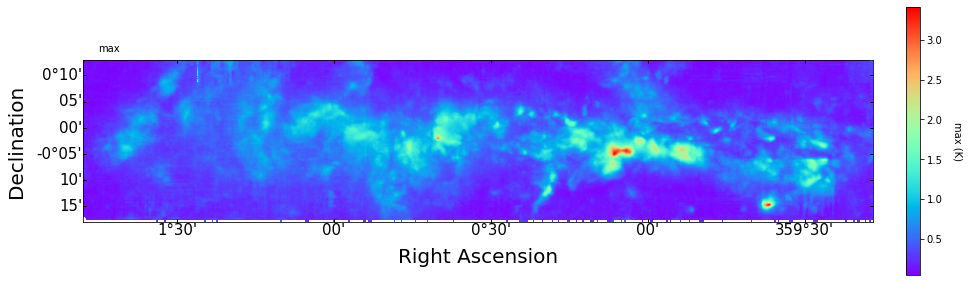

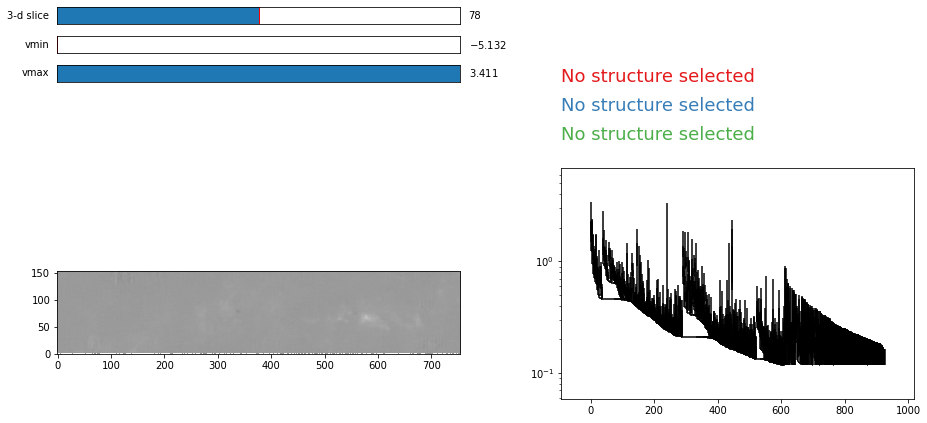

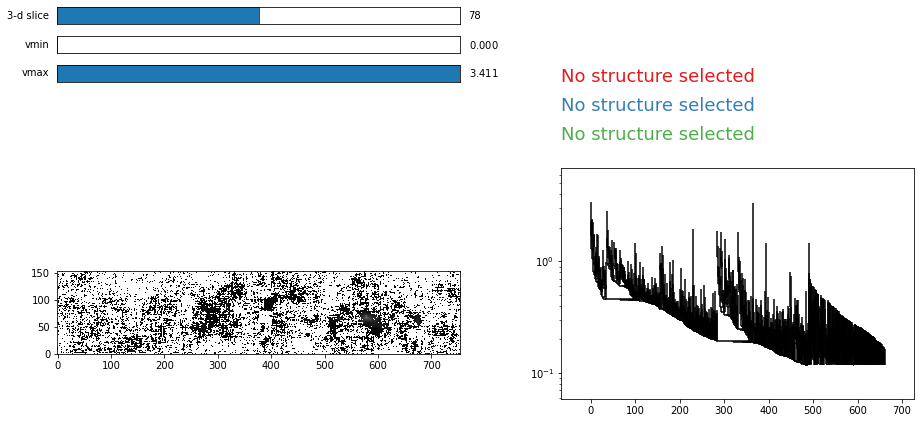

astrodendro: a =  5.407996805693086 +- 0.31457153573443686
b =  0.5695737532460469 +- 0.05198233261247846
Shetty eq: a =  3.5635747321202644 +- 0.3097686990063276
b =  0.5766008278058425 +- 0.048880499426458474
astrodendro, no abs: a =  5.405488314076426 +- 0.31298144743501344
b =  0.5697433056630399 +- 0.05180940456583109
Shetty eq, no abs: a =  3.5636860324820994 +- 0.3082756483699364
b =  0.5765515709871314 +- 0.048693495794270916


<Figure size 2160x2160 with 0 Axes>

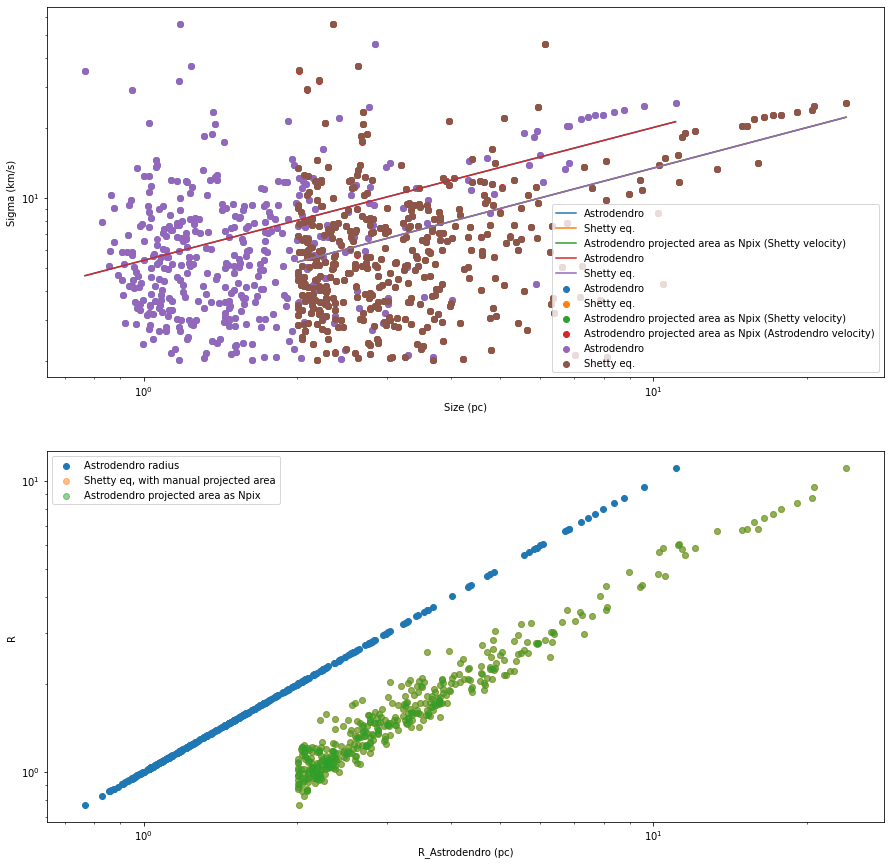

In [13]:
#HCOp

#print(I)
Num = 0
Overlaps=1
Ram_Limiter = 1
Name = "HCOp_1_0_Abs_CMZ"
name = "HCOp_1_0_CM_Contours_DS_10_Abs_CMZ.jpeg"
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
RNames = np.load("RNames_CMZ.npy")
SNames = np.load("SNames_CMZ.npy")
RNames[Num] = NameR
SNames[Num] = NameS
np.save("RNames_CMZ",RNames)
np.save("SNames_CMZ",SNames)
print(NameS)

print(NameS)

paths = pylab.array(['cmz_HCOp.cube.K-kms.pbcor.fits',
                     'cmz_HCN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13CN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13COp.cube.reproject.K-kms.pbcor.fits'])

#path = paths[Num]
path = 'CMZ_3mm_HCO+.fits'
print(path)

Noises = np.load('Noises_K_CMZ.npy')
AP = np.load('Absorption_Pixels_CMZ.npy')
m = Noises[Num]
#Make subcube
#Q = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)
Q = SpectralCube.read(path).downsample_axis(2,axis=0).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)
sc = Q.unmasked_copy()
#scQ = Q
scW = sc.wcs[:][:][0]

dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]

BP = np.where(AP>0)

dat_No_Abs=np.copy(dat)
dat_No_Abs[BP]=np.nan
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
#scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]

#No size reduction for now
scW = scn.wcs[:][:][0]
#scQW = scQn.wcs[:][:][0]

#Arap1 = SkyCoord('00d30m00s','-00d00m00s', frame='galactic')#These are away from the sources
#Arap2 = SkyCoord( '00d12m00s','-00d25m00s', frame='galactic')

Arap1= SkyCoord(l=.4*u.degree,b=-00.25*u.degree, frame='galactic')
Arap2= SkyCoord(l=.25*u.degree,b=-00.08*u.degree, frame='galactic')

AP1 = [int(scW.world_to_pixel(Arap1)[0]),int(scW.world_to_pixel(Arap1)[1])]
AP2 = [int(scW.world_to_pixel(Arap2)[0]),int(scW.world_to_pixel(Arap2)[1])]


#raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
#raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[5:np.shape(dat)[0]-5,5:np.shape(dat)[1]-5,5:np.shape(dat)[2]-5] # Make a subcube

datn_NA = dat_No_Abs[5:np.shape(dat)[0]-5,5:np.shape(dat)[1]-5,5:np.shape(dat)[2]-5] # Make a subcube
print(np.shape(datn))
scF = scn[5:np.shape(dat)[0]-5,5:np.shape(dat)[1]-5,5:np.shape(dat)[2]-5]
#scQF = scQn[5:np.shape(scQn)[0]-5,5:np.shape(scQn)[1]-5,5:np.shape(scQn)[2]-5]
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
#wcsQ = scQF.wcs[:][:][0]

header = scF.hdu.header
#print(header)
#make metadata for the dendrogram
metadata = {}
try:
    metadata['wavelength'] = header["RESTFREQ"]*u.Hz#
except:
    metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam

metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix

metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 


print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s

print(m,np.nanmean(datn),np.nanmax(datn))
#d = astrodendro.Dendrogram.compute(datn,min_delta= m*5,min_value = m*5,min_npix=4*2,wcs = scF.wcs) #The main culprit
d = astrodendro.Dendrogram.compute(datn,min_value=m*3,min_delta=m,min_npix=50,wcs = scF.wcs) #The main culprit

d_no_abs = astrodendro.Dendrogram.compute(datn_NA,min_value=m*3,min_delta=m,min_npix=50,wcs = scF.wcs) #The main culprit



fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map
vel,RA,Dec = scF.world[:,0,0]

ax3 = pylab.subplot(1,1,1,projection=wcs) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(scF.apply_numpy_function(np.nanmax,axis=0),cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.016,pad=0.04)                                     
cb.set_label(label='max (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='max',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  





#metadata["distance"] = 3.5*u.Mpc
vel,NA,na = sc.world[:,0,0]
##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()

v = d_no_abs.viewer()
v.show()
p=d_no_abs.plotter()

fig = plt.figure(2,figsize=(30,30))


radsL=np.array([])
radsB=np.array([])
sigmasL=np.array([])
sigmasB=np.array([])

radsL_Sh=np.array([])
radsB_Sh=np.array([])
sigmasL_Sh=np.array([])
sigmasB_Sh=np.array([])


radsL_ex=np.array([])
radsB_ex=np.array([])



center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
#print(center,wcs.world_to_pixel(center))
x,y = [wcs.world_to_pixel(center)[0],(wcs.world_to_pixel(center)[1])]
d0 = 7.2*10**-3*u.Mpc #mpc
for t in d.all_structures: 
    I = t.indices()
    Cont = True
    try:
        if(str(t.descendants[0]).find("branch") != -1):
            Cont = False #If we find a branch inside this structure t, then it is at least order two and will be discarded
    except:
        lop=12
    if(Cont):
        s = PPVStatistic(t,metadata=metadata)
        nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
        vel,RA,Dec = scF.world[:,0,0]
        v_IWM = np.nansum(datn[I]*vel[I[0]]/u.km*u.s)/np.nansum(datn[I])
        sig_Sh = np.sqrt(np.nansum(datn[I]*(vel[I[0]]/u.km*u.s-v_IWM)**2)/np.nansum(datn[I]))           
        #if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>3.24899981*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>1.5*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>np.sqrt(Bars[0])*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>2*u.km/u.s and s.radius<24/.83*2*u.pix and s.radius>3.24899981*u.pix):
        if(True):
            x_cent = s.x_cen/u.pix
            y_cent = s.y_cen/u.pix


            #Find distance to Earth Assuming it lies in the same plane as the center
            D_E = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((x_cent-x)**2+(y_cent-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )
            #print(D_E)5
            if(t.is_leaf):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6>2 and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                                                                                                                                                   
                    radsL=np.append(radsL,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



                    radsL_Sh=np.append(radsL_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does
                    sigmasL_Sh=np.append(sigmasL_Sh,(float(sig_Sh)))#

                    radsL_ex=np.append(radsL_ex,(float(np.sqrt(s.area_exact/u.pix**2*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does


            if(t.is_branch	):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6>2 and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                    radsB=np.append(radsB,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)


                    radsB_Sh=np.append(radsB_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi))))
                    sigmasB_Sh=np.append(sigmasB_Sh,(float(sig_Sh)))#

                    radsB_ex=np.append(radsB_ex,(float(np.sqrt(s.area_exact/u.pix**2*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does


radsLNA=np.array([])
radsBNA=np.array([])
sigmasLNA=np.array([])
sigmasBNA=np.array([])

radsL_ShNA=np.array([])
radsB_ShNA=np.array([])
sigmasL_ShNA=np.array([])
sigmasB_ShNA=np.array([])

for t in d_no_abs.all_structures: 
    I = t.indices()
    Cont = True
    try:
        if(str(t.descendants[0]).find("branch") != -1):
            Cont = False #If we find a branch inside this structure t, then it is at least order two and will be discarded
    except:
        lop=12
    if(Cont):
        s = PPVStatistic(t,metadata=metadata)
        nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
        vel,RA,Dec = scF.world[:,0,0]
        v_IWM = np.nansum(datn_NA[I]*vel[I[0]]/u.km*u.s)/np.nansum(datn_NA[I])
        sig_Sh = np.sqrt(np.nansum(datn_NA[I]*(vel[I[0]]/u.km*u.s-v_IWM)**2)/np.nansum(datn_NA[I]))           
        #if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>3.24899981*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>1.5*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>np.sqrt(Bars[0])*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>2*u.km/u.s and s.radius<24/.83*2*u.pix and s.radius>3.24899981*u.pix):
        if(True):
            x_cent = s.x_cen/u.pix
            y_cent = s.y_cen/u.pix

            
            #Find distance to Earth Assuming it lies in the same plane as the center
            D_E = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((x_cent-x)**2+(y_cent-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )
            #print(D_E)5
            if(t.is_leaf):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix/np.pi)))>np.sqrt(Bars[Num]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                                                                                                                                                   
                    radsLNA=np.append(radsL,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasLNA=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



                    radsL_ShNA=np.append(radsL_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does
                    sigmasL_ShNA=np.append(sigmasL_Sh,(float(sig_Sh)))#
            if(t.is_branch	):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix/np.pi)))>np.sqrt(Bars[Num]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                    radsBNA=np.append(radsB,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasBNA=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)


                    radsB_ShNA=np.append(radsB_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi))))
                    sigmasB_ShNA=np.append(sigmasB_Sh,(float(sig_Sh)))#
from scipy.optimize import curve_fit

def func(R,a,b):
    return a*R**(b)
  
Rcon = np.concatenate((radsL,radsB))
Scon = np.concatenate((sigmasL,sigmasB))

Rcon_Sh = np.concatenate((radsL_Sh,radsB_Sh))
Scon_Sh = np.concatenate((sigmasL_Sh,sigmasB_Sh))


RconNA = np.concatenate((radsLNA,radsBNA))
SconNA = np.concatenate((sigmasLNA,sigmasBNA))

Rcon_ShNA = np.concatenate((radsL_ShNA,radsB_ShNA))
Scon_ShNA = np.concatenate((sigmasL_ShNA,sigmasB_ShNA))




Rcon_ex = np.concatenate((radsL_ex,radsB_ex))

poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)

poptCon_Sh, pcovCon_Sh = curve_fit(func, Rcon_Sh*10**6, Scon_Sh)


poptConNA, pcovConNA = curve_fit(func, RconNA*10**6, SconNA)
poptCon_ShNA, pcovCon_ShNA = curve_fit(func, Rcon_ShNA*10**6, Scon_ShNA)


poptCon_Ex, pcovCon_Ex = curve_fit(func, Rcon_ex*10**6, Scon_Sh)

print("astrodendro: a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

print("Shetty eq: a = ",poptCon_Sh[0],"+-",np.sqrt(pcovCon_Sh[0][0]))
print("b = ",poptCon_Sh[1],"+-",np.sqrt(pcovCon_Sh[1][1]))


print("astrodendro, no abs: a = ",poptConNA[0],"+-",np.sqrt(pcovConNA[0][0]))
print("b = ",poptConNA[1],"+-",np.sqrt(pcovConNA[1][1]))

print("Shetty eq, no abs: a = ",poptCon_ShNA[0],"+-",np.sqrt(pcovCon_ShNA[0][0]))
print("b = ",poptCon_ShNA[1],"+-",np.sqrt(pcovCon_ShNA[1][1]))


fig = plt.figure(1,figsize=(15,15))
ax = pylab.subplot(2, 1, 1)
xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ys=func(xs,poptCon[0],poptCon[1])

xsSh=np.linspace(np.nanmin(Rcon_Sh*10**6),np.nanmax(Rcon_Sh*10**6),50)
ysSh=func(xsSh,poptCon_Sh[0],poptCon_Sh[1])



xsNA=np.linspace(np.nanmin(RconNA*10**6),np.nanmax(RconNA*10**6),50)
ysNA=func(xsNA,poptConNA[0],poptConNA[1])

xsShNA=np.linspace(np.nanmin(Rcon_ShNA*10**6),np.nanmax(Rcon_ShNA*10**6),50)
ysShNA=func(xsShNA,poptCon_ShNA[0],poptCon_ShNA[1])




xsShE=np.linspace(np.nanmin(Rcon_ex*10**6),np.nanmax(Rcon_ex*10**6),50)
ysShE=func(xsShE,poptCon_Ex[0],poptCon_Ex[1])

xpa, xpaSh, xpaExSh = ax.plot(xs,ys,label="Astrodendro"),ax.plot(xsSh,ysSh,label="Shetty eq."),ax.plot(xsShE,ysShE,label="Astrodendro projected area as Npix (Shetty velocity)")

xpaS, xpaShS,xpaSeXSH,xpaSeXAST = ax.scatter(Rcon*10**6,Scon,label="Astrodendro"),ax.scatter(Rcon_Sh*10**6,Scon_Sh,label="Shetty eq."),ax.scatter(Rcon_ex*10**6,Scon_Sh,label="Astrodendro projected area as Npix (Shetty velocity)"),ax.scatter(Rcon_ex*10**6,Scon,label="Astrodendro projected area as Npix (Astrodendro velocity)")



xpaNA, xpaShNA= ax.plot(xsNA,ysNA,label="Astrodendro"),ax.plot(xsShNA,ysShNA,label="Shetty eq.")

xpaSNA, xpaShSNA = ax.scatter(RconNA*10**6,SconNA,label="Astrodendro"),ax.scatter(Rcon_ShNA*10**6,Scon_ShNA,label="Shetty eq.")



ax2 = pylab.subplot(2,1,2)

xparast,xparS, xparShS = ax2.scatter(Rcon*10**6,Rcon*10**6,label="Astrodendro radius"),ax2.scatter(Rcon_Sh*10**6,Rcon*10**6,label="Shetty eq, with manual projected area",alpha=.5),ax2.scatter(Rcon_ex*10**6,Rcon*10**6,label="Astrodendro projected area as Npix",alpha=.5)

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Size (pc)")
ax.set_ylabel("Sigma (km/s)")

ax2.legend()
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel("R_Astrodendro (pc)")
ax2.set_ylabel("R")
pylab.show()



NameSL = (NameS+"_Leaves")
NameSB = (NameS+"_Branches")
NameRL = (NameR+"_Leaves")
NameRB = (NameR+"_Branches")

NameSLN = (NameS+"_Leaves_No_Abs")
NameSBN = (NameS+"_Branches_No_Abs")
NameRLN = (NameR+"_Leaves_No_Abs")
NameRBN = (NameR+"_Branches_No_Abs")



np.save(NameSL,sigmasL_Sh)
np.save(NameSB,sigmasB_Sh)
np.save(NameRL,radsL_Sh)
np.save(NameRB,radsB_Sh)


np.save(NameSLN,sigmasL_ShNA)
np.save(NameSBN,sigmasB_ShNA)
np.save(NameRLN,radsL_ShNA)
np.save(NameRBN,radsB_ShNA)

In [ ]:
#HCN


Num = 1
Overlaps=1
Ram_Limiter = 1
Name = "HCN_1_0_Abs_CMZ"
name = "HCN_1_0_CM_Contours_DS_10_Abs_CMZ.jpeg"
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
RNames[Num] = NameR
SNames[Num] = NameS
print(RNames)
np.save("RNames_CMZ",RNames)
np.save("SNames_CMZ",SNames)
print(NameS)

paths = pylab.array(['cmz_HCOp.cube.K-kms.pbcor.fits',
                     'cmz_HCN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13CN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13COp.cube.reproject.K-kms.pbcor.fits'])



#path = paths[Num]
path = 'CMZ_3mm_HCN.fits'
print(path)
Confidences = np.load('Confidence_data_CMZ.npy')
AP = np.load('Absorption_Pixels_CMZ.npy')
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path).downsample_axis(2,axis=0).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]

dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]

BP = np.where(AP>0)

dat_No_Abs=np.copy(dat)
dat_No_Abs[BP]=np.nan
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]

#No size reduction for now
scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]

#Arap1 = SkyCoord('00d30m00s','-00d00m00s', frame='galactic')#These are away from the sources
#Arap2 = SkyCoord( '00d12m00s','-00d25m00s', frame='galactic')

Arap1= SkyCoord(l=.4*u.degree,b=-00.25*u.degree, frame='galactic')
Arap2= SkyCoord(l=.25*u.degree,b=-00.08*u.degree, frame='galactic')

AP1 = [int(scW.world_to_pixel(Arap1)[0]),int(scW.world_to_pixel(Arap1)[1])]
AP2 = [int(scW.world_to_pixel(Arap2)[0]),int(scW.world_to_pixel(Arap2)[1])]


#raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
#raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[5:np.shape(dat)[0]-5,5:np.shape(dat)[1]-5,5:np.shape(dat)[2]-5] # Make a subcube

datn_NA = dat_No_Abs[5:np.shape(dat)[0]-5,5:np.shape(dat)[1]-5,5:np.shape(dat)[2]-5] # Make a subcube
#datn = dat[5:np.shape(dat)[0]-5,AP1[1]:AP2[1],AP1[0]:AP2[0]] # Make a subcube
#datn = dat[5:np.shape(dat)[0]-5,0:60,420:480] # Make a subcube
print(np.shape(datn))
scF = scn[5:np.shape(dat)[0]-5,5:np.shape(dat)[1]-5,5:np.shape(dat)[2]-5]
#scF = scn[5:np.shape(scn)[0]-5,AP1[1]:AP2[1],AP1[0]:AP2[0]]
#scF = scn[5:np.shape(dat)[0]-5,0:60,420:480] # Make a subcube
#scQF = scQn[5:np.shape(scQn)[0]-5,0:60,420:480] # Make a subcube
#scQF = scQn[5:np.shape(scQn)[0]-5,AP1[1]:AP2[1],AP1[0]:AP2[0]]
scQF = scQn[5:np.shape(scQn)[0]-5,5:np.shape(scQn)[1]-5,5:np.shape(scQn)[2]-5]
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

header = scQF.hdu.header
#print(header)
#make metadata for the dendrogram
metadata = {}
try:
    metadata['wavelength'] = header["RESTFREQ"]*u.Hz#
except:
    metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam

metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix

metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 


#print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s

print(m,np.nanmean(datn),np.nanmax(datn))
#d = astrodendro.Dendrogram.compute(datn,min_delta= m*5,min_value = m*5,min_npix=4*2,wcs = scF.wcs) #The main culprit
d = astrodendro.Dendrogram.compute(datn,min_npix=50,wcs = scQF.wcs) #The main culprit

d_no_abs = astrodendro.Dendrogram.compute(datn_NA,min_npix=50,wcs = scQF.wcs) #The main culprit



fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map
vel,RA,Dec = scF.world[:,0,0]

ax3 = pylab.subplot(1,1,1,projection=wcs) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(scF.apply_numpy_function(np.nanmax,axis=0),cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.016,pad=0.04)                                     
cb.set_label(label='max (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='max',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  





#metadata["distance"] = 3.5*u.Mpc
vel,NA,na = sc.world[:,0,0]
##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()

v = d_no_abs.viewer()
v.show()
p=d_no_abs.plotter()

fig = plt.figure(2,figsize=(30,30))

ds=40
SC_CM = scQF.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(3,10,n+1,projection=wcsU) # We plot them in a grid  
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*7)
    
    
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    
    beam = Circle(xy = (5,10),radius = np.sqrt(Bars[Num]),fill=True, alpha=.5,color="green")
    ax.add_patch(beam)
    ax55 = pylab.subplot(3,10,8,projection=wcsU) # We plot them in a grid 
    im55 = pylab.imshow(scQF.moment(order=2).hdu.data,cmap='rainbow')
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        Cont = True
        try:
            #print(str(t.descendants[0]).find("branch"))
            #print(str(t.descendants[0]))
            if(str(t.descendants[0]).find("branch") != -1):
                Cont = True#False #If we find a branch inside this structure t, then it is at least order two and will be discarded
        except:
            lop=12

        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            #if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>np.sqrt(NBars[1])*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 4):
            if((True)):
                #print(print(I))
                #for lmn in range(np.nanmax(I[0])-np.nanmin(I[0])):
                p.plot_contour(ax, structure=t, lw=.5, colors='red',alpha=.3,slice = int((np.nanmin(I[0])+np.nanmax(I[0]))/2))
                p.plot_contour(ax55, structure=t, lw=.5, colors='red',alpha=.3,slice = int((np.nanmin(I[0])+np.nanmax(I[0]))/2))



radsL=np.array([])
radsB=np.array([])
sigmasL=np.array([])
sigmasB=np.array([])

radsL_Sh=np.array([])
radsB_Sh=np.array([])
sigmasL_Sh=np.array([])
sigmasB_Sh=np.array([])


radsL_ex=np.array([])
radsB_ex=np.array([])



center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
print(center,wcs.world_to_pixel(center))
x,y = [wcs.world_to_pixel(center)[0],(wcs.world_to_pixel(center)[1])]
d0 = 7.2*10**-3*u.Mpc #mpc
for t in d.all_structures: 
    I = t.indices()
    Cont = True
    try:
        if(str(t.descendants[0]).find("branch") != -1):
            Cont = False #If we find a branch inside this structure t, then it is at least order two and will be discarded
    except:
        lop=12
    if(Cont):
        s = PPVStatistic(t,metadata=metadata)
        nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
        vel,RA,Dec = scF.world[:,0,0]
        v_IWM = np.nansum(datn[I]*vel[I[0]]/u.km*u.s)/np.nansum(datn[I])
        sig_Sh = np.sqrt(np.nansum(datn[I]*(vel[I[0]]/u.km*u.s-v_IWM)**2)/np.nansum(datn[I]))           
        #if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>3.24899981*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>1.5*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>np.sqrt(Bars[0])*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>2*u.km/u.s and s.radius<24/.83*2*u.pix and s.radius>3.24899981*u.pix):
        if(True):
            x_cent = s.x_cen/u.pix
            y_cent = s.y_cen/u.pix


            #Find distance to Earth Assuming it lies in the same plane as the center
            D_E = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((x_cent-x)**2+(y_cent-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )
            #print(D_E)5
            if(t.is_leaf):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix**2/np.pi)))>np.sqrt(Bars[0]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                                                                                                                                                   
                    radsL=np.append(radsL,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



                    radsL_Sh=np.append(radsL_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does
                    sigmasL_Sh=np.append(sigmasL_Sh,(float(sig_Sh)))#

                    radsL_ex=np.append(radsL_ex,(float(np.sqrt(s.area_exact/u.pix**2*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does


            if(t.is_branch	):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix**2/np.pi)))>np.sqrt(Bars[0]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                    radsB=np.append(radsB,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)


                    radsB_Sh=np.append(radsB_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi))))
                    sigmasB_Sh=np.append(sigmasB_Sh,(float(sig_Sh)))#

                    radsB_ex=np.append(radsB_ex,(float(np.sqrt(s.area_exact/u.pix**2*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does


radsLNA=np.array([])
radsBNA=np.array([])
sigmasLNA=np.array([])
sigmasBNA=np.array([])

radsL_ShNA=np.array([])
radsB_ShNA=np.array([])
sigmasL_ShNA=np.array([])
sigmasB_ShNA=np.array([])

for t in d_no_abs.all_structures: 
    I = t.indices()
    Cont = True
    try:
        if(str(t.descendants[0]).find("branch") != -1):
            Cont = False #If we find a branch inside this structure t, then it is at least order two and will be discarded
    except:
        lop=12
    if(Cont):
        s = PPVStatistic(t,metadata=metadata)
        nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
        vel,RA,Dec = scF.world[:,0,0]
        v_IWM = np.nansum(datn_NA[I]*vel[I[0]]/u.km*u.s)/np.nansum(datn_NA[I])
        sig_Sh = np.sqrt(np.nansum(datn_NA[I]*(vel[I[0]]/u.km*u.s-v_IWM)**2)/np.nansum(datn_NA[I]))           
        #if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>3.24899981*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>1.5*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>np.sqrt(Bars[0])*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>2*u.km/u.s and s.radius<24/.83*2*u.pix and s.radius>3.24899981*u.pix):
        if(True):
            x_cent = s.x_cen/u.pix
            y_cent = s.y_cen/u.pix


            #Find distance to Earth Assuming it lies in the same plane as the center
            D_E = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((x_cent-x)**2+(y_cent-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )
            #print(D_E)5
            if(t.is_leaf):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix*2/np.pi)))>np.sqrt(Bars[Num]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                                                                                                                                                   
                    radsLNA=np.append(radsL,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasLNA=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



                    radsL_ShNA=np.append(radsL_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does
                    sigmasL_ShNA=np.append(sigmasL_Sh,(float(sig_Sh)))#
            if(t.is_branch	):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix*2/np.pi)))>np.sqrt(Bars[Num]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                    radsBNA=np.append(radsB,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasBNA=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)


                    radsB_ShNA=np.append(radsB_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi))))
                    sigmasB_ShNA=np.append(sigmasB_Sh,(float(sig_Sh)))#

from scipy.optimize import curve_fit

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, radsL*10**6, sigmasL)
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func, radsB*10**6, sigmasB)
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
    
Rcon = np.concatenate((radsL,radsB))
Scon = np.concatenate((sigmasL,sigmasB))

poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
try:
    print(popt,pcov,"leaves:")
    print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
    print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
    print(poptB,pcovB,"branches:")
    print("a = ",poptB[0],"+-",np.sqrt(pcovB[0][0]))
    print("b = ",poptB[1],"+-",np.sqrt(pcovB[1][1]))
    print(poptCon,pcovCon,"All_structures:")
    print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
    print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

    fig = plt.figure()
    ax = pylab.subplot(2, 1, 1)
    xpL,xpB = ax.scatter(radsL*10**6,sigmasL),ax.scatter(radsB*10**6,sigmasB)
    xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
    ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])
    xpa1,xpa2,xpaTot = ax.plot(xs,ysL),ax.plot(xs,ysB),ax.plot(xs,ysCon)
    plt.xlabel("Size (pc)")
    plt.ylabel("Sigma (km/s)")
    pylab.show()
    ax2 = pylab.subplot(2, 1, 2)
    xpL,xpB = ax2.scatter(radsL*10**6,sigmasL),ax2.scatter(radsB*10**6,sigmasB)
    p,p2,p3 = ax2.plot(xs,ysL),ax2.plot(xs,ysB),ax2.plot(xs,ysCon)
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    plt.xlabel("Size (pc)")
    plt.ylabel("Sigma (km/s)")
    pylab.show()

except:
    
    print("Not Enough Well-Defined Structures")
NameSL = (NameS+"_Leaves")
NameSB = (NameS+"_Branches")
NameRL = (NameR+"_Leaves")
NameRB = (NameR+"_Branches")

np.save(NameSL,sigmasL)
np.save(NameSB,sigmasB)
np.save(NameRL,radsL)
np.save(NameRB,radsB)

In [ ]:
#H13CN


Num = 2
Overlaps=1
Ram_Limiter = 1
Name = "H13CN_1_0_Abs_CMZ"
name = "H13CN_1_0_CM_Contours_DS_10_Abs_CMZ.jpeg"
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
RNames[Num] = NameR
SNames[Num] = NameS

np.save("RNames_CMZ",RNames)
np.save("SNames_CMZ",SNames)
print(NameS)

paths = pylab.array(['cmz_HCOp.cube.K-kms.pbcor.fits',
                     'cmz_HCN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13CN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13COp.cube.reproject.K-kms.pbcor.fits'])



path = paths[Num]
print(path)
Confidences = np.load('Confidence_data_CMZ.npy')
H13CN_MASK = np.load('H13CN_MASK.npy')

Noises = np.load('Noises_K_CMZ.npy')
AP = np.load('Absorption_Pixels_CMZ.npy')
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path).downsample_axis(2,axis=0).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]

dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]

BP = np.where(AP>0)

dat_No_Abs=np.copy(dat)
dat_No_Abs[BP]=np.nan
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]

#No size reduction for now
scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]

#Arap1 = SkyCoord('00d30m00s','-00d00m00s', frame='galactic')#These are away from the sources
#Arap2 = SkyCoord( '00d12m00s','-00d25m00s', frame='galactic')

Arap1= SkyCoord(l=.4*u.degree,b=-00.25*u.degree, frame='galactic')
Arap2= SkyCoord(l=.25*u.degree,b=-00.08*u.degree, frame='galactic')

AP1 = [int(scW.world_to_pixel(Arap1)[0]),int(scW.world_to_pixel(Arap1)[1])]
AP2 = [int(scW.world_to_pixel(Arap2)[0]),int(scW.world_to_pixel(Arap2)[1])]


#raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
#raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[5:np.shape(dat)[0]-5,5:np.shape(dat)[1]-5,5:np.shape(dat)[2]-5] # Make a subcube

datn_NA = dat_No_Abs[5:np.shape(dat)[0]-5,5:np.shape(dat)[1]-5,5:np.shape(dat)[2]-5] # Make a subcube
#datn = dat[5:np.shape(dat)[0]-5,AP1[1]:AP2[1],AP1[0]:AP2[0]] # Make a subcube
#datn = dat[5:np.shape(dat)[0]-5,0:60,420:480] # Make a subcube
print(np.shape(datn))
scF = scn[5:np.shape(dat)[0]-5,5:np.shape(dat)[1]-5,5:np.shape(dat)[2]-5]
#scF = scn[5:np.shape(scn)[0]-5,AP1[1]:AP2[1],AP1[0]:AP2[0]]
#scF = scn[5:np.shape(dat)[0]-5,0:60,420:480] # Make a subcube
#scQF = scQn[5:np.shape(scQn)[0]-5,0:60,420:480] # Make a subcube
#scQF = scQn[5:np.shape(scQn)[0]-5,AP1[1]:AP2[1],AP1[0]:AP2[0]]
scQF = scQn[5:np.shape(scQn)[0]-5,5:np.shape(scQn)[1]-5,5:np.shape(scQn)[2]-5]
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

header = scQF.hdu.header
#print(header)
#make metadata for the dendrogram
metadata = {}
try:
    metadata['wavelength'] = header["RESTFREQ"]*u.Hz#
except:
    metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam

metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix

metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 


#print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s

print(m,np.nanmean(datn),np.nanmax(datn))
#d = astrodendro.Dendrogram.compute(datn,min_delta= m*5,min_value = m*5,min_npix=4*2,wcs = scF.wcs) #The main culprit
d = astrodendro.Dendrogram.compute(datn,min_npix=50,wcs = scQF.wcs) #The main culprit

d_no_abs = astrodendro.Dendrogram.compute(datn_NA,min_npix=50,wcs = scQF.wcs) #The main culprit



fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map
vel,RA,Dec = scF.world[:,0,0]

ax3 = pylab.subplot(1,1,1,projection=wcs) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(scF.apply_numpy_function(np.nanmax,axis=0),cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.016,pad=0.04)                                     
cb.set_label(label='max (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='max',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  





#metadata["distance"] = 3.5*u.Mpc
vel,NA,na = sc.world[:,0,0]
##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()

v = d_no_abs.viewer()
v.show()
p=d_no_abs.plotter()

fig = plt.figure(2,figsize=(30,30))

ds=40
SC_CM = scQF.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(3,10,n+1,projection=wcsU) # We plot them in a grid  
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*7)
    
    
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    
    beam = Circle(xy = (5,10),radius = np.sqrt(Bars[Num]),fill=True, alpha=.5,color="green")
    ax.add_patch(beam)
    ax55 = pylab.subplot(3,10,8,projection=wcsU) # We plot them in a grid 
    im55 = pylab.imshow(scQF.moment(order=2).hdu.data,cmap='rainbow')
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        Cont = True
        try:
            #print(str(t.descendants[0]).find("branch"))
            #print(str(t.descendants[0]))
            if(str(t.descendants[0]).find("branch") != -1):
                Cont = True#False #If we find a branch inside this structure t, then it is at least order two and will be discarded
        except:
            lop=12

        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            #if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>np.sqrt(NBars[1])*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 4):
            if((True)):
                #print(print(I))
                #for lmn in range(np.nanmax(I[0])-np.nanmin(I[0])):
                p.plot_contour(ax, structure=t, lw=.5, colors='red',alpha=.3,slice = int((np.nanmin(I[0])+np.nanmax(I[0]))/2))
                p.plot_contour(ax55, structure=t, lw=.5, colors='red',alpha=.3,slice = int((np.nanmin(I[0])+np.nanmax(I[0]))/2))



radsL=np.array([])
radsB=np.array([])
sigmasL=np.array([])
sigmasB=np.array([])

radsL_Sh=np.array([])
radsB_Sh=np.array([])
sigmasL_Sh=np.array([])
sigmasB_Sh=np.array([])


radsL_ex=np.array([])
radsB_ex=np.array([])



center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
print(center,wcs.world_to_pixel(center))
x,y = [wcs.world_to_pixel(center)[0],(wcs.world_to_pixel(center)[1])]
d0 = 7.2*10**-3*u.Mpc #mpc
for t in d.all_structures: 
    I = t.indices()
    Cont = True
    try:
        if(str(t.descendants[0]).find("branch") != -1):
            Cont = False #If we find a branch inside this structure t, then it is at least order two and will be discarded
    except:
        lop=12
    if(Cont):
        s = PPVStatistic(t,metadata=metadata)
        nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
        vel,RA,Dec = scF.world[:,0,0]
        v_IWM = np.nansum(datn[I]*vel[I[0]]/u.km*u.s)/np.nansum(datn[I])
        sig_Sh = np.sqrt(np.nansum(datn[I]*(vel[I[0]]/u.km*u.s-v_IWM)**2)/np.nansum(datn[I]))           
        #if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>3.24899981*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>1.5*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>np.sqrt(Bars[0])*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>2*u.km/u.s and s.radius<24/.83*2*u.pix and s.radius>3.24899981*u.pix):
        if(True):
            x_cent = s.x_cen/u.pix
            y_cent = s.y_cen/u.pix


            #Find distance to Earth Assuming it lies in the same plane as the center
            D_E = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((x_cent-x)**2+(y_cent-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )
            #print(D_E)5
            if(t.is_leaf):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix**2/np.pi)))>np.sqrt(Bars[0]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                                                                                                                                                   
                    radsL=np.append(radsL,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



                    radsL_Sh=np.append(radsL_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does
                    sigmasL_Sh=np.append(sigmasL_Sh,(float(sig_Sh)))#

                    radsL_ex=np.append(radsL_ex,(float(np.sqrt(s.area_exact/u.pix**2*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does


            if(t.is_branch	):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix**2/np.pi)))>np.sqrt(Bars[0]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                    radsB=np.append(radsB,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)


                    radsB_Sh=np.append(radsB_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi))))
                    sigmasB_Sh=np.append(sigmasB_Sh,(float(sig_Sh)))#

                    radsB_ex=np.append(radsB_ex,(float(np.sqrt(s.area_exact/u.pix**2*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does


radsLNA=np.array([])
radsBNA=np.array([])
sigmasLNA=np.array([])
sigmasBNA=np.array([])

radsL_ShNA=np.array([])
radsB_ShNA=np.array([])
sigmasL_ShNA=np.array([])
sigmasB_ShNA=np.array([])

for t in d_no_abs.all_structures: 
    I = t.indices()
    Cont = True
    try:
        if(str(t.descendants[0]).find("branch") != -1):
            Cont = False #If we find a branch inside this structure t, then it is at least order two and will be discarded
    except:
        lop=12
    if(Cont):
        s = PPVStatistic(t,metadata=metadata)
        nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
        vel,RA,Dec = scF.world[:,0,0]
        v_IWM = np.nansum(datn_NA[I]*vel[I[0]]/u.km*u.s)/np.nansum(datn_NA[I])
        sig_Sh = np.sqrt(np.nansum(datn_NA[I]*(vel[I[0]]/u.km*u.s-v_IWM)**2)/np.nansum(datn_NA[I]))           
        #if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>3.24899981*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>1.5*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>np.sqrt(Bars[0])*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>2*u.km/u.s and s.radius<24/.83*2*u.pix and s.radius>3.24899981*u.pix):
        if(True):
            x_cent = s.x_cen/u.pix
            y_cent = s.y_cen/u.pix


            #Find distance to Earth Assuming it lies in the same plane as the center
            D_E = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((x_cent-x)**2+(y_cent-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )
            #print(D_E)5
            if(t.is_leaf):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix*2/np.pi)))>np.sqrt(Bars[Num]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                                                                                                                                                   
                    radsLNA=np.append(radsL,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasLNA=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



                    radsL_ShNA=np.append(radsL_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does
                    sigmasL_ShNA=np.append(sigmasL_Sh,(float(sig_Sh)))#
            if(t.is_branch	):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix*2/np.pi)))>np.sqrt(Bars[Num]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                    radsBNA=np.append(radsB,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasBNA=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)


                    radsB_ShNA=np.append(radsB_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi))))
                    sigmasB_ShNA=np.append(sigmasB_Sh,(float(sig_Sh)))#
from scipy.optimize import curve_fit

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, radsL*10**6, sigmasL)
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func, radsB*10**6, sigmasB)
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
    
Rcon = np.concatenate((radsL,radsB))
Scon = np.concatenate((sigmasL,sigmasB))

poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
try:
    print(popt,pcov,"leaves:")
    print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
    print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
    print(poptB,pcovB,"branches:")
    print("a = ",poptB[0],"+-",np.sqrt(pcovB[0][0]))
    print("b = ",poptB[1],"+-",np.sqrt(pcovB[1][1]))
    print(poptCon,pcovCon,"All_structures:")
    print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
    print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

    fig = plt.figure()
    ax = pylab.subplot(2, 1, 1)
    xpL,xpB = ax.scatter(radsL*10**6,sigmasL),ax.scatter(radsB*10**6,sigmasB)
    xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
    ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])
    xpa1,xpa2,xpaTot = ax.plot(xs,ysL),ax.plot(xs,ysB),ax.plot(xs,ysCon)
    plt.xlabel("Size (pc)")
    plt.ylabel("Sigma (km/s)")
    pylab.show()
    ax2 = pylab.subplot(2, 1, 2)
    xpL,xpB = ax2.scatter(radsL*10**6,sigmasL),ax2.scatter(radsB*10**6,sigmasB)
    p,p2,p3 = ax2.plot(xs,ysL),ax2.plot(xs,ysB),ax2.plot(xs,ysCon)
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    plt.xlabel("Size (pc)")
    plt.ylabel("Sigma (km/s)")
    pylab.show()

except:
    
    print("Not Enough Well-Defined Structures")
NameSL = (NameS+"_Leaves")
NameSB = (NameS+"_Branches")
NameRL = (NameR+"_Leaves")
NameRB = (NameR+"_Branches")

np.save(NameSL,sigmasL)
np.save(NameSB,sigmasB)
np.save(NameRL,radsL)
np.save(NameRB,radsB)

In [ ]:
#H13CoP


Num = 3
Overlaps=1
Ram_Limiter = 1
Name = "H13CoP_1_0_Abs_CMZ"
name = "H13CoP_1_0_CM_Contours_DS_10_Abs_CMZ.jpeg"
NameS = (Name+"Sig")
NameR = (Name+"Rad")
RNames = np.load("RNames_CMZ.npy")
SNames = np.load("SNames_CMZ.npy")
RNames[Num] = "H13CoP_1_0_Abs_CMZRad"
SNames[Num] = "H13CoP_1_0_Abs_CMZSig"
print(RNames[Num],NameR)
np.save("RNames_CMZ",RNames)
np.save("SNames_CMZ",SNames)
print(NameS)

paths = pylab.array(['cmz_HCOp.cube.K-kms.pbcor.fits',
                     'cmz_HCN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13CN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13COp.cube.reproject.K-kms.pbcor.fits'])

path = paths[Num]
#path = 'CMZ_3mm_HCN.fits'
print(path)

Noises = np.load('Noises_K_CMZ.npy')
AP = np.load('Absorption_Pixels_CMZ.npy')
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path).downsample_axis(2,axis=0).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]

dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]

BP = np.where(AP>0)

dat_No_Abs=np.copy(dat)
dat_No_Abs[BP]=np.nan
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]

#No size reduction for now
scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]

#Arap1 = SkyCoord('00d30m00s','-00d00m00s', frame='galactic')#These are away from the sources
#Arap2 = SkyCoord( '00d12m00s','-00d25m00s', frame='galactic')

Arap1= SkyCoord(l=.4*u.degree,b=-00.25*u.degree, frame='galactic')
Arap2= SkyCoord(l=.25*u.degree,b=-00.08*u.degree, frame='galactic')

AP1 = [int(scW.world_to_pixel(Arap1)[0]),int(scW.world_to_pixel(Arap1)[1])]
AP2 = [int(scW.world_to_pixel(Arap2)[0]),int(scW.world_to_pixel(Arap2)[1])]


#raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
#raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[5:np.shape(dat)[0]-5,5:np.shape(dat)[1]-5,5:np.shape(dat)[2]-5] # Make a subcube

datn_NA = dat_No_Abs[5:np.shape(dat)[0]-5,5:np.shape(dat)[1]-5,5:np.shape(dat)[2]-5] # Make a subcube
#datn = dat[5:np.shape(dat)[0]-5,AP1[1]:AP2[1],AP1[0]:AP2[0]] # Make a subcube
#datn = dat[5:np.shape(dat)[0]-5,0:60,420:480] # Make a subcube
print(np.shape(datn))
scF = scn[5:np.shape(dat)[0]-5,5:np.shape(dat)[1]-5,5:np.shape(dat)[2]-5]
#scF = scn[5:np.shape(scn)[0]-5,AP1[1]:AP2[1],AP1[0]:AP2[0]]
#scF = scn[5:np.shape(dat)[0]-5,0:60,420:480] # Make a subcube
#scQF = scQn[5:np.shape(scQn)[0]-5,0:60,420:480] # Make a subcube
#scQF = scQn[5:np.shape(scQn)[0]-5,AP1[1]:AP2[1],AP1[0]:AP2[0]]
scQF = scQn[5:np.shape(scQn)[0]-5,5:np.shape(scQn)[1]-5,5:np.shape(scQn)[2]-5]
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

header = scQF.hdu.header
#print(header)
#make metadata for the dendrogram
metadata = {}
try:
    metadata['wavelength'] = header["RESTFREQ"]*u.Hz#
except:
    metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam

metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix

metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 


#print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s

print(m,np.nanmean(datn),np.nanmax(datn))
#d = astrodendro.Dendrogram.compute(datn,min_delta= m*5,min_value = m*5,min_npix=4*2,wcs = scF.wcs) #The main culprit
d = astrodendro.Dendrogram.compute(datn,min_npix=50,wcs = scQF.wcs) #The main culprit

d_no_abs = astrodendro.Dendrogram.compute(datn_NA,min_npix=50,wcs = scQF.wcs) #The main culprit



fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map
vel,RA,Dec = scF.world[:,0,0]

ax3 = pylab.subplot(1,1,1,projection=wcs) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(scF.apply_numpy_function(np.nanmax,axis=0),cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.016,pad=0.04)                                     
cb.set_label(label='max (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='max',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  





#metadata["distance"] = 3.5*u.Mpc
vel,NA,na = sc.world[:,0,0]
##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()

v = d_no_abs.viewer()
v.show()
p=d_no_abs.plotter()

fig = plt.figure(2,figsize=(30,30))

ds=40
SC_CM = scQF.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(3,10,n+1,projection=wcsU) # We plot them in a grid  
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*7)
    
    
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    
    beam = Circle(xy = (5,10),radius = np.sqrt(Bars[Num]),fill=True, alpha=.5,color="green")
    ax.add_patch(beam)
    ax55 = pylab.subplot(3,10,8,projection=wcsU) # We plot them in a grid 
    im55 = pylab.imshow(scQF.moment(order=2).hdu.data,cmap='rainbow')
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        Cont = True
        try:
            #print(str(t.descendants[0]).find("branch"))
            #print(str(t.descendants[0]))
            if(str(t.descendants[0]).find("branch") != -1):
                Cont = True#False #If we find a branch inside this structure t, then it is at least order two and will be discarded
        except:
            lop=12

        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            #if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>np.sqrt(NBars[1])*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 4):
            if((True)):
                #print(print(I))
                #for lmn in range(np.nanmax(I[0])-np.nanmin(I[0])):
                p.plot_contour(ax, structure=t, lw=.5, colors='red',alpha=.3,slice = int((np.nanmin(I[0])+np.nanmax(I[0]))/2))
                p.plot_contour(ax55, structure=t, lw=.5, colors='red',alpha=.3,slice = int((np.nanmin(I[0])+np.nanmax(I[0]))/2))



radsL=np.array([])
radsB=np.array([])
sigmasL=np.array([])
sigmasB=np.array([])

radsL_Sh=np.array([])
radsB_Sh=np.array([])
sigmasL_Sh=np.array([])
sigmasB_Sh=np.array([])


radsL_ex=np.array([])
radsB_ex=np.array([])



center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
print(center,wcs.world_to_pixel(center))
x,y = [wcs.world_to_pixel(center)[0],(wcs.world_to_pixel(center)[1])]
d0 = 7.2*10**-3*u.Mpc #mpc
for t in d.all_structures: 
    I = t.indices()
    Cont = True
    try:
        if(str(t.descendants[0]).find("branch") != -1):
            Cont = False #If we find a branch inside this structure t, then it is at least order two and will be discarded
    except:
        lop=12
    if(Cont):
        s = PPVStatistic(t,metadata=metadata)
        nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
        vel,RA,Dec = scF.world[:,0,0]
        v_IWM = np.nansum(datn[I]*vel[I[0]]/u.km*u.s)/np.nansum(datn[I])
        sig_Sh = np.sqrt(np.nansum(datn[I]*(vel[I[0]]/u.km*u.s-v_IWM)**2)/np.nansum(datn[I]))           
        #if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>3.24899981*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>1.5*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>np.sqrt(Bars[0])*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>2*u.km/u.s and s.radius<24/.83*2*u.pix and s.radius>3.24899981*u.pix):
        if(True):
            x_cent = s.x_cen/u.pix
            y_cent = s.y_cen/u.pix


            #Find distance to Earth Assuming it lies in the same plane as the center
            D_E = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((x_cent-x)**2+(y_cent-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )
            #print(D_E)5
            if(t.is_leaf):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix**2/np.pi)))>np.sqrt(Bars[0]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                                                                                                                                                   
                    radsL=np.append(radsL,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



                    radsL_Sh=np.append(radsL_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does
                    sigmasL_Sh=np.append(sigmasL_Sh,(float(sig_Sh)))#

                    radsL_ex=np.append(radsL_ex,(float(np.sqrt(s.area_exact/u.pix**2*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does


            if(t.is_branch	):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix**2/np.pi)))>np.sqrt(Bars[0]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                    radsB=np.append(radsB,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)


                    radsB_Sh=np.append(radsB_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi))))
                    sigmasB_Sh=np.append(sigmasB_Sh,(float(sig_Sh)))#

                    radsB_ex=np.append(radsB_ex,(float(np.sqrt(s.area_exact/u.pix**2*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does


radsLNA=np.array([])
radsBNA=np.array([])
sigmasLNA=np.array([])
sigmasBNA=np.array([])

radsL_ShNA=np.array([])
radsB_ShNA=np.array([])
sigmasL_ShNA=np.array([])
sigmasB_ShNA=np.array([])

for t in d_no_abs.all_structures: 
    I = t.indices()
    Cont = True
    try:
        if(str(t.descendants[0]).find("branch") != -1):
            Cont = False #If we find a branch inside this structure t, then it is at least order two and will be discarded
    except:
        lop=12
    if(Cont):
        s = PPVStatistic(t,metadata=metadata)
        nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
        vel,RA,Dec = scF.world[:,0,0]
        v_IWM = np.nansum(datn_NA[I]*vel[I[0]]/u.km*u.s)/np.nansum(datn_NA[I])
        sig_Sh = np.sqrt(np.nansum(datn_NA[I]*(vel[I[0]]/u.km*u.s-v_IWM)**2)/np.nansum(datn_NA[I]))           
        #if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>3.24899981*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>1.5*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>np.sqrt(Bars[0])*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>2*u.km/u.s and s.radius<24/.83*2*u.pix and s.radius>3.24899981*u.pix):
        if(True):
            x_cent = s.x_cen/u.pix
            y_cent = s.y_cen/u.pix


            #Find distance to Earth Assuming it lies in the same plane as the center
            D_E = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((x_cent-x)**2+(y_cent-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )
            #print(D_E)5
            if(t.is_leaf):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix*2/np.pi)))>np.sqrt(Bars[Num]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                                                                                                                                                   
                    radsLNA=np.append(radsL,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasLNA=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



                    radsL_ShNA=np.append(radsL_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does
                    sigmasL_ShNA=np.append(sigmasL_Sh,(float(sig_Sh)))#
            if(t.is_branch	):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix*2/np.pi)))>np.sqrt(Bars[Num]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                    radsBNA=np.append(radsB,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasBNA=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)


                    radsB_ShNA=np.append(radsB_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi))))
                    sigmasB_ShNA=np.append(sigmasB_Sh,(float(sig_Sh)))#
                    
from scipy.optimize import curve_fit

def func(R,a,b):
    return a*R**(b)
  
Rcon = np.concatenate((radsL,radsB))
Scon = np.concatenate((sigmasL,sigmasB))

Rcon_Sh = np.concatenate((radsL_Sh,radsB_Sh))
Scon_Sh = np.concatenate((sigmasL_Sh,sigmasB_Sh))


RconNA = np.concatenate((radsLNA,radsBNA))
SconNA = np.concatenate((sigmasLNA,sigmasBNA))

Rcon_ShNA = np.concatenate((radsL_ShNA,radsB_ShNA))
Scon_ShNA = np.concatenate((sigmasL_ShNA,sigmasB_ShNA))




Rcon_ex = np.concatenate((radsL_ex,radsB_ex))

poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)

poptCon_Sh, pcovCon_Sh = curve_fit(func, Rcon_Sh*10**6, Scon_Sh)


poptConNA, pcovConNA = curve_fit(func, RconNA*10**6, SconNA)
poptCon_ShNA, pcovCon_ShNA = curve_fit(func, Rcon_ShNA*10**6, Scon_ShNA)


poptCon_Ex, pcovCon_Ex = curve_fit(func, Rcon_ex*10**6, Scon_Sh)

print("astrodendro: a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

print("Shetty eq: a = ",poptCon_Sh[0],"+-",np.sqrt(pcovCon_Sh[0][0]))
print("b = ",poptCon_Sh[1],"+-",np.sqrt(pcovCon_Sh[1][1]))


print("astrodendro, no abs: a = ",poptConNA[0],"+-",np.sqrt(pcovConNA[0][0]))
print("b = ",poptConNA[1],"+-",np.sqrt(pcovConNA[1][1]))

print("Shetty eq, no abs: a = ",poptCon_ShNA[0],"+-",np.sqrt(pcovCon_ShNA[0][0]))
print("b = ",poptCon_ShNA[1],"+-",np.sqrt(pcovCon_ShNA[1][1]))


fig = plt.figure(1,figsize=(15,15))
ax = pylab.subplot(2, 1, 1)
xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ys=func(xs,poptCon[0],poptCon[1])

xsSh=np.linspace(np.nanmin(Rcon_Sh*10**6),np.nanmax(Rcon_Sh*10**6),50)
ysSh=func(xsSh,poptCon_Sh[0],poptCon_Sh[1])



xsNA=np.linspace(np.nanmin(RconNA*10**6),np.nanmax(RconNA*10**6),50)
ysNA=func(xsNA,poptConNA[0],poptConNA[1])

xsShNA=np.linspace(np.nanmin(Rcon_ShNA*10**6),np.nanmax(Rcon_ShNA*10**6),50)
ysShNA=func(xsShNA,poptCon_ShNA[0],poptCon_ShNA[1])




xsShE=np.linspace(np.nanmin(Rcon_ex*10**6),np.nanmax(Rcon_ex*10**6),50)
ysShE=func(xsShE,poptCon_Ex[0],poptCon_Ex[1])

xpa, xpaSh, xpaExSh = ax.plot(xs,ys,label="Astrodendro"),ax.plot(xsSh,ysSh,label="Shetty eq."),ax.plot(xsShE,ysShE,label="Astrodendro projected area as Npix (Shetty velocity)")

xpaS, xpaShS,xpaSeXSH,xpaSeXAST = ax.scatter(Rcon*10**6,Scon,label="Astrodendro"),ax.scatter(Rcon_Sh*10**6,Scon_Sh,label="Shetty eq."),ax.scatter(Rcon_ex*10**6,Scon_Sh,label="Astrodendro projected area as Npix (Shetty velocity)"),ax.scatter(Rcon_ex*10**6,Scon,label="Astrodendro projected area as Npix (Astrodendro velocity)")



xpaNA, xpaShNA= ax.plot(xsNA,ysNA,label="Astrodendro"),ax.plot(xsShNA,ysShNA,label="Shetty eq.")

xpaSNA, xpaShSNA = ax.scatter(RconNA*10**6,SconNA,label="Astrodendro"),ax.scatter(Rcon_ShNA*10**6,Scon_ShNA,label="Shetty eq.")



ax2 = pylab.subplot(2,1,2)

xparast,xparS, xparShS = ax2.scatter(Rcon*10**6,Rcon*10**6,label="Astrodendro radius"),ax2.scatter(Rcon_Sh*10**6,Rcon*10**6,label="Shetty eq, with manual projected area",alpha=.5),ax2.scatter(Rcon_ex*10**6,Rcon*10**6,label="Astrodendro projected area as Npix",alpha=.5)

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Size (pc)")
ax.set_ylabel("Sigma (km/s)")

ax2.legend()
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel("R_Astrodendro (pc)")
ax2.set_ylabel("R")
pylab.show()



NameSL = (NameS+"_Leaves")
NameSB = (NameS+"_Branches")
NameRL = (NameR+"_Leaves")
NameRB = (NameR+"_Branches")

NameSLN = (NameS+"_Leaves_No_Abs")
NameSBN = (NameS+"_Branches_No_Abs")
NameRLN = (NameR+"_Leaves_No_Abs")
NameRBN = (NameR+"_Branches_No_Abs")



np.save(NameSL,sigmasL_Sh)
np.save(NameSB,sigmasB_Sh)
np.save(NameRL,radsL_Sh)
np.save(NameRB,radsB_Sh)


np.save(NameSLN,sigmasL_ShNA)
np.save(NameSBN,sigmasB_ShNA)
np.save(NameRLN,radsL_ShNA)
np.save(NameRBN,radsB_ShNA)

In [11]:
RNames = np.load("RNames_CMZ.npy")
SNames = np.load("SNames_CMZ.npy")
CMZLs = ["HCO+_J1-0","HCN_J1-0","H13CN_J1-0","H13CO+_J1-0"]
NGCRNames = np.load("RNames.npy")
NGCSNames = np.load("SNames.npy")

#ONGCR = [NGCRNames[9],NGCRNames[10],NGCRNames[8]]
#ONGCS = [NGCSNames[9],NGCSNames[10],NGCSNames[8]] 4-3
ONGCR = [NGCRNames[0],NGCRNames[1],NGCRNames[2],NGCRNames[5]]
ONGCS = [NGCSNames[0],NGCSNames[1],NGCSNames[2],NGCSNames[5]] #1-0

Bars = np.load("CZM_Beam_Area_Ratios.npy")
NBars = np.load("NGC_Beam_Area_Ratios.npy")

SpecRes = np.load("CZM_Sres.npy")
NSpecRes = np.load("NGC_Sres.npy")

SpRes= np.load("CZM_Spres.npy")
NSpRes = np.load("NGC_Spres.npy")

print(ONGCR,ONGCS)
print(RNames,SNames)
#for i in range(len(RNames)):
fig = plt.figure(1,figsize=(35,35))


for i in range(4):
    #make minimum space line
    
    ysp=SpecRes[i]
    xsp=SpRes[i]
    Nysp=NSpecRes[i]
    Nxsp=NSpRes[i]
    
    
    #def space(v,*args):
    #    r,bar,vres,sres = args[0],args[1],args[2],args[3]
    #    return  float(50*vres*sres**2/np.sqrt(50))-v*r**2*np.pi
    def MinSpace(*args):
        r,vres,sres = args[0],args[1],args[2]
        if (math.floor(1/sres**2*r**2*np.pi)==0):
            return np.nan
        else:

            vp = math.ceil(50/math.floor(1/sres**2*r**2*np.pi)) #minimum number of velocity channels the structures must be in

            DumCube = np.array([]) #make a cube that would have the minimum rms possible
            for i in range(vp):
                for n in range(math.floor(1/sres**2*r**2*np.pi)):
                    DumCube = np.append(DumCube,i*vres)
            rms = np.std(DumCube)**2 #The rms is the variance of this 'cube'

            return rms

    
        
    xsps=[]

    ysps=[]

    line=[]
    minsigs=[]
    Nxsps=[]

    Nysps=[]

    
    Nminsigs=[]
    zeros=[]
    
    rs=np.linspace(0.1,5,10)
    L=np.linspace(-1,20,10)
    for t in range(10):
        ps = 0
        xsps.append(xsp*2.075)
        ysps.append(ysp)
        
        Nxsps.append(Nxsp)
        Nysps.append(Nysp)
        
        #print(scipy.optimize.fsolve(space,x0=-100,factor=1,xtol=10**-20,args=(rs[t],NBars[i],SpecRes[i],SpRes[i]),full_output=True,maxfev=10000))
        #print(float(scipy.optimize.fsolve(space,x0=-100,factor=1,xtol=10**-20,args=(rs[t],NBars[i],SpecRes[i],SpRes[i]),maxfev=10000)))
        #minsigs.append(float(scipy.optimize.fsolve(space,x0=-100,factor=1,xtol=10**-20,args=(rs[t],NBars[i],SpecRes[i],SpRes[i]),maxfev=10000)))
        #Nminsigs.append(float(scipy.optimize.fsolve(space,x0=-100,factor=1,xtol=10**-20,args=(rs[t],NBars[i],NSpecRes[i],NSpRes[i]),maxfev=10000)))
        Nminsigs.append(np.roots([rs[t]**2,-NSpecRes[i]*3*NSpRes[i]**2])[0])
        minsigs.append(np.roots([rs[t]**2,-SpecRes[i]*3*SpRes[i]**2*2.0475**2*1.3807])[0])
        #Nminsigs.append(MinSpace(rs[t],SpecRes[i],SpRes[i]))
        #minsigs.append(MinSpace(rs[t],NSpecRes[i],NSpRes[i]))
        line.append(rs[t])
        zeros.append(-1)
    #print(minsigs,line)
    rnameL=RNames[i]+"_Leaves.npy"
    snameL=SNames[i]+"_Leaves.npy"
    rnameB=RNames[i]+"_Branches.npy"
    snameB=SNames[i]+"_Branches.npy"
    
    NGCrnameL=ONGCR[i]+"_Leaves.npy"
    NGCsnameL=ONGCS[i]+"_Leaves.npy"
    NGCrnameB=ONGCR[i]+"_Branches.npy"
    NGCsnameB=ONGCS[i]+"_Branches.npy"
    
    radsL = np.load(rnameL)*10**6#pc
    sigsL = np.load(snameL)
    radsB = np.load(rnameB)*10**6#pc
    sigsB = np.load(snameB)
    
    radsNGCL = np.load(NGCrnameL)*10**6
    sigsNGCL = np.load(NGCsnameL)
    radsNGCB = np.load(NGCrnameB)*10**6
    sigsNGCB = np.load(NGCsnameB)
    
    radsNGC=np.concatenate((radsNGCL,radsNGCB))
    sigsNGC = np.concatenate((sigsNGCL,sigsNGCB))
    rads,sigs=np.concatenate((radsL,radsB)), np.concatenate((sigsL,sigsB))
    
    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)
    #print(Bin_Rads,Bin_Sigs)
    (popt, pcov),(popt2, pcov2),(poptT, pcovT) = (curve_fit(func, radsL, sigsL)),(curve_fit(func, radsB, sigsB)),(curve_fit(func, rads,sigs))
    (Npopt, Npcov),(Npopt2, Npcov2),(NpoptT, NpcovT) = (curve_fit(func, radsNGCL, sigsNGCL)),(curve_fit(func, radsNGCB, sigsNGCB)),(curve_fit(func, radsNGC,sigsNGC ))
    
    
    axA = pylab.subplot(4, 5, i+1)
    axL = pylab.subplot(4, 5, i+6)
    axB = pylab.subplot(4, 5, i+11)
    xp1L = axL.scatter(radsL, sigsL,c="Cyan",alpha=1,label=("CMZ_Leaves"+CMZLs[i]),marker='s',s=10,facecolors='none')
    xp1B = axB.scatter(radsB, sigsB,c="Purple",alpha=1,label=("CMZ_Branches"+CMZLs[i]),marker='s',s=10,facecolors='black')
    xp1AL = axA.scatter(radsL, sigsL,c="Cyan",alpha=1,label=("CMZ_Leaves"+CMZLs[i]),marker='s',s=10,facecolors='none')
    xp1AB = axA.scatter(radsB, sigsB,c="Purple",alpha=1,label=("CMZ_Branches"+CMZLs[i]),marker='s',s=10,facecolors='black')
    
    xs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
    ysL,ysB,ysT=func(xs,popt[0],popt[1]),func(xs,popt2[0],popt2[1]), func(xs,poptT[0],poptT[1])
    xpaL,xpaB,xpaT = axL.plot(xs,ysL,c='Blue',label="CMZ_Leaves"),axB.plot(xs,ysB,c='Blue',label="CMZ_Branches"),axA.plot(xs,ysT,c='Blue',label='CMZ_All')
    
    er_r=2
    yusL,yusB,yusT  = func(xs, popt[0]+np.sqrt(pcov[0][0])*er_r,popt[1]+np.sqrt(pcov[1][1])*er_r),func(xs, popt2[0]+np.sqrt(pcov2[0][0])*er_r,popt2[1]+np.sqrt(pcov2[1][1])*er_r),func(xs, poptT[0]+np.sqrt(pcovT[0][0])*er_r,poptT[1]+np.sqrt(pcovT[1][1])*er_r)
    ylsL,ylsB,ylsT  = func(xs, popt[0]-np.sqrt(pcov[0][0])*er_r,popt[1]-np.sqrt(pcov[1][1])*er_r),func(xs, popt2[0]-np.sqrt(pcov2[0][0])*er_r,popt2[1]-np.sqrt(pcov2[1][1])*er_r),func(xs, poptT[0]-np.sqrt(pcovT[0][0])*er_r,poptT[1]-np.sqrt(pcovT[1][1])*er_r)
    xpaFL,xpaFB,xpaFT = axL.fill_between(xs,ylsL,yusL,color="Blue",alpha=.4),axB.fill_between(xs,ylsB,yusB,color="Blue",alpha=.4),axA.fill_between(xs,ylsT,yusT,color="Blue",alpha=.4)
    
    
    
    
    Nxp1L = axL.scatter(radsNGCL, sigsNGCL,c="Orange",alpha=1,label=("NGC_253_Leaves"+CMZLs[i]),marker='o',s=10,facecolors='none')
    Nxp1B = axB.scatter(radsNGCB, sigsNGCB,c="Crimson",alpha=1,label=("NGC_253_Branches"+CMZLs[i]),marker='o',s=10,facecolors='black')
    Nxp1AL = axA.scatter(radsNGCL, sigsNGCL,c="Orange",alpha=1,label=("NGC_253_Leaves"+CMZLs[i]),marker='o',s=10,facecolors='none')
    Nxp1AB = axA.scatter(radsNGCB, sigsNGCB,c="Crimson",alpha=1,label=("NGC_253_Branches"+CMZLs[i]),marker='o',s=10,facecolors='black')
    
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    NysL,NysB,NysT=func(Nxs,Npopt[0],Npopt[1]),func(Nxs,Npopt2[0],Npopt2[1]), func(Nxs,NpoptT[0],NpoptT[1])
    NxpaL,NxpaB,NxpaT = axL.plot(Nxs,NysL,c='Red',label="NGC_Leaves"),axB.plot(Nxs,NysB,c='Red',label="NGC_Branches"),axA.plot(Nxs,NysT,c='Red',label='NGC_All')
    
    er_r=2
    NyusL,NyusB,NyusT  = func(Nxs, Npopt[0]+np.sqrt(Npcov[0][0])*er_r,Npopt[1]+np.sqrt(Npcov[1][1])*er_r),func(Nxs, Npopt2[0]+np.sqrt(Npcov2[0][0])*er_r,Npopt2[1]+np.sqrt(Npcov2[1][1])*er_r),func(Nxs, NpoptT[0]+np.sqrt(NpcovT[0][0])*er_r,NpoptT[1]+np.sqrt(NpcovT[1][1])*er_r)
    NylsL,NylsB,NylsT  = func(Nxs, Npopt[0]-np.sqrt(Npcov[0][0])*er_r,Npopt[1]-np.sqrt(Npcov[1][1])*er_r),func(Nxs, Npopt2[0]-np.sqrt(Npcov2[0][0])*er_r,Npopt2[1]-np.sqrt(Npcov2[1][1])*er_r),func(Nxs, NpoptT[0]-np.sqrt(NpcovT[0][0])*er_r,NpoptT[1]-np.sqrt(NpcovT[1][1])*er_r)
    NxpaFL,NxpaFB,NxpaFT = axL.fill_between(Nxs,NylsL,NyusL,color="Red",alpha=.4),axB.fill_between(Nxs,NylsB,NyusB,color="Red",alpha=.4),axA.fill_between(Nxs,NylsT,NyusT,color="Red",alpha=.4)
    
    
    
        
    #minR = axA.plot(xsps,L,color='gray',alpha=1)
    print(np.shape(zeros),np.shape(Nysps),np.shape(Nminsigs),np.shape(minsigs))
    #minS = axA.plot(L,ysps,color='gray',alpha=1)
    
    
    #NminR = axA.plot(Nxsps,L,color='gray',alpha=1)
    #print(np.shape(zeros),np.shape(ysps),np.shape(minsigs))
    #NminS = axA.plot(L,Nysps,color='gray',alpha=1)
    minVol = axA.plot(line,minsigs,color="gray",alpha=1)
    NminVol = axA.plot(line,Nminsigs,color="gray",alpha=1)
    print(line,minsigs,SpecRes[i],SpRes[i])
    #minR = ax.fill_betweenx(line,x1=xsps,x2=zeros,color='gray',alpha=.2)
    #print(np.shape(zeros),np.shape(ysps),np.shape(minsigs))
    #minS = ax.fill_between(line,zeros,ysp,color='gray',alpha=.2)
    minVol = axA.fill_between(line,zeros,minsigs,color="gray",alpha=.2)
    
    minVol = axB.plot(line,minsigs,color="gray",alpha=1)
    NminVol = axB.plot(line,Nminsigs,color="gray",alpha=1)
    minVol = axB.fill_between(line,zeros,minsigs,color="gray",alpha=.2)
    
    minVol = axL.plot(line,minsigs,color="gray",alpha=1)
    NminVol = axL.plot(line,Nminsigs,color="gray",alpha=1)
    minVol = axL.fill_between(line,zeros,minsigs,color="gray",alpha=.2)
    
    
    axL.set_xlabel("Size (pc)")
    axL.set_ylabel("Sigma (km/s)")
    axB.set_xlabel("Size (pc)")
    axB.set_ylabel("Sigma (km/s)")
    axA.set_xlabel("Size (pc)")
    axA.set_ylabel("Sigma (km/s)")
    axA.set_yscale('log')
    axA.set_xscale('log')
    axB.set_yscale('log')
    axB.set_xscale('log')
    axL.set_yscale('log')
    axL.set_xscale('log')
    axA.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.09),xycoords="axes fraction")  
    axB.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.09),xycoords="axes fraction")  
    axL.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.09),xycoords="axes fraction")  
    stL= ("CMZ: a="+str(round(popt[0],5))+" =+-" + str(round(np.sqrt(pcov[0][0]),5)) +", b="+str(round(popt[1],5))+"+-" + str(round(np.sqrt(pcov[1][1]),5)) )
    stB= ("CMZ: a="+str(round(popt2[0],5))+" =+-" + str(round(np.sqrt(pcov2[0][0]),5)) +", b="+str(round(popt2[1],5))+"+-" + str(round(np.sqrt(pcov2[1][1]),5)) )
    stA= ("CMZ: a="+str(round(poptT[0],5))+" =+-" + str(round(np.sqrt(pcovT[0][0]),5)) +", b="+str(round(poptT[1],5))+"+-" + str(round(np.sqrt(pcovT[1][1]),5)) )
    axA.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1.1)
    axA.set_ylim(np.nanmin(sigs)*.5,np.nanmax(sigs)*1.1)
    axL.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1.1)
    axL.set_ylim(np.nanmin(sigs)*.5,np.nanmax(sigs)*1.1)
    axB.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1.1)
    axB.set_ylim(np.nanmin(sigs)*.5,np.nanmax(sigs)*1.1)
    NstA= ("NGC253: a="+str(round(NpoptT[0],5))+"+-" + str(round(np.sqrt(NpcovT[0][0]),5)) +", b="+str(round(NpoptT[1],5))+"+-" + str(round(np.sqrt(NpcovT[1][1]),5)) )
    NstB= ("NGC253: a="+str(round(Npopt2[0],5))+"+-" + str(round(np.sqrt(Npcov2[0][0]),5)) +", b="+str(round(Npopt2[1],5))+"+-" + str(round(np.sqrt(Npcov2[1][1]),5)) )
    NstL= ("NGC253: a="+str(round(Npopt[0],5))+"+-" + str(round(np.sqrt(Npcov[0][0]),5)) +", b="+str(round(Npopt[1],5))+"+-" + str(round(np.sqrt(Npcov[1][1]),5)) )
    
    axA.annotate(s=stA,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")  
    
    axA.annotate(s=NstA,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")  
    
    axA.annotate(s="Minimum volume requirement",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 
    
    axB.annotate(s=stB,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")  
    
    axB.annotate(s=NstB,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")  
    
    axB.annotate(s="Minimum volume requirement",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 
    
    axL.annotate(s=stL,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")  
    
    axL.annotate(s=NstL,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")  

    axL.annotate(s="Minimum volume requirement",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 
    
    #pylab.show()
    axB.legend(loc='upper left')
    axL.legend(loc='upper left')
    axA.legend(loc='upper left')
    axA.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius"))
    axB.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius"))
    axL.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius"))

    
    
    
    
    
    bw = .1#pc
    
    cp=0
    Bin_Sigs=[]
    Bin_Rads=[]
    
    NBin_Sigs=[]
    NBin_Rads=[]
    while(True):
        Sbin=[]
        #print(cp,max(rads))
        if(cp>max(rads)):
            break
        for k in range(len(rads)):
            if(rads[k]>cp and rads[k]<cp+bw):
                Sbin.append(sigs[k])
        if(str(np.mean(Sbin))!=str(np.nan) and str(np.mean(Sbin))!= str(np.inf)):
            Bin_Sigs.append(np.mean(Sbin))
            Bin_Rads.append(cp+bw/2)
        cp+=bw
    cp=0
    while(True):
        #print(cp,max(radsNGC))
        NSbin=[]
        if(cp>max(radsNGC)):
            break
        for k in range(len(radsNGC)):
            if(radsNGC[k]>cp and radsNGC[k]<cp+bw):
                NSbin.append(sigsNGC[k])
        if(str(np.mean(NSbin))!=str(np.nan) and str(np.mean(NSbin))!= str(np.inf)):
            NBin_Sigs.append(np.mean(NSbin))
            NBin_Rads.append(cp+bw/2)
        cp+=bw
    
    
    def func(R,a,b):
        return a*R**(b)
    poptBin, pcovBin = curve_fit(func, Bin_Rads, Bin_Sigs)
    
    
    NpoptBin, NpcovBin = curve_fit(func, NBin_Rads, NBin_Sigs)
    
    
    ax4= pylab.subplot(4, 5, i+16)
    minVol = ax4.plot(line,minsigs,color="gray",alpha=1)
    NminVol = ax4.plot(line,Nminsigs,color="gray",alpha=1)
    minVol = ax4.fill_between(line,zeros,minsigs,color="gray",alpha=.2)
    xp1Bin = ax4.scatter(Bin_Rads, Bin_Sigs,c="Blue",alpha=.3,label=("CMZ"+CMZLs[i]),marker='s')
    
    xsBin=np.linspace(np.nanmin(Bin_Rads),np.nanmax(rads),50)
    ysBin=func(xsBin,poptBin[0],poptBin[1])
    xpaBin = ax4.plot(xsBin,ysBin,c='Blue')
    ysBin=func(xsBin,poptBin[0],poptBin[1])
    yusBin  = func(xsBin, poptBin[0]+np.sqrt(pcovBin[0][0])*2,poptBin[1]+np.sqrt(pcovBin[1][1])*2)
    ylsBin  = func(xsBin, poptBin[0]-np.sqrt(pcovBin[0][0])*2,poptBin[1]-np.sqrt(pcovBin[1][1])*2)
    xpa2Bin = ax4.fill_between(xsBin,ylsBin,yusBin,color="Blue",alpha=.4)
    
    Nxp1Bin = ax4.scatter(NBin_Rads, NBin_Sigs,c="Red",alpha=.3,label=("NGC_253"+CMZLs[i]),marker='o')
    
    NxsBin=np.linspace(np.nanmin(NBin_Rads),np.nanmax(radsNGC),50)
    NysBin=func(NxsBin,NpoptBin[0],NpoptBin[1])
    Nxpa1Bin = ax4.plot(NxsBin,NysBin,c="Red")
    NysBin=func(NxsBin,NpoptBin[0],NpoptBin[1])
    NyusBin  = func(NxsBin, NpoptBin[0]+np.sqrt(NpcovBin[0][0])*2,NpoptBin[1]+np.sqrt(NpcovBin[1][1])*2)
    NylsBin  = func(NxsBin, NpoptBin[0]-np.sqrt(NpcovBin[0][0])*2,NpoptBin[1]-np.sqrt(NpcovBin[1][1])*2)
    Nxpa2Bin = ax4.fill_between(NxsBin,NylsBin,NyusBin,color="Red",alpha=.4)
    
    
    ax4.set_xlabel("Size (pc)")
    ax4.set_ylabel("Sigma (km/s)")
    ax4.set_yscale('log')
    ax4.set_xscale('log')
    ax4.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0,0.07),xycoords="axes fraction")  
    st= ("CMZ: a="+str(round(poptBin[0],5))+" =+-" + str(round(np.sqrt(pcovBin[0][0]),5)) +", b="+str(round(poptBin[1],5))+"+-" + str(round(np.sqrt(pcovBin[1][1]),5)) )
    ax4.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1.1)
    ax4.set_ylim(np.nanmin(sigs)*.5,np.nanmax(sigs)*1.1)
    Nst= ("NGC253: a="+str(round(NpoptBin[0],5))+"+-" + str(round(np.sqrt(NpcovBin[0][0]),5)) +", b="+str(round(NpoptBin[1],5))+"+-" + str(round(np.sqrt(NpcovBin[1][1]),5)) )
    
    ax4.annotate(s=st,fontsize=10,xy=(0,0.04),xycoords="axes fraction")  
    ax4.annotate(s=Nst,fontsize=10,xy=(0,0.01),xycoords="axes fraction")  
    #pylab.show()
    ax4.legend(loc='upper left')
    ax4.annotate(s="Minimum volume requirement",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 
    ax4.title.set_text((CMZLs[i]+"Binned Velocity Dispersion as a function of Radius"))
    
fig.savefig(bbox_inches='tight',fname="Comparison Plots.jpeg")
    

['HCOp-J1_Dend_AbsRadii', 'HCN-J1_Dend_AbsRadii', 'H13CN-J1_AbsRadii', 'H13COp_1_0_AbsRadii'] ['HCOp-J1_Dend_AbsSigmas', 'HCN-J1_Dend_AbsSigmas', 'H13CN-J1_AbsSigmas', 'H13COp_1_0_AbsSigmas']
['HCOp_1_0_Abs_CMZRadii' 'HCN_1_0_Abs_CMZRadii' 'H13CN_1_0_Abs_CMZRadii'
 'H13CoP_1_0_Abs_CMZRad' '5'] ['HCOp_1_0_Abs_CMZSigmas' 'HCN_1_0_Abs_CMZSigmas'
 'H13CN_1_0_Abs_CMZSigmas' 'H13CoP_1_0_Abs_CMZSig' '5']


ValueError: `ydata` must not be empty!

<Figure size 2520x2520 with 0 Axes>

CMZ_3mm_HCN.fits
(220, 165, 765) (220, 165, 765)
(210, 51, 45)
10.55599979032924 pix2
0.060117926 0.09602224 2.754052
(31,)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
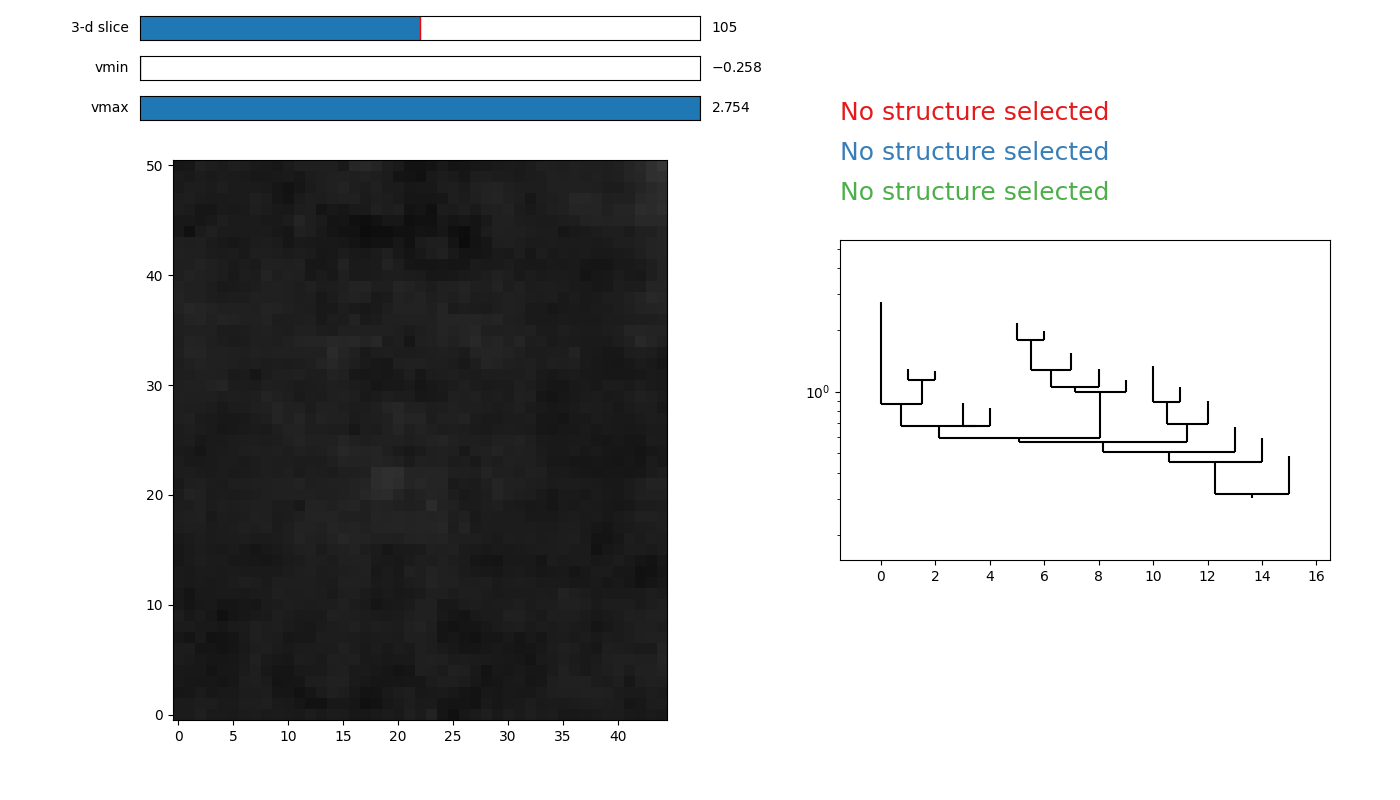

NameError: name 'Bars' is not defined

In [3]:
#Manual Contours and stuff

#HCN


Num = 1
Overlaps=1
Ram_Limiter = 1


paths = pylab.array(['cmz_HCOp.cube.K-kms.pbcor.fits',
                     'cmz_HCN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13CN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13COp.cube.reproject.K-kms.pbcor.fits'])



#path = paths[Num]
path = 'CMZ_3mm_HCN.fits'
print(path)

Noises = np.load('Noises_K_CMZ.npy')
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-200. *u.km / u.s, 200. *u.km / u.s)
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]

dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]

#No size reduction for now
scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]

#Arap1 = SkyCoord('00d30m00s','-00d00m00s', frame='galactic')#These are away from the sources
#Arap2 = SkyCoord( '00d12m00s','-00d25m00s', frame='galactic')

Arap1= SkyCoord(l=.4*u.degree,b=-00.25*u.degree, frame='galactic')
Arap2= SkyCoord(l=.25*u.degree,b=-00.08*u.degree, frame='galactic')

AP1 = [int(scW.world_to_pixel(Arap1)[0]),int(scW.world_to_pixel(Arap1)[1])]
AP2 = [int(scW.world_to_pixel(Arap2)[0]),int(scW.world_to_pixel(Arap2)[1])]


#raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
#raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[5:np.shape(dat)[0]-5,AP1[1]:AP2[1],AP1[0]:AP2[0]] # Make a subcube
#datn = dat[5:np.shape(dat)[0]-5,0:60,420:480] # Make a subcube
print(np.shape(datn))
scF = scn[5:np.shape(scn)[0]-5,AP1[1]:AP2[1],AP1[0]:AP2[0]]
#scF = scn[5:np.shape(dat)[0]-5,0:60,420:480] # Make a subcube
#scQF = scQn[5:np.shape(scQn)[0]-5,0:60,420:480] # Make a subcube
scQF = scQn[5:np.shape(scQn)[0]-5,AP1[1]:AP2[1],AP1[0]:AP2[0]]
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

header = scQF.hdu.header
#print(header)
#make metadata for the dendrogram
metadata = {}
try:
    metadata['wavelength'] = header["RESTFREQ"]*u.Hz#
except:
    metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 


#print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s

print(m,np.nanmean(datn),np.nanmax(datn))
#d = astrodendro.Dendrogram.compute(datn,min_delta= m*5,min_value = m*5,min_npix=4*2,wcs = scF.wcs) #The main culprit
d = astrodendro.Dendrogram.compute(datn,min_delta=m*2,min_value=m*5,min_npix=10,wcs = scQF.wcs) #The main culprit


#metadata["distance"] = 3.5*u.Mpc
vel,NA,na = sc.world[:,0,0]
##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()




fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map
vel,RA,Dec = scF.world[:,0,0]

ax3 = pylab.subplot(1,1,1,projection=wcs) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(scF.apply_numpy_function(np.nanmax,axis=0),cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.016,pad=0.04)                                     
cb.set_label(label='max (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='max',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  





fig = plt.figure(2,figsize=(30,30))

ds=40
SC_CM = scQF.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=False #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(3,10,n+1,projection=wcsU) # We plot them in a grid  
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*7)
    
    
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    
    beam = Circle(xy = (5,10),radius = np.sqrt(Bars[Num]),fill=True, alpha=.5,color="green")
    ax.add_patch(beam)
    ax55 = pylab.subplot(3,10,8,projection=wcsU) # We plot them in a grid 
    im55 = pylab.imshow(scQF.moment(order=2).hdu.data,cmap='rainbow')
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        Cont = True
        try:
            #print(str(t.descendants[0]).find("branch"))
            #print(str(t.descendants[0]))
            if(str(t.descendants[0]).find("branch") != -1):
                Cont = True#False #If we find a branch inside this structure t, then it is at least order two and will be discarded
        except:
            lop=12

        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            #if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>np.sqrt(NBars[1])*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 4):
            if((True)):
                #print(print(I))
                #for lmn in range(np.nanmax(I[0])-np.nanmin(I[0])):
                p.plot_contour(ax, structure=t, lw=.5, colors='red',alpha=.3,slice = int((np.nanmin(I[0])+np.nanmax(I[0]))/2))
                p.plot_contour(ax55, structure=t, lw=.5, colors='red',alpha=.3,slice = int((np.nanmin(I[0])+np.nanmax(I[0]))/2))



radsL=np.array([])
radsB=np.array([])
sigmasL=np.array([])
sigmasB=np.array([])

center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
print(center,wcs.world_to_pixel(center))
x,y = [wcs.world_to_pixel(center)[0],(wcs.world_to_pixel(center)[1])]
d0 = 7.2*10**-3*u.Mpc #mpc
for t in d.all_structures: 
    
    I = t.indices()
    Cont = True
    try:
        #print(str(t.descendants[0]).find("branch"))
        #print(str(t.descendants[0]))
        if(str(t.descendants[0]).find("branch") != -1):
            Cont = False #If we find a branch inside this structure t, then it is at least order two and will be discarded
    except:
        lop=12
    
    if(Cont):
        s = PPVStatistic(t,metadata=metadata)

        #if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>3.24899981*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>1.5*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>np.sqrt(Bars[0])*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>2*u.km/u.s and s.radius<24/.83*2*u.pix and s.radius>3.24899981*u.pix):
        if(True):
            x_cent = s.x_cen/u.pix
            y_cent = s.y_cen/u.pix


            #Find distance to Earth Assuming it lies in the same plane as the center
            D_E = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((x_cent-x)**2+(y_cent-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )
            #print(D_E)
            if(t.is_leaf):
                radsL=np.append(radsL,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)
            if(t.is_branch	):
                radsB=np.append(radsB,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)


from scipy.optimize import curve_fit

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, radsL*10**6, sigmasL)
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func, radsB*10**6, sigmasB)
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
    
Rcon = np.concatenate((radsL,radsB))
Scon = np.concatenate((sigmasL,sigmasB))

poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
print(popt,pcov,"leaves:")
print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
print(poptB,pcovB,"branches:")
print("a = ",poptB[0],"+-",np.sqrt(pcovB[0][0]))
print("b = ",poptB[1],"+-",np.sqrt(pcovB[1][1]))
print(poptCon,pcovCon,"All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

'''
fig = plt.figure()
ax = pylab.subplot(2, 1, 1)
xpL,xpB = ax.scatter(radsL*10**6,sigmasL),ax.scatter(radsB*10**6,sigmasB)
xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])
xpa1,xpa2,xpaTot = ax.plot(xs,ysL),ax.plot(xs,ysB),ax.plot(xs,ysCon)
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()
ax2 = pylab.subplot(2, 1, 2)
xpL,xpB = ax2.scatter(radsL*10**6,sigmasL),ax2.scatter(radsB*10**6,sigmasB)
p,p2,p3 = ax2.plot(xs,ysL),ax2.plot(xs,ysB),ax2.plot(xs,ysCon)
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()

'''

['HCOp_1_0_Abs_CMZRadii' 'HCN_1_0_Abs_CMZRadii' '3'
 'aaaaaaaaaaaaaaaaaaaaaa' '5']
HCN_1_0_Abs_CMZSigmas
cmz_HCN.cube.reproject.K-kms.pbcor.fits
(332, 165, 765) (332, 165, 765)
(322, 155, 755)
10.55599979032924 pix2
0.060117926 0.08487745 4.733324
(1385,)


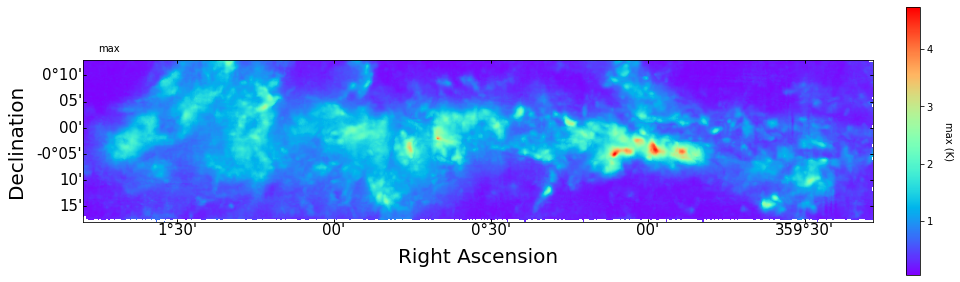

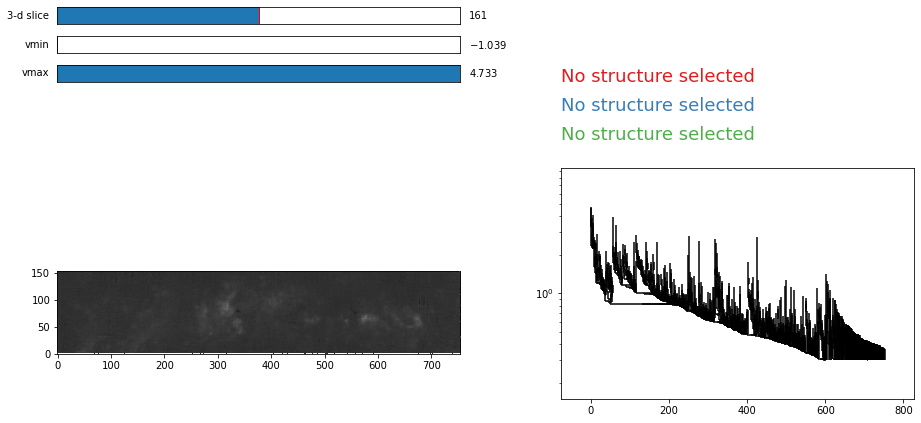

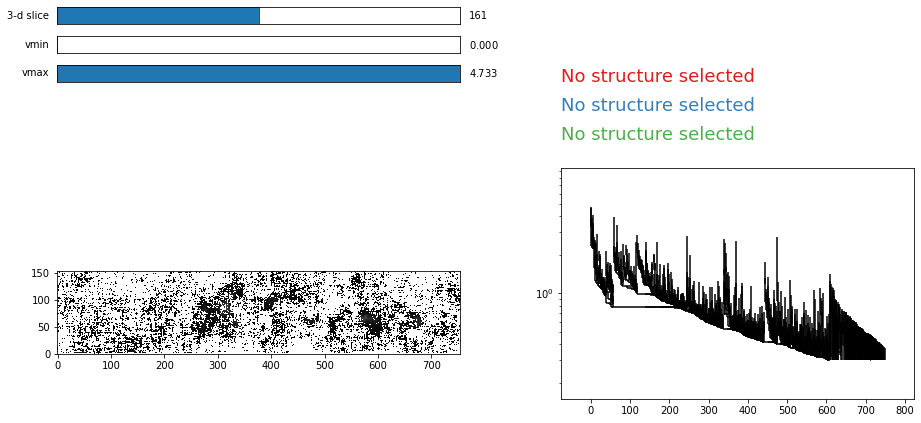

<SkyCoord (Galactic): (l, b) in deg
    (359.94487501, -0.04391769)> (array(556.0341997), array(76.32401635))
astrodendro: a =  5.298320992714518 +- 0.098706929229309
b =  0.54192396154891 +- 0.015635149893936766
Shetty eq: a =  3.358122515924716 +- 0.08928789240978453
b =  0.5841205075160826 +- 0.015424734765050383
astrodendro, no abs: a =  5.3174176603226195 +- 0.09937974137600522
b =  0.5400272360693392 +- 0.015732861014434774
Shetty eq, no abs: a =  3.37463794201602 +- 0.09009162144285011
b =  0.5823243556094472 +- 0.015526053218765832


<Figure size 2160x2160 with 0 Axes>

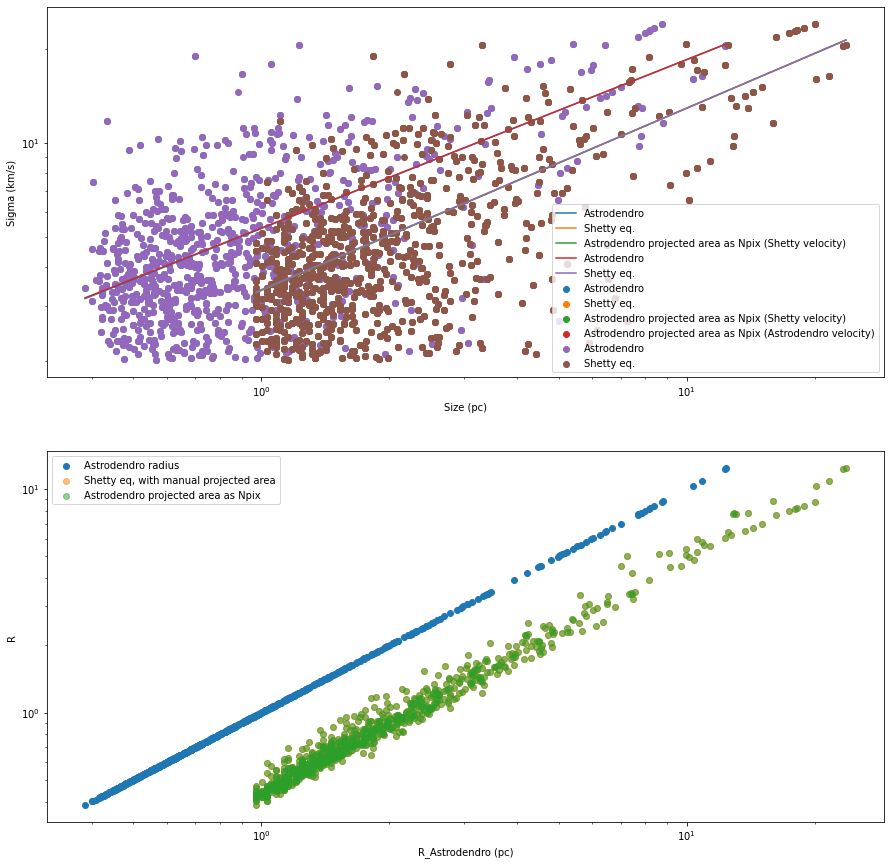

In [38]:
#size definitions from fwhm to 90% to gaussian (1sigma) 

#HCN


Num = 1
Overlaps=1
Ram_Limiter = 1
Name = "HCN_1_0_Abs_CMZ"
name = "HCN_1_0_CM_Contours_DS_10_Abs_CMZ.jpeg"
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
RNames[Num] = NameR
SNames[Num] = NameS
print(RNames)
np.save("RNames_CMZ",RNames)
np.save("SNames_CMZ",SNames)
print(NameS)

paths = pylab.array(['cmz_HCOp.cube.K-kms.pbcor.fits',
                     'cmz_HCN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13CN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13COp.cube.reproject.K-kms.pbcor.fits'])

path = paths[Num]
#path = 'CMZ_3mm_HCN.fits'
print(path)

Noises = np.load('Noises_K_CMZ.npy')
AP = np.load('Absorption_Pixels_CMZ.npy')
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]

dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]

BP = np.where(AP>0)

dat_No_Abs=np.copy(dat)
dat_No_Abs[BP]=np.nan
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]

#No size reduction for now
scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]

#Arap1 = SkyCoord('00d30m00s','-00d00m00s', frame='galactic')#These are away from the sources
#Arap2 = SkyCoord( '00d12m00s','-00d25m00s', frame='galactic')

Arap1= SkyCoord(l=.4*u.degree,b=-00.25*u.degree, frame='galactic')
Arap2= SkyCoord(l=.25*u.degree,b=-00.08*u.degree, frame='galactic')

AP1 = [int(scW.world_to_pixel(Arap1)[0]),int(scW.world_to_pixel(Arap1)[1])]
AP2 = [int(scW.world_to_pixel(Arap2)[0]),int(scW.world_to_pixel(Arap2)[1])]


#raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
#raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[5:np.shape(dat)[0]-5,5:np.shape(dat)[1]-5,5:np.shape(dat)[2]-5] # Make a subcube

datn_NA = dat_No_Abs[5:np.shape(dat)[0]-5,5:np.shape(dat)[1]-5,5:np.shape(dat)[2]-5] # Make a subcube
#datn = dat[5:np.shape(dat)[0]-5,AP1[1]:AP2[1],AP1[0]:AP2[0]] # Make a subcube
#datn = dat[5:np.shape(dat)[0]-5,0:60,420:480] # Make a subcube
print(np.shape(datn))
scF = scn[5:np.shape(dat)[0]-5,5:np.shape(dat)[1]-5,5:np.shape(dat)[2]-5]
#scF = scn[5:np.shape(scn)[0]-5,AP1[1]:AP2[1],AP1[0]:AP2[0]]
#scF = scn[5:np.shape(dat)[0]-5,0:60,420:480] # Make a subcube
#scQF = scQn[5:np.shape(scQn)[0]-5,0:60,420:480] # Make a subcube
#scQF = scQn[5:np.shape(scQn)[0]-5,AP1[1]:AP2[1],AP1[0]:AP2[0]]
scQF = scQn[5:np.shape(scQn)[0]-5,5:np.shape(scQn)[1]-5,5:np.shape(scQn)[2]-5]
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

header = scQF.hdu.header
#print(header)
#make metadata for the dendrogram
metadata = {}
try:
    metadata['wavelength'] = header["RESTFREQ"]*u.Hz#
except:
    metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam

metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix

metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 


#print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s

print(m,np.nanmean(datn),np.nanmax(datn))
#d = astrodendro.Dendrogram.compute(datn,min_delta= m*5,min_value = m*5,min_npix=4*2,wcs = scF.wcs) #The main culprit
d = astrodendro.Dendrogram.compute(datn,min_delta = m,min_value = m*5, min_npix=50,wcs = scQF.wcs) #The main culprit

d_no_abs = astrodendro.Dendrogram.compute(datn_NA,min_delta = m,min_value = m*5, min_npix=50,wcs = scQF.wcs) #The main culprit



fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map
vel,RA,Dec = scF.world[:,0,0]

ax3 = pylab.subplot(1,1,1,projection=wcs) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(scF.apply_numpy_function(np.nanmax,axis=0),cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.016,pad=0.04)                                     
cb.set_label(label='max (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='max',fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  





#metadata["distance"] = 3.5*u.Mpc
vel,NA,na = sc.world[:,0,0]
##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()

v = d_no_abs.viewer()
v.show()
p=d_no_abs.plotter()

fig = plt.figure(2,figsize=(30,30))

ds=40
SC_CM = scQF.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(3,10,n+1,projection=wcsU) # We plot them in a grid  
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*7)
    
    
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    
    beam = Circle(xy = (5,10),radius = np.sqrt(Bars[Num]),fill=True, alpha=.5,color="green")
    ax.add_patch(beam)
    ax55 = pylab.subplot(3,10,8,projection=wcsU) # We plot them in a grid 
    im55 = pylab.imshow(scQF.moment(order=2).hdu.data,cmap='rainbow')
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        Cont = True
        try:
            #print(str(t.descendants[0]).find("branch"))
            #print(str(t.descendants[0]))
            if(str(t.descendants[0]).find("branch") != -1):
                Cont = True#False #If we find a branch inside this structure t, then it is at least order two and will be discarded
        except:
            lop=12

        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            #if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>np.sqrt(NBars[1])*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 4):
            if((True)):
                #print(print(I))
                #for lmn in range(np.nanmax(I[0])-np.nanmin(I[0])):
                p.plot_contour(ax, structure=t, lw=.5, colors='red',alpha=.3,slice = int((np.nanmin(I[0])+np.nanmax(I[0]))/2))
                p.plot_contour(ax55, structure=t, lw=.5, colors='red',alpha=.3,slice = int((np.nanmin(I[0])+np.nanmax(I[0]))/2))



radsL=np.array([])
radsB=np.array([])
sigmasL=np.array([])
sigmasB=np.array([])

radsL_Sh=np.array([])
radsB_Sh=np.array([])
sigmasL_Sh=np.array([])
sigmasB_Sh=np.array([])


radsL_ex=np.array([])
radsB_ex=np.array([])



center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
print(center,wcs.world_to_pixel(center))
x,y = [wcs.world_to_pixel(center)[0],(wcs.world_to_pixel(center)[1])]
d0 = 7.2*10**-3*u.Mpc #mpc
for t in d.all_structures: 
    I = t.indices()
    Cont = True
    try:
        if(str(t.descendants[0]).find("branch") != -1):
            Cont = False #If we find a branch inside this structure t, then it is at least order two and will be discarded
    except:
        lop=12
    if(Cont):
        s = PPVStatistic(t,metadata=metadata)
        nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
        vel,RA,Dec = scF.world[:,0,0]
        v_IWM = np.nansum(datn[I]*vel[I[0]]/u.km*u.s)/np.nansum(datn[I])
        sig_Sh = np.sqrt(np.nansum(datn[I]*(vel[I[0]]/u.km*u.s-v_IWM)**2)/np.nansum(datn[I]))           
        #if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>3.24899981*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>1.5*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>np.sqrt(Bars[0])*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>2*u.km/u.s and s.radius<24/.83*2*u.pix and s.radius>3.24899981*u.pix):
        if(True):
            x_cent = s.x_cen/u.pix
            y_cent = s.y_cen/u.pix


            #Find distance to Earth Assuming it lies in the same plane as the center
            D_E = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((x_cent-x)**2+(y_cent-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )
            #print(D_E)5
            if(t.is_leaf):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix*2/np.pi)))>np.sqrt(Bars[1]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                                                                                                                                                   
                    radsL=np.append(radsL,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



                    radsL_Sh=np.append(radsL_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does
                    sigmasL_Sh=np.append(sigmasL_Sh,(float(sig_Sh)))#

                    radsL_ex=np.append(radsL_ex,(float(np.sqrt(s.area_exact/u.pix**2*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does


            if(t.is_branch	):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix*2/np.pi)))>np.sqrt(Bars[1]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                    radsB=np.append(radsB,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)


                    radsB_Sh=np.append(radsB_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi))))
                    sigmasB_Sh=np.append(sigmasB_Sh,(float(sig_Sh)))#

                    radsB_ex=np.append(radsB_ex,(float(np.sqrt(s.area_exact/u.pix**2*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does


radsLNA=np.array([])
radsBNA=np.array([])
sigmasLNA=np.array([])
sigmasBNA=np.array([])

radsL_ShNA=np.array([])
radsB_ShNA=np.array([])
sigmasL_ShNA=np.array([])
sigmasB_ShNA=np.array([])

for t in d_no_abs.all_structures: 
    I = t.indices()
    Cont = True
    try:
        if(str(t.descendants[0]).find("branch") != -1):
            Cont = False #If we find a branch inside this structure t, then it is at least order two and will be discarded
    except:
        lop=12
    if(Cont):
        s = PPVStatistic(t,metadata=metadata)
        nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
        vel,RA,Dec = scF.world[:,0,0]
        v_IWM = np.nansum(datn_NA[I]*vel[I[0]]/u.km*u.s)/np.nansum(datn_NA[I])
        sig_Sh = np.sqrt(np.nansum(datn_NA[I]*(vel[I[0]]/u.km*u.s-v_IWM)**2)/np.nansum(datn_NA[I]))           
        #if(s.v_rms>2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>3.24899981*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>1.5*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3*2.0475**2*1.3807 and s.radius<24*2*2.0475*u.pix and s.radius>np.sqrt(Bars[0])*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2*1.3807):
        #if(s.v_rms>2*u.km/u.s and s.radius<24/.83*2*u.pix and s.radius>3.24899981*u.pix):
        if(True):
            x_cent = s.x_cen/u.pix
            y_cent = s.y_cen/u.pix


            #Find distance to Earth Assuming it lies in the same plane as the center
            D_E = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((x_cent-x)**2+(y_cent-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )
            #print(D_E)5
            if(t.is_leaf):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix*2/np.pi)))>np.sqrt(Bars[1]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                                                                                                                                                   
                    radsLNA=np.append(radsL,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasLNA=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



                    radsL_ShNA=np.append(radsL_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))) #define size as shetty does
                    sigmasL_ShNA=np.append(sigmasL_Sh,(float(sig_Sh)))#
            if(t.is_branch	):
                #if(sig_Sh>1):
                if(sig_Sh>2 and (float(np.sqrt(nproj_pix*2/np.pi)))>np.sqrt(Bars[1]) and (float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi)))*10**6 <24):
                    radsBNA=np.append(radsB,(float(s.radius*metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc))) #convert pixel to pc (then make it dimensionless)
                    sigmasBNA=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)


                    radsB_ShNA=np.append(radsB_Sh,(float(np.sqrt(nproj_pix*(metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*D_E/u.Mpc*u.pix)**2/np.pi))))
                    sigmasB_ShNA=np.append(sigmasB_Sh,(float(sig_Sh)))#
from scipy.optimize import curve_fit

def func(R,a,b):
    return a*R**(b)
  
Rcon = np.concatenate((radsL,radsB))
Scon = np.concatenate((sigmasL,sigmasB))

Rcon_Sh = np.concatenate((radsL_Sh,radsB_Sh))
Scon_Sh = np.concatenate((sigmasL_Sh,sigmasB_Sh))


RconNA = np.concatenate((radsLNA,radsBNA))
SconNA = np.concatenate((sigmasLNA,sigmasBNA))

Rcon_ShNA = np.concatenate((radsL_ShNA,radsB_ShNA))
Scon_ShNA = np.concatenate((sigmasL_ShNA,sigmasB_ShNA))




Rcon_ex = np.concatenate((radsL_ex,radsB_ex))

poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)

poptCon_Sh, pcovCon_Sh = curve_fit(func, Rcon_Sh*10**6, Scon_Sh)


poptConNA, pcovConNA = curve_fit(func, RconNA*10**6, SconNA)
poptCon_ShNA, pcovCon_ShNA = curve_fit(func, Rcon_ShNA*10**6, Scon_ShNA)


poptCon_Ex, pcovCon_Ex = curve_fit(func, Rcon_ex*10**6, Scon_Sh)

print("astrodendro: a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

print("Shetty eq: a = ",poptCon_Sh[0],"+-",np.sqrt(pcovCon_Sh[0][0]))
print("b = ",poptCon_Sh[1],"+-",np.sqrt(pcovCon_Sh[1][1]))


print("astrodendro, no abs: a = ",poptConNA[0],"+-",np.sqrt(pcovConNA[0][0]))
print("b = ",poptConNA[1],"+-",np.sqrt(pcovConNA[1][1]))

print("Shetty eq, no abs: a = ",poptCon_ShNA[0],"+-",np.sqrt(pcovCon_ShNA[0][0]))
print("b = ",poptCon_ShNA[1],"+-",np.sqrt(pcovCon_ShNA[1][1]))


fig = plt.figure(1,figsize=(15,15))
ax = pylab.subplot(2, 1, 1)
xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ys=func(xs,poptCon[0],poptCon[1])

xsSh=np.linspace(np.nanmin(Rcon_Sh*10**6),np.nanmax(Rcon_Sh*10**6),50)
ysSh=func(xsSh,poptCon_Sh[0],poptCon_Sh[1])



xsNA=np.linspace(np.nanmin(RconNA*10**6),np.nanmax(RconNA*10**6),50)
ysNA=func(xsNA,poptConNA[0],poptConNA[1])

xsShNA=np.linspace(np.nanmin(Rcon_ShNA*10**6),np.nanmax(Rcon_ShNA*10**6),50)
ysShNA=func(xsShNA,poptCon_ShNA[0],poptCon_ShNA[1])




xsShE=np.linspace(np.nanmin(Rcon_ex*10**6),np.nanmax(Rcon_ex*10**6),50)
ysShE=func(xsShE,poptCon_Ex[0],poptCon_Ex[1])

xpa, xpaSh, xpaExSh = ax.plot(xs,ys,label="Astrodendro"),ax.plot(xsSh,ysSh,label="Shetty eq."),ax.plot(xsShE,ysShE,label="Astrodendro projected area as Npix (Shetty velocity)")

xpaS, xpaShS,xpaSeXSH,xpaSeXAST = ax.scatter(Rcon*10**6,Scon,label="Astrodendro"),ax.scatter(Rcon_Sh*10**6,Scon_Sh,label="Shetty eq."),ax.scatter(Rcon_ex*10**6,Scon_Sh,label="Astrodendro projected area as Npix (Shetty velocity)"),ax.scatter(Rcon_ex*10**6,Scon,label="Astrodendro projected area as Npix (Astrodendro velocity)")



xpaNA, xpaShNA= ax.plot(xsNA,ysNA,label="Astrodendro"),ax.plot(xsShNA,ysShNA,label="Shetty eq.")

xpaSNA, xpaShSNA = ax.scatter(RconNA*10**6,SconNA,label="Astrodendro"),ax.scatter(Rcon_ShNA*10**6,Scon_ShNA,label="Shetty eq.")



ax2 = pylab.subplot(2,1,2)

xparast,xparS, xparShS = ax2.scatter(Rcon*10**6,Rcon*10**6,label="Astrodendro radius"),ax2.scatter(Rcon_Sh*10**6,Rcon*10**6,label="Shetty eq, with manual projected area",alpha=.5),ax2.scatter(Rcon_ex*10**6,Rcon*10**6,label="Astrodendro projected area as Npix",alpha=.5)

ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Size (pc)")
ax.set_ylabel("Sigma (km/s)")

ax2.legend()
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel("R_Astrodendro (pc)")
ax2.set_ylabel("R")
pylab.show()



NameSL = (NameS+"_Leaves")
NameSB = (NameS+"_Branches")
NameRL = (NameR+"_Leaves")
NameRB = (NameR+"_Branches")

NameSLN = (NameS+"_Leaves_No_Abs")
NameSBN = (NameS+"_Branches_No_Abs")
NameRLN = (NameR+"_Leaves_No_Abs")
NameRBN = (NameR+"_Branches_No_Abs")



np.save(NameSL,sigmasL_Sh)
np.save(NameSB,sigmasB_Sh)
np.save(NameRL,radsL_Sh)
np.save(NameRB,radsB_Sh)


np.save(NameSLN,sigmasL_ShNA)
np.save(NameSBN,sigmasB_ShNA)
np.save(NameRLN,radsL_ShNA)
np.save(NameRBN,radsB_ShNA)

In [15]:
#I = [vel][dec][ra] pixels
projection=[]
print(([1,2]),([3,4]))
print(set(zip(([1,2]),([3,4]))))
projection.append([2,3])
projection.append([4,5])
print(projection)

print(datn[I])
print(datn[0,0,0])
print(set([(1,2),(3,4)]))

[1, 2] [3, 4]
{(2, 4), (1, 3)}
[[2, 3], [4, 5]]
[0.34825033 0.43122065 0.34619594 ... 0.43341416 0.438806   0.53609294]
nan
{(1, 2), (3, 4)}


In [2]:
paths = pylab.array(['cmz_HCOp.cube.K-kms.pbcor.fits',
                     'cmz_HCN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13CN.cube.reproject.K-kms.pbcor.fits',
                     'cmz_H13COp.cube.reproject.K-kms.pbcor.fits'])
Npaths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_HCN_J1.cube.reproject.K-kms.pbcor.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])



Bars = []
NBars = []
SpecRes=[]
NSpecRes=[]
SpRess=[]
NSpRess=[]

#make metadata for the dendrogram
def make(h):
    hp= fits.getheader(h)
    metadata = {}
    metadata['arc_per_pix'] =  abs(hp["CDELT1"]*3600.0 * u.arcsec)#should be arc/ pixels
    metadata['beam_major'] =  hp["BMAJ"]*3600.0 * u.arcsec
    metadata['beam_minor'] =  hp["BMIN"]*3600.0 * u.arcsec
    beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 #Would be square pixels per beam
    return beam_area_ratio

#print(fits.getheader('NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits'))
#print(fits.getheader('NGC253_HCN.cube.reproject.K-kms.pbcor.fits'))
#print(fits.getheader('H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits'))
def Sres(h):
    return abs(fits.getheader(h)["CDELT3"])#km/s/pix

def Spres(h,d):
    return abs(fits.getheader(h)["CDELT1"]*d*np.pi/180)#pc/pixel
Bars.append(make(paths[0]))
Bars.append(make(paths[1]))
Bars.append(make(paths[2]))
Bars.append(make(paths[3]))
#NBars.append(make(Npaths[9]))
#NBars.append(make(Npaths[10]))
#NBars.append(make(Npaths[8]))
#NBars.append(make(Npaths[5]))
NBars.append(make(Npaths[0]))
NBars.append(make(Npaths[1]))
NBars.append(make(Npaths[2]))
NBars.append(make(Npaths[5]))

print(np.sqrt(np.array(Bars)),np.sqrt(np.array(NBars)))
SpecRes.append(Sres(paths[0]))
SpecRes.append(Sres(paths[1]))
SpecRes.append(Sres(paths[2]))
SpecRes.append(Sres(paths[3]))

#NSpecRes.append(Sres(Npaths[9]))
#NSpecRes.append(Sres(Npaths[10]))
#NSpecRes.append(Sres(Npaths[8]))
#NSpecRes.append(Sres(Npaths[5]))
NSpecRes.append(Sres(Npaths[0]))
NSpecRes.append(Sres(Npaths[1]))
NSpecRes.append(Sres(Npaths[2]))
NSpecRes.append(Sres(Npaths[5]))

SpRess.append(Spres(paths[0],7.2*10**3))
SpRess.append(Spres(paths[1],7.2*10**3))
SpRess.append(Spres(paths[2],7.2*10**3))
SpRess.append(Spres(paths[3],7.2*10**3))
#NSpRess.append(Spres(Npaths[9],3.5*10**6))
#NSpRess.append(Spres(Npaths[10],3.5*10**6))
#NSpRess.append(Spres(Npaths[8],3.5*10**6))
#NSpRess.append(Spres(Npaths[5],3.5*10**6))
NSpRess.append(Spres(Npaths[0],3.5*10**6))
NSpRess.append(Spres(Npaths[1],3.5*10**6))
NSpRess.append(Spres(Npaths[1],3.5*10**6))
NSpRess.append(Spres(Npaths[5],3.5*10**6))

print(SpRess,NSpRess)
np.save("CZM_Beam_Area_Ratios",Bars)
np.save("NGC_Beam_Area_Ratios",NBars)

np.save("CZM_Sres",SpecRes)
np.save("NGC_Sres",NSpecRes)

np.save("CZM_Spres",SpRess)
np.save("NGC_Spres",NSpRess)


print(Bars,NBars)

Bars = np.load("CZM_Beam_Area_Ratios.npy")
NBars = np.load("NGC_Beam_Area_Ratios.npy")

SpecRes = np.load("CZM_Sres.npy")
NSpecRes = np.load("NGC_Sres.npy")


[3.24899981 3.24899981 3.24899981 3.24899981] [4.29292398 4.31290951 4.47473815 4.83965997]
[0.418879046138749, 0.418879046138749, 0.418879046138749, 0.418879046138749] [0.8484239419417557, 0.8484239419417557, 0.8484239419417557, 0.8484239419417557]
[<Quantity 10.55599979>, <Quantity 10.55599979>, <Quantity 10.55599979>, <Quantity 10.55599979>] [<Quantity 18.42919627>, <Quantity 18.60118844>, <Quantity 20.02328153>, <Quantity 23.42230858>]


In [2]:
!py -m jupyter server list


usage: jupyter.py [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
                  [--paths] [--json] [--debug]
                  [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands:

Jupyter command `jupyter-server` not found.
